In [ ]:
from importlib import reload # to reload modules
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
from matplotlib import colormaps # colormaps
from matplotlib.colors import hsv_to_rgb
from matplotlib.legend_handler import HandlerLine2D

import pandas as pd # Pandas
import uproot
import pickle
import logging
import pprint
from adjustText import adjust_text

import os # read directories etc.
from scipy.optimize import curve_fit
import pylandau

# import time
# from timeout_decorator import timeout

import LoadBatch
reload(LoadBatch)
from LoadBatch import *
from SensorClasses import *

verbose = False

In [2]:
# logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] - \t %(message)s')

In [3]:
### Load the dictionary of batches
dict_of_batches = read_pickle("dict_of_batches.pickle")

logging.info(f"dictionary of the batches: \n{dict_of_batches.keys()}")

### charge fit folder
ROOT_fit_dir = "/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/testbeam-analysis/ROOT_Langaus_fit/Charge_fit_results"

### presentation path
pres_path = '/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/Presentations/2024-10-03 for Mengqing'

[INFO] - 	 dictionary of the batches: 
dict_keys([199, 100, 101, 201, 202, 203, 301, 401, 402, 403, 204, 406, 407, 408, 409, 410, 411, 205, 206, 413, 414, 501, 502, 504, 505, 601, 602, 603, 604, 605, 701, 702, 801, 802, 901, 902, 1001, 1002, 1101, 1102, 1201, 1202, 5031, 5032])


In [4]:
# unique_names = []
# for batch_object in dict_of_batches.values():
#     for S in ['S1','S2']:
#         for ch, sensor in batch_object.S[S].channels.items():
#             if (sensor.name != '') and (sensor.name not in unique_names):
#                 unique_names.append(sensor.name)
# logging.info(f"{unique_names}")

# for name in unique_names:
#     for batch_object in dict_of_batches.values():
#         for S in ['S1','S2']:  
#                 for ch, sensor in batch_object.S[S].channels.items():
#                     if (sensor.name == name):
#                         if (sensor.voltage == 0) or (sensor.voltage is None): continue 
#                         print(f"{sensor.name}, board: {sensor.board}\tV: {sensor.voltage}, angle: {batch_object.angle}°,", "temp: %.2f°C,"%batch_object.temperature, f"fluence: {sensor.fluence}, in batch {batch_object.batch_number}, {S}, {ch})")
#     print('-'*100)

In [5]:
# unique_names

In [2]:
def load_run(run_number, S_run, dictionary_of_batches):
    ### ACTUALLY I WANT TO BE ABLE TO PLOT RUNS THAT I HAVE REMOVED (AND SEE WHY I DID)
    ### automatically find which batch it belongs to
    batch_found = 0
    for batch_number,batch_object in dictionary_of_batches.items():
        if (batch_object.S[S_run] is not None) and (run_number in batch_object.S[S_run].runs):
            batch_found = batch_number
            logging.info(f"Run {run_number} found in batch {batch_found}")
    if batch_found == 0:   ### return error if it's missing
        logging.warnig(f"The run {run_number} was not in any of the batches, it may have been removed or it may not exist")

    ### load run
    dir_path = f"../Data_TestBeam/2023_May/{S_run}/"
    if run_number>9999:    file_path = f"tree0{run_number}.root"
    elif run_number<=9999: file_path = f"tree00{run_number}.root"
    
    ### branches to be loaded (+ unnecessary columns)
    branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "noise", "pedestal", "timeCFD20", "timeCFD50", "timeCFD70"]
    columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

    try:
        logging.info(f"Loading run {run_number} from {file_path}")
        df_run = root_to_df(os.path.join(dir_path, file_path), branches)
    except FileNotFoundError:
        logging.error("Run file not found")
        return None
    except Exception as e:
        logging.error(f"in load_run(), raised exception {e}")

    df_run = root_to_df(os.path.join(dir_path, file_path), branches)
    df_run = df_run.drop(columns=columns_to_remove) 
    
    ### return dataframe and batch number
    return df_run, batch_found


def quick_analysis(run, S_run, df_analysis, dict_of_batches, DUTs=None):
    """
    loads the dataframe from a run and store the main variables inside the df_analysis
    """
#     print(df_analysis.columns)
    ### dafaults
    if DUTs is None: DUTs = [1,2,3]
    threshold_charge = 4
    charge_bins = 500
    ### load run
    df_run, this_batch = load_run(run, S_run, dict_of_batches)
    idx_run = dict_of_batches[this_batch].S[S_run].runs.index(run)
    ### calculate time resolution
    central_sensor_area_cuts = [geometry_mask(df_run, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='center', use=use_for_geometry_cut)[0] if dut in DUTs else None for dut in [1,2,3]]
    charge_cut = [df_run[f'charge_{dut}']>threshold_charge if dut in DUTs else None for dut in [1,2,3]]
    
    ### cuts
    mins = [find_min_btw_peaks(df_run[f"pulseHeight_{dut}"], bins='rice', plot=False) if dut in DUTs else None for dut in [1,2,3]]
    pulse_cuts = [df_run[f'pulseHeight_{dut}']>mins[dut-1] if dut in DUTs else None for dut in [1,2,3]]
    pulse_noise_cuts = [df_run[f'pulseHeight_{dut}']>(df_run[f"pedestal_{dut}"]+3*df_run[f"noise_{dut}"]) if dut in DUTs else None for dut in [1,2,3]]
    
    ### time cuts
    time_cuts = [time_mask(df_run, dut, bins=time_bins, mask=central_sensor_area_cuts[dut-1], n_bootstrap=False, plot=False)[0] if dut in DUTs else None for dut in [1,2,3]]
    time_fit_cut = [np.logical_and(np.logical_and(pulse_noise_cuts[dut-1], charge_cut[dut-1]), time_cuts[dut-1])
                           if dut in DUTs else None for dut in [1,2,3]]
    ### time fit 
    _, time_parameters = zip(*[time_mask(df_run, dut, bins=100, mask=np.logical_and(central_sensor_area_cuts[dut-1],time_fit_cut[dut-1]), 
                                                n_bootstrap=False, plot=False) if dut in DUTs else [None,None] for dut in [1,2,3]])
    logging.debug(f"time fit results: {time_parameters}")
    all_cuts = [np.logical_and(np.logical_and(central_sensor_area_cuts[dut-1], time_cuts[dut-1]), pulse_cuts[dut-1]) 
                if dut in DUTs else None for dut in [1,2,3]]
#             np.savetxt(os.path.join(dir_path, f"charge_data_all_cuts_{this_batch}_{S}_{dut}.csv"),
#                        df[S][f'charge_{dut}'].loc[all_cuts[dut-1]]/my_transimpedance, delimiter=',')
#             os.chdir(ROOT_fit_dir)
#             run_root_string = f'root -b -q "charge_fit.C({this_batch},\\"{S}\\",{dut})"'
#             os.system(run_root_string)
    for dut in DUTs:
        charge_parameters, charge_covar = charge_fit(df_run, dut, mask=all_cuts[dut-1], transimpedance=4700, bins=charge_bins,
                                          plot=True)#, savefig=os.path.join(dir_path,f"charge_plot_fit_{this_batch}_{S}_{dut}.png"))
        eff = efficiency(df_run[f"charge_{dut}"].loc[all_cuts[dut-1]], threshold=threshold_charge)
        batch_object = dict_of_batches[this_batch]
        sensor_object = batch_object.S[S_run].get_sensor(f"Ch{dut+1}")
        time_
#         print(sensor_object.__dict__)
        df_analysis.loc[run,dut] = (sensor_object.name,   ### name of the sensor
                                    batch_object.S[S_run].get_sensor("Ch1").voltage, ### MCP voltage
                                    sensor_object.voltage, ### dut voltage
                                    sensor_object.current, ### dut current 
                                    batch_object.S[S_run].tempA[idx_run],  ### temperatureA
                                    batch_object.S[S_run].tempB[idx_run],  ### temperatureB                            
                                    batch_object.angle, ### angle
                                    batch_object.humidity, ### humidity
                                    sensor_object.fluence,    ### fluence
                                    charge_parameters[0],    ### charge
                                    charge_covar[0,0],       ### charge_error
                                    eff,          ### efficiency
                                    time_parameters[dut-1]['parameters'][1], ### time_mean
                                    time_parameters[dut-1]['parameters'][2], ### time_res
                                    time_parameters[dut-1]['parameters_errors'][2],  ### error on time_res
                                    {}, ### comments
                                    False) ### exclude
#         print(df_analysis.loc[run,dut])
    

In [8]:
# load_run(9620, 'S1', dict_of_batches)

In [3]:
# dict_of_batches[this_batch].S[S_run].runs.index(run)
dict_of_batches[this_batch].S['S1'].get_sensor('Ch1').__dict__

NameError: name 'dict_of_batches' is not defined

In [9]:
### looking at runs in a single batch
### relevant batches: 413, 411
### relevant runs: 9767

### interesting: 
### 413, for changing temperature
### 402
this_batch = 413
S_run = 'S1'
DUTs = [1,2,3]
dir_path = f"../Data_TestBeam/2023_May/{S_run}/"

SAVE = True

display(dict_of_batches[this_batch].__dict__)

these_runs = dict_of_batches[this_batch].S[S_run].runs

these_runs


{'batch_number': 413,
 'angle': 6.0,
 'humidity': 12.41111111111111,
 'temperature': -30.22638888888889,
 'S': {'S1': <SensorClasses.Oscilloscope at 0x7f51096b1960>,
  'S2': <SensorClasses.Oscilloscope at 0x7f51096b1d80>}}

[9761, 9762, 9763, 9764, 9769, 9775]

In [69]:
# time_parameters = [time_mask(df_run, dut, bins=time_bins, #mask=np.logical_and(central_sensor_area_cuts[dut-1],charge_cut[dut-1]), 
#                                  n_bootstrap=50, plot=False) if dut in DUTs else None for dut in [1,2,3]]


In [10]:
make_new_df = True

### I will be looking at runs from the same batch (and usually one S)
columns_df = ['sensor name', 'MCP_voltage', 'voltage', 'current', 'tempA', 'tempB', 'angle', 'humidity', 'fluence', 'charge', 'charge_error', 'efficiency', 'time_mean', 'time_sigma', 'time_sigma_error', 'comments', 'exclude']
print("TOTAL COLUMNS NUMBER:",len(columns_df))
### Create a new empty dataframe
if make_new_df:
    ### create index
    multi_index = pd.MultiIndex.from_product((these_runs,DUTs), names=['run', 'dut'])
    logging.warning(f"Creating new (empty) dataframe")
    ### initialize dataframe (empty)
    df_analysis = pd.DataFrame(index=multi_index, columns=columns_df)
    idx = pd.IndexSlice
    print(df_analysis.columns)

[WARNING] - 	 Creating new (empty) dataframe


TOTAL COLUMNS NUMBER: 17
Index(['sensor name', 'MCP_voltage', 'voltage', 'current', 'tempA', 'tempB',
       'angle', 'humidity', 'fluence', 'charge', 'charge_error', 'efficiency',
       'time_mean', 'time_sigma', 'time_sigma_error', 'comments', 'exclude'],
      dtype='object')


In [71]:
# df_analysis.loc[9631,1]["time_resolution"]
# time_parameters
# dict_of_batches[413].S['S1'].runs

[INFO] - 	 Run 9761 found in batch 413
[INFO] - 	 Loading run 9761 from tree009761.root
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.01722908e+03 -5.91392901e+03  4.33128361e+01  1.90399766e-02]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.12431297e+03 -5.94699203e+03  4.05604049e+01  2.20644593e-02]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.36411779e+03 -6.08640014e+03  3.15301033e+01  1.91879912e-02]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.07720134e+02 -5.91417294e+03  3.94985630e+01  1.53069394e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.11209429e+02 -5.94728564e+03  3.68640778e+01  1.77335512e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.02999227e+02 -6.08635836e+03  2.72632323e+01  2.64502364e+00]
[INFO] - 	 First charge estimate: 27.205333709716797
[INFO] - 	 First charge estimate: 28.326488494873047
[INFO] - 	 First charge estimate: 28.935253143310547


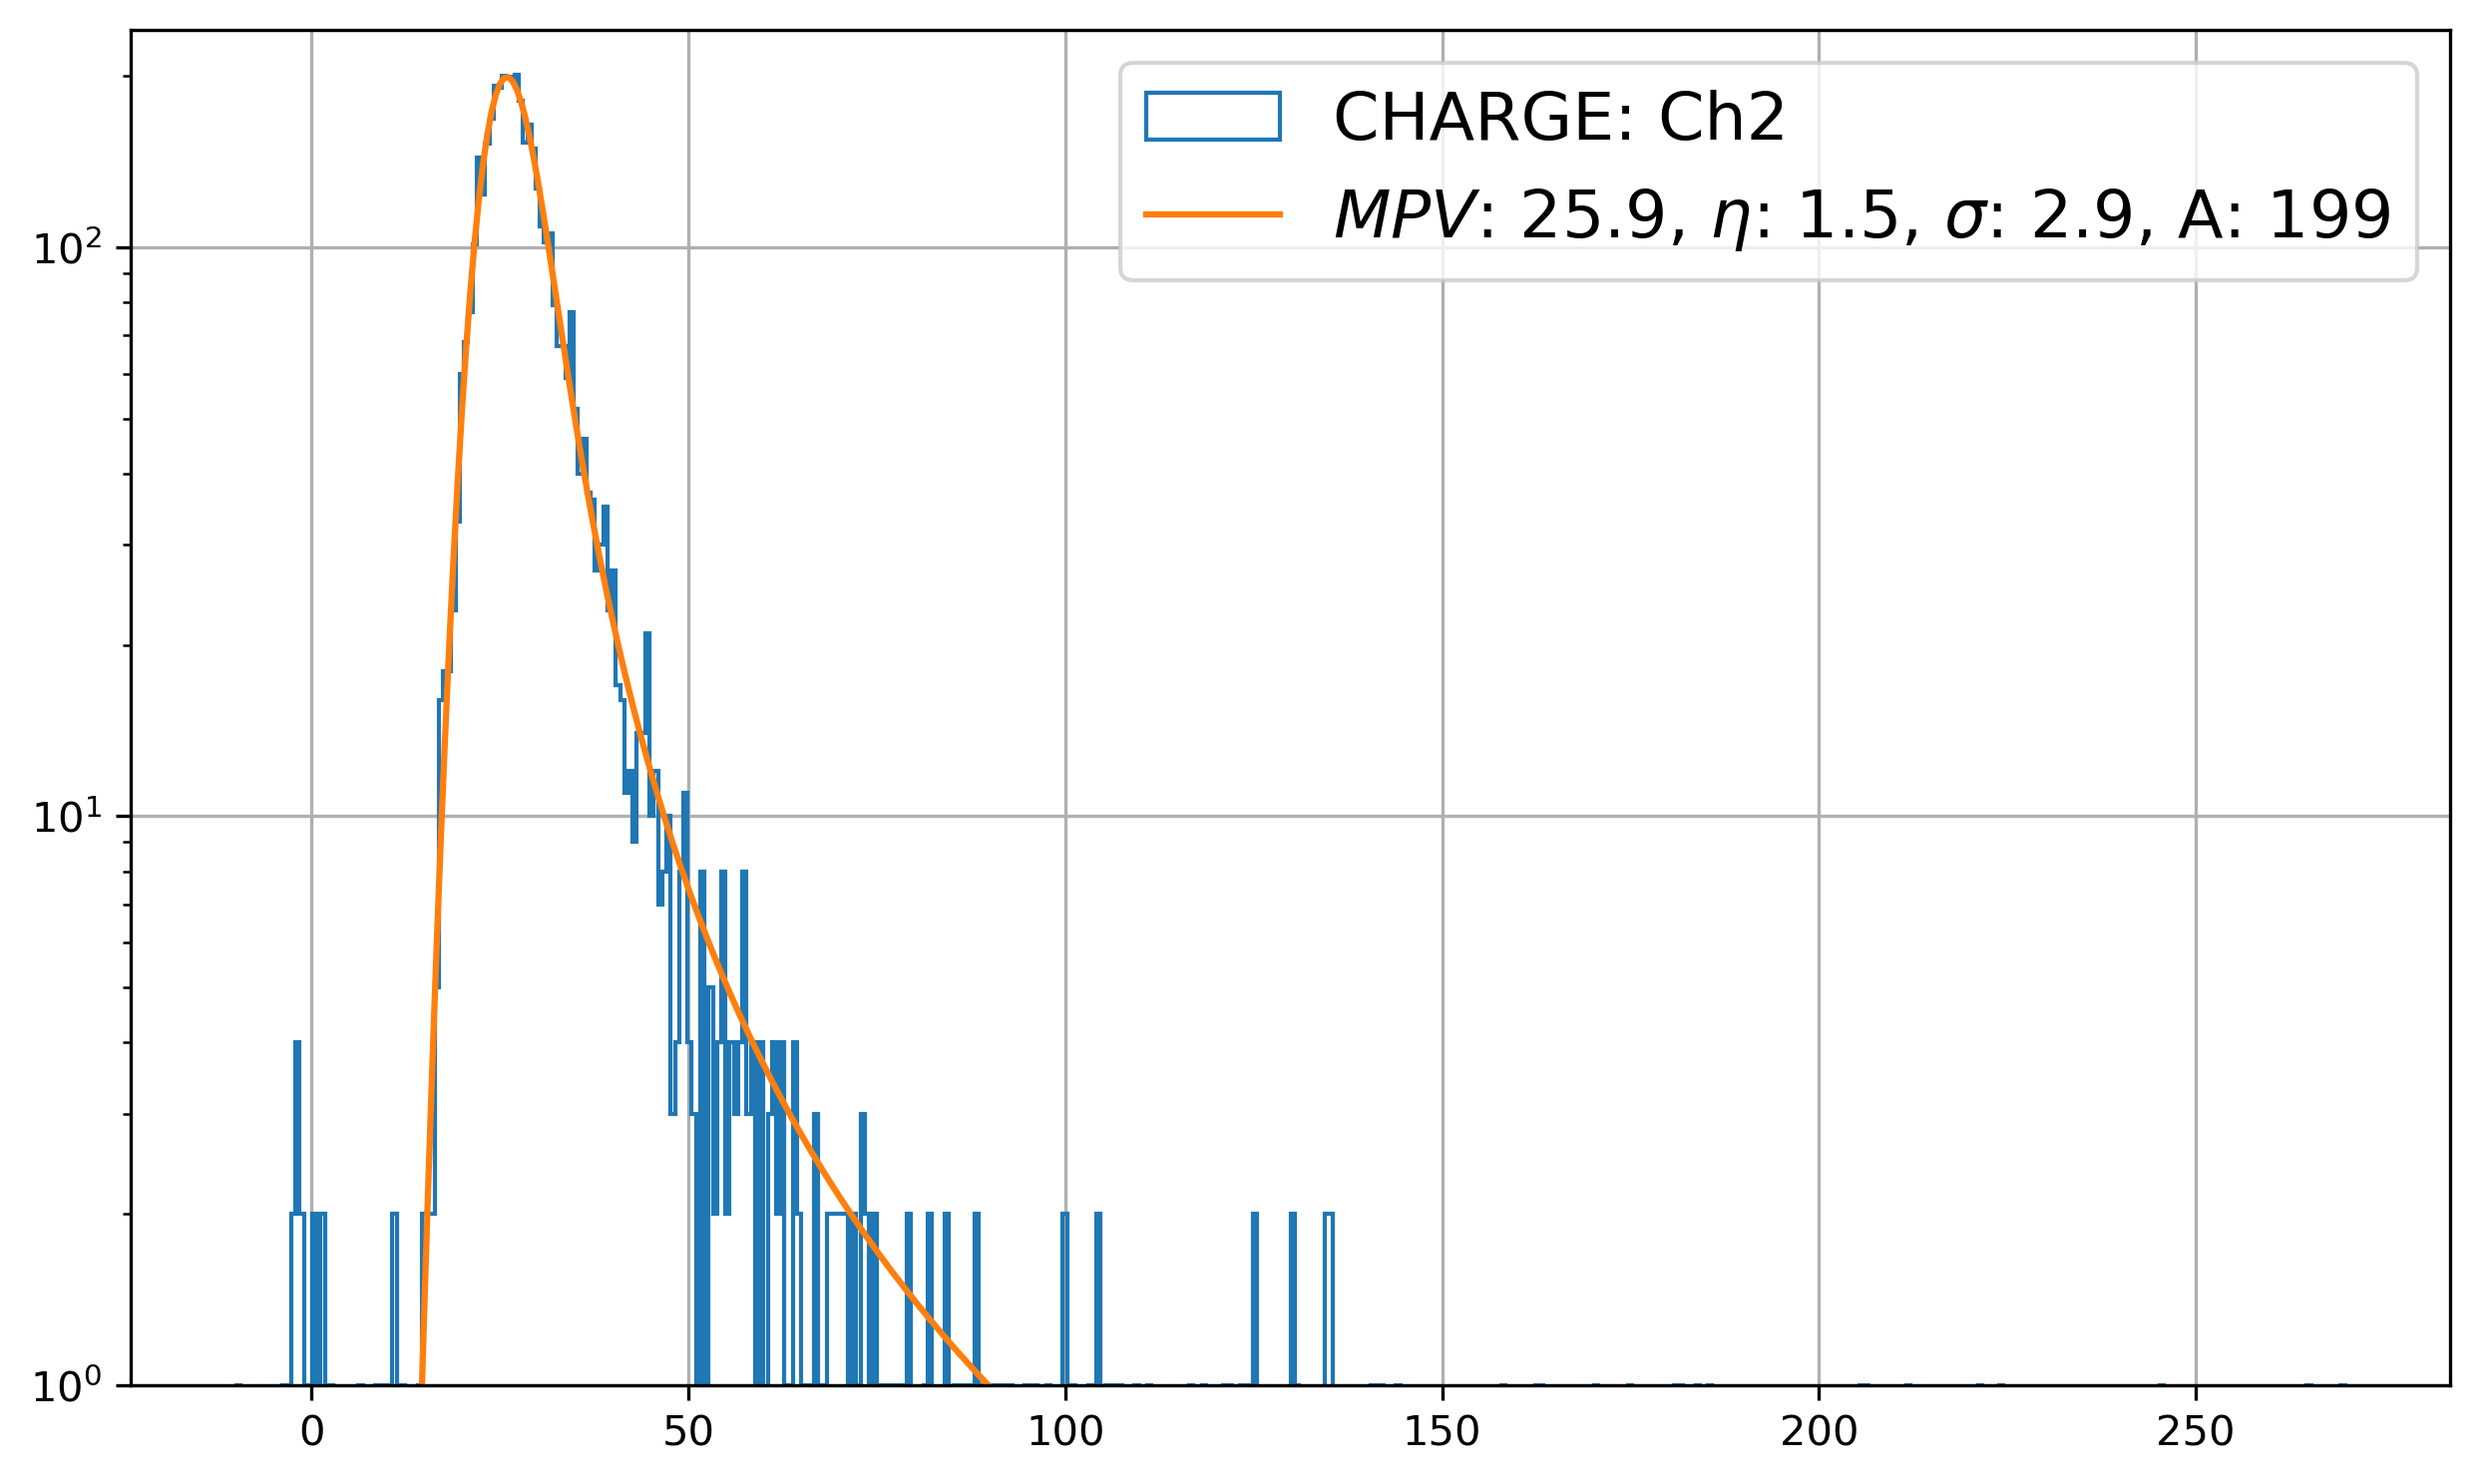

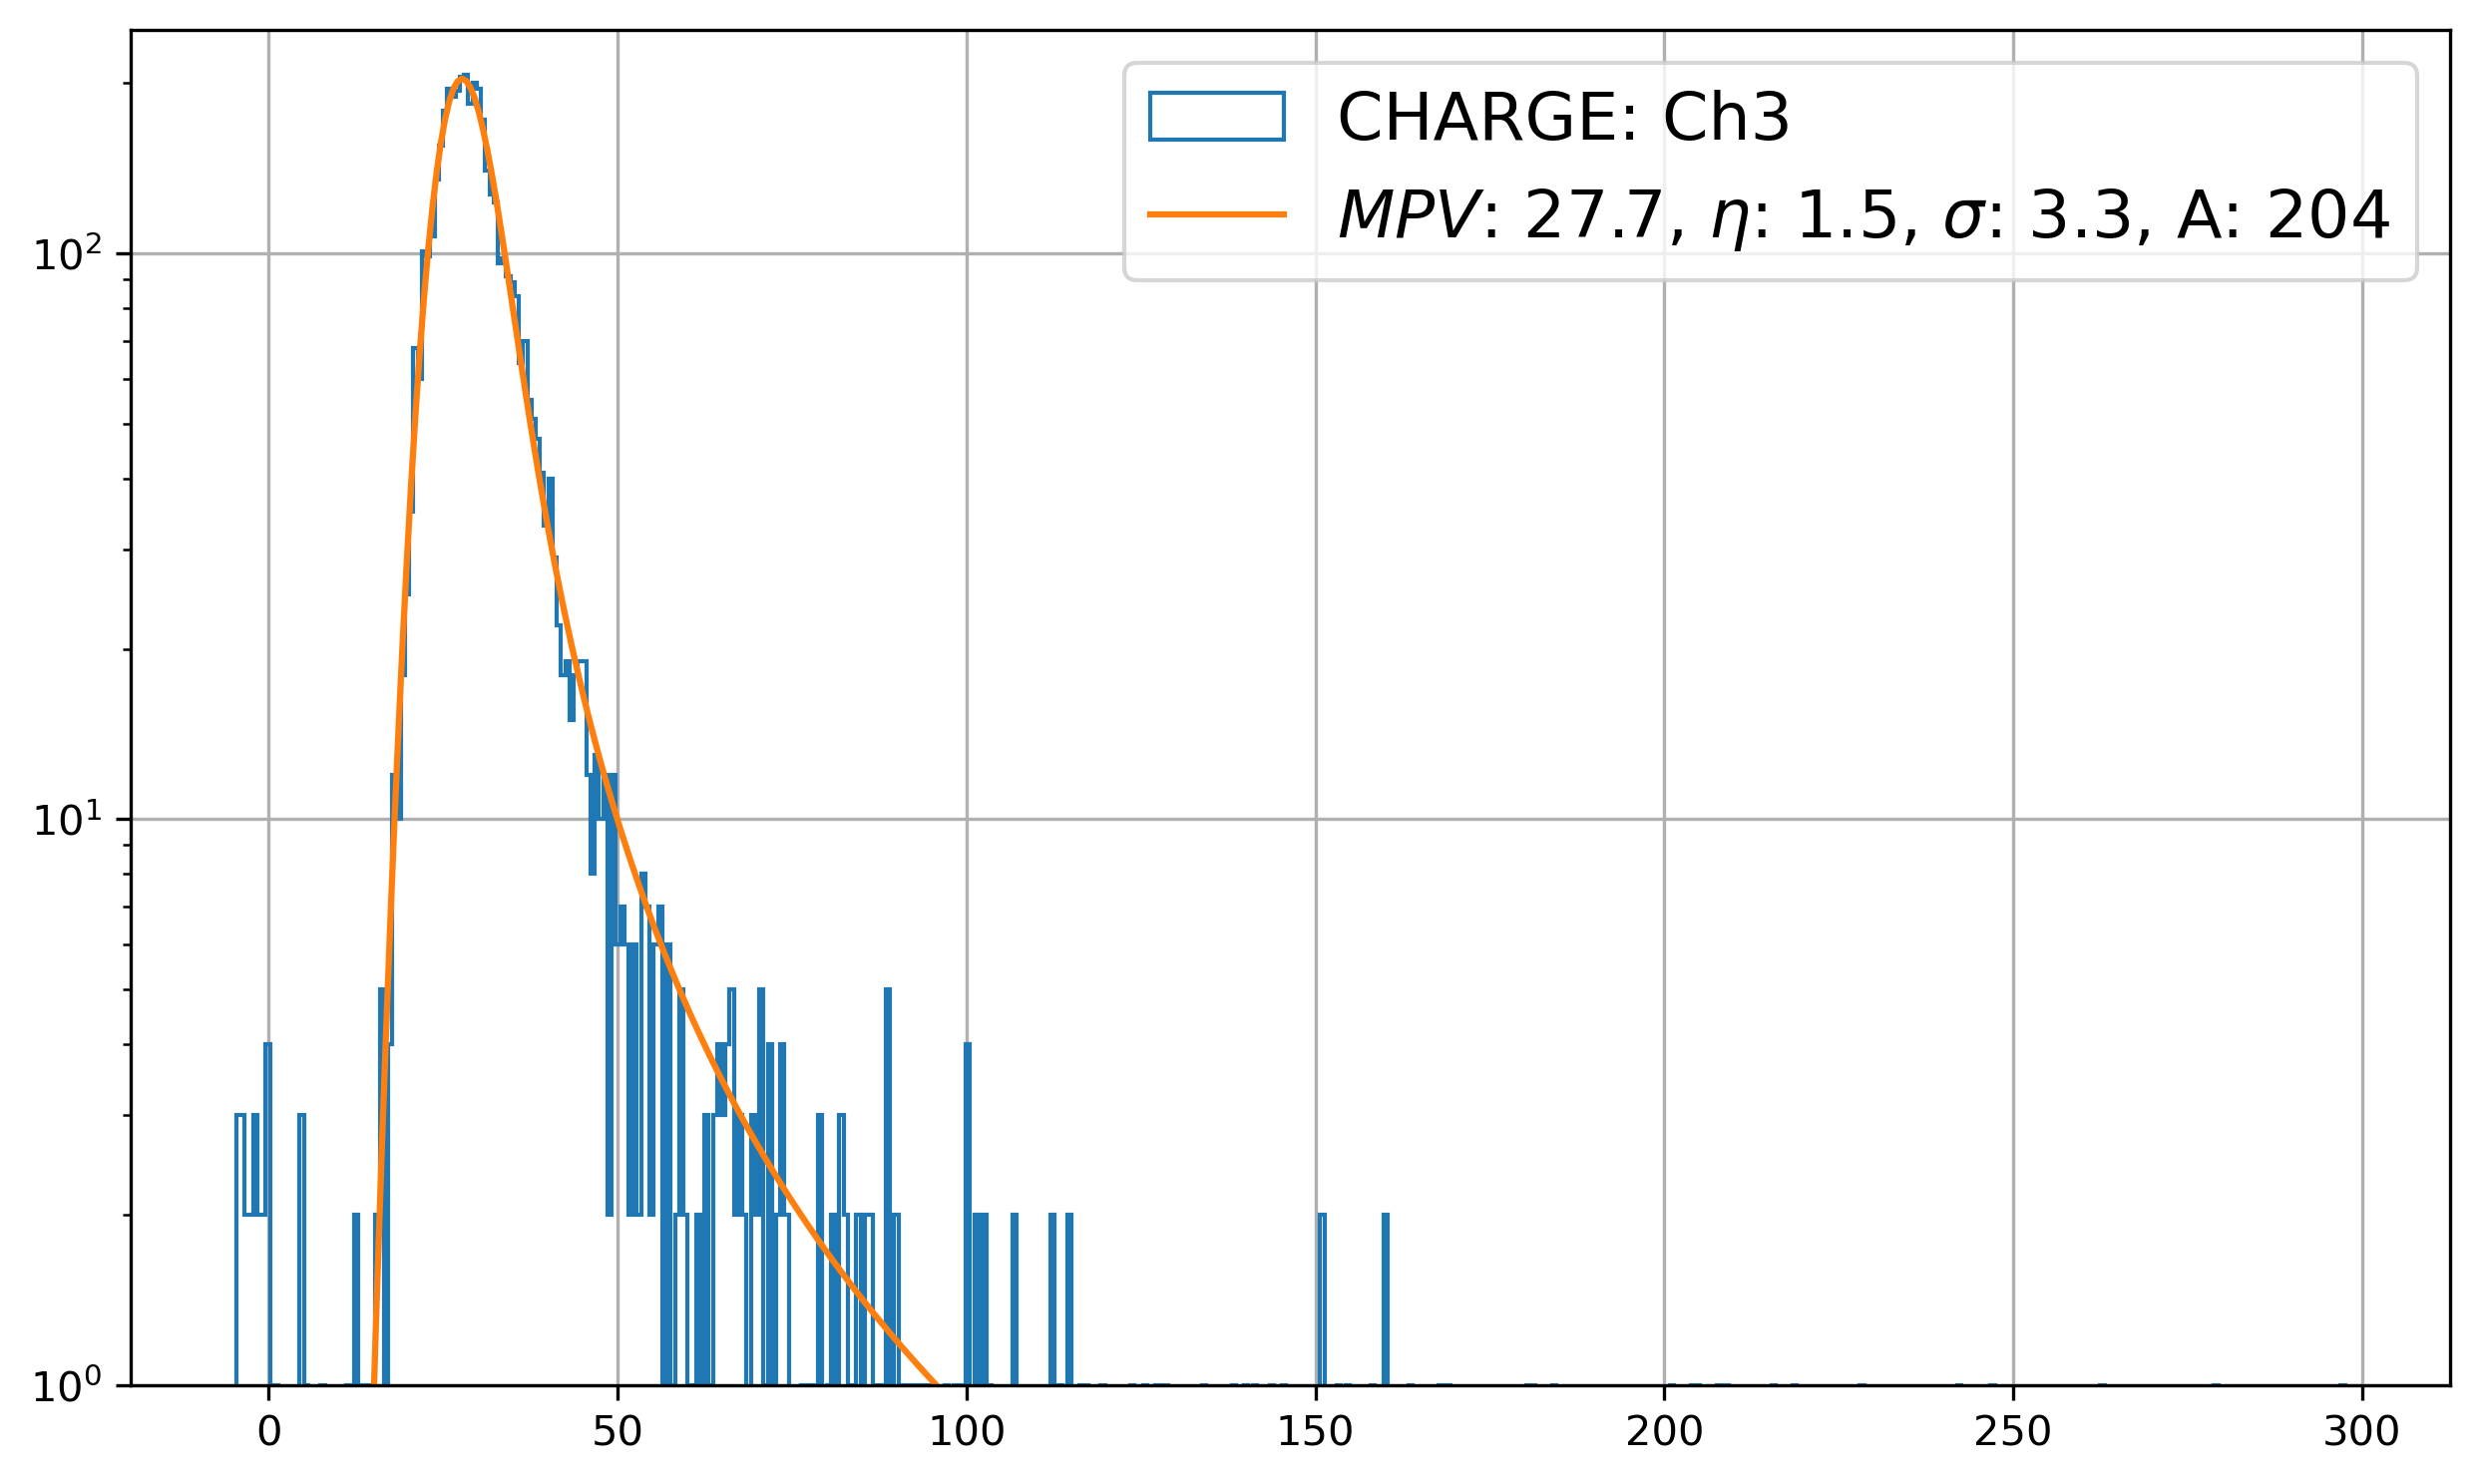

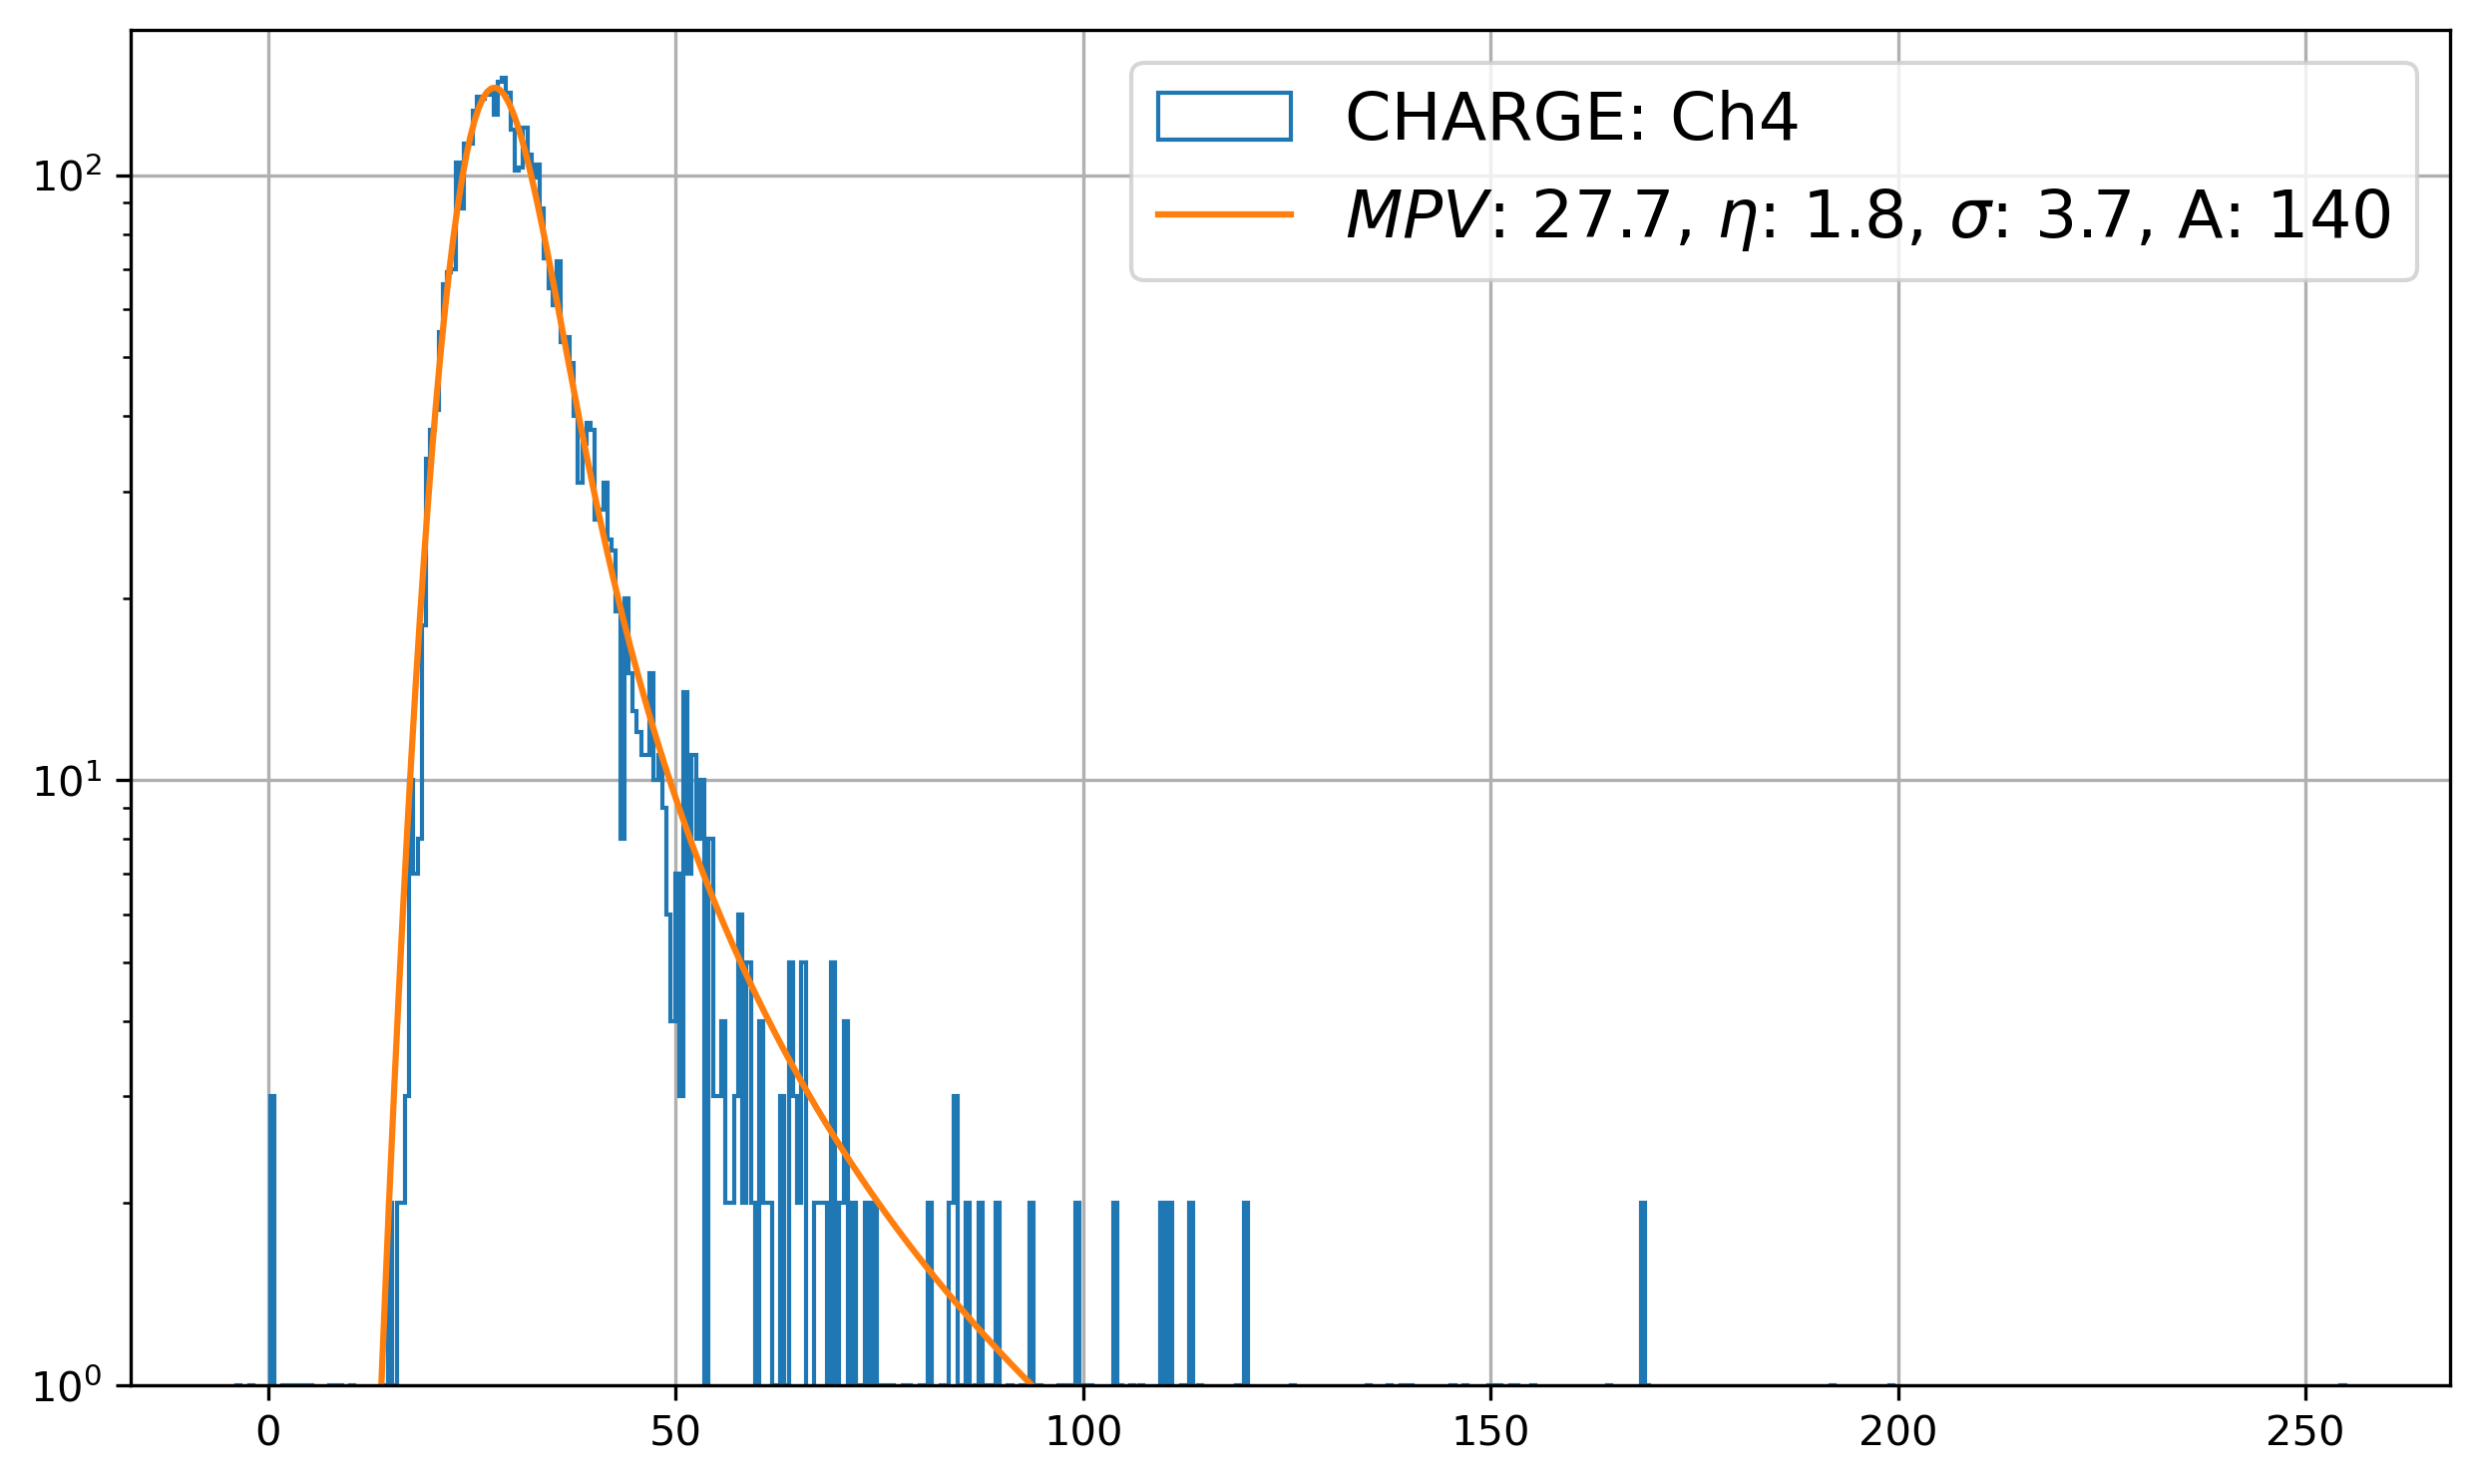

In [17]:
### TEST ON ONE RUN

these_bins = bins_dict[this_batch]
time_bins = 1500
threshold_charge = 4
use_for_geometry_cut = 'pulseheight'

run = 9761

quick_analysis(run, S_run, df_analysis, dict_of_batches, DUTs)

In [14]:
# df_analysis

[INFO] - 	 Run 9761 found in batch 413
[INFO] - 	 Loading run 9761 from tree009761.root
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.01722908e+03 -5.91392901e+03  4.33128361e+01  1.90399766e-02]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.12431297e+03 -5.94699203e+03  4.05604049e+01  2.20644593e-02]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.36411779e+03 -6.08640014e+03  3.15301033e+01  1.91879912e-02]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.07720134e+02 -5.91417294e+03  3.94985630e+01  1.53069394e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.11209429e+02 -5.94728564e+03  3.68640778e+01  1.77335512e+00]
[INFO] - 	 in 'time_mask()': Fit parameters [ 1.02999227e+02 -6.08635836e+03  2.72632323e+01  2.64502364e+00]
[INFO] - 	 First charge estimate: 27.205333709716797
[INFO] - 	 First charge estimate: 28.326488494873047
[INFO] - 	 First charge estimate: 28.935253143310547
[INFO] - 	 Run 9762 found in batch 413
[INFO] - 	 Loading run 9762 from tree009762.root
[INFO

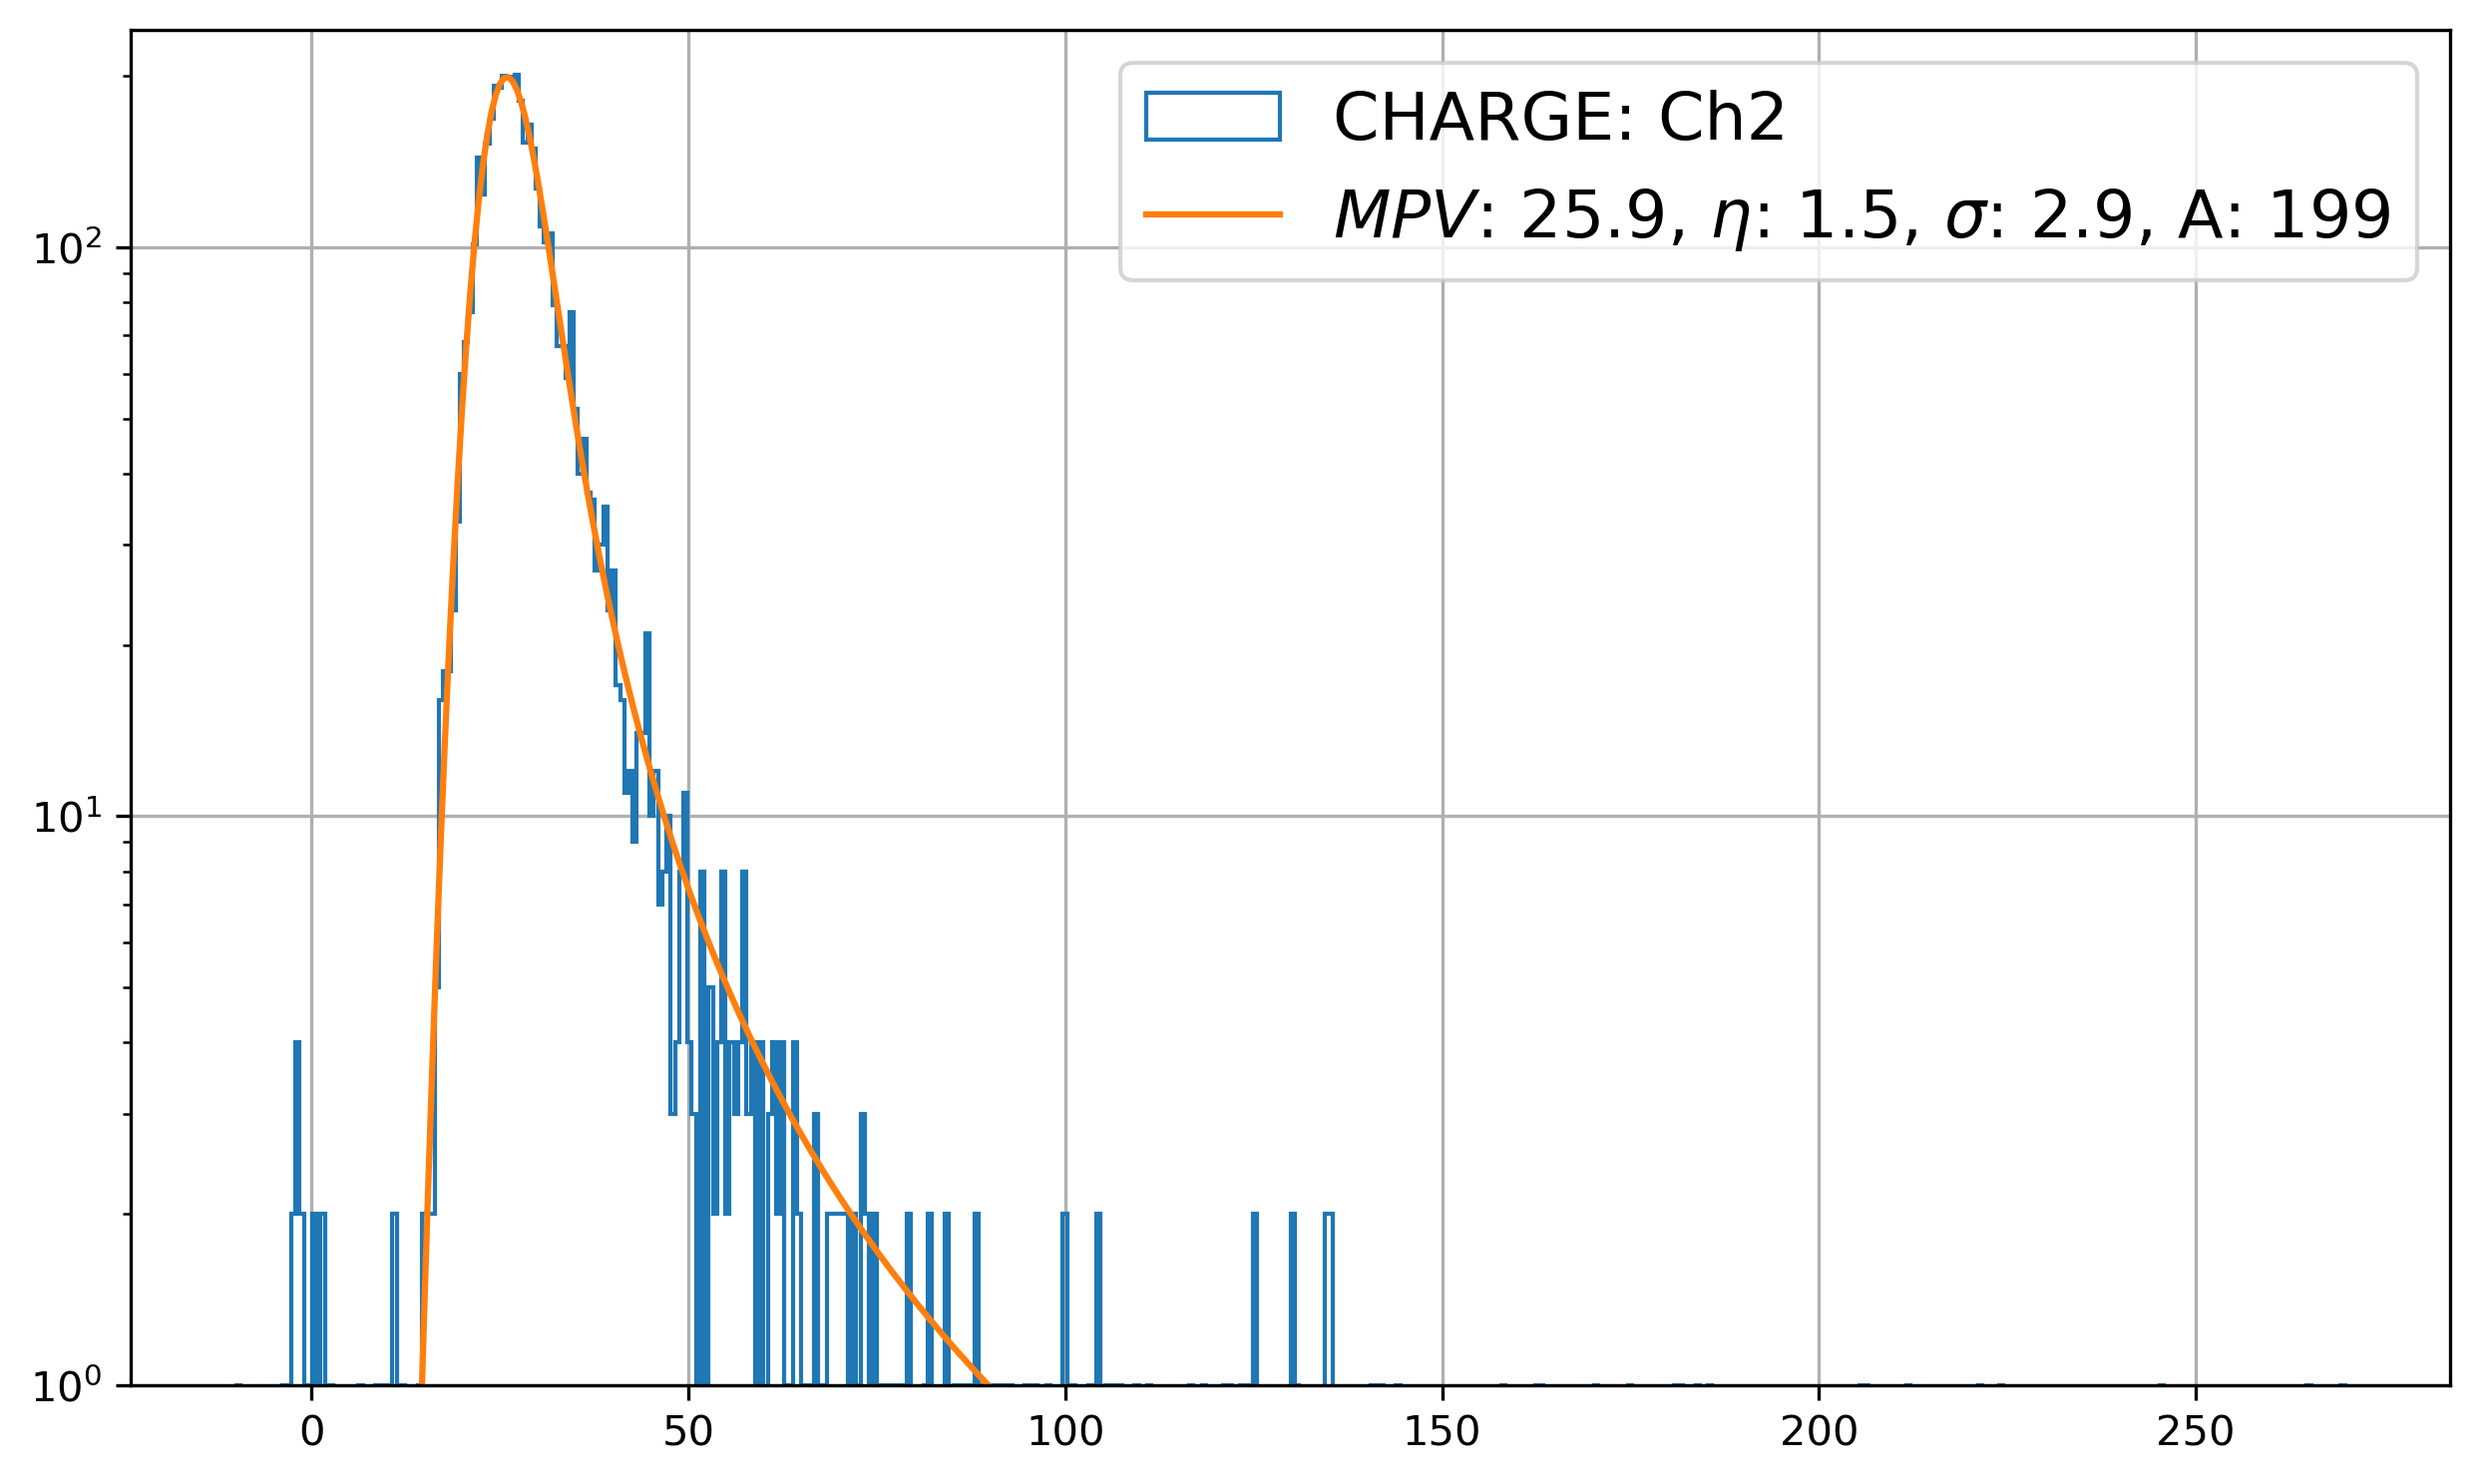

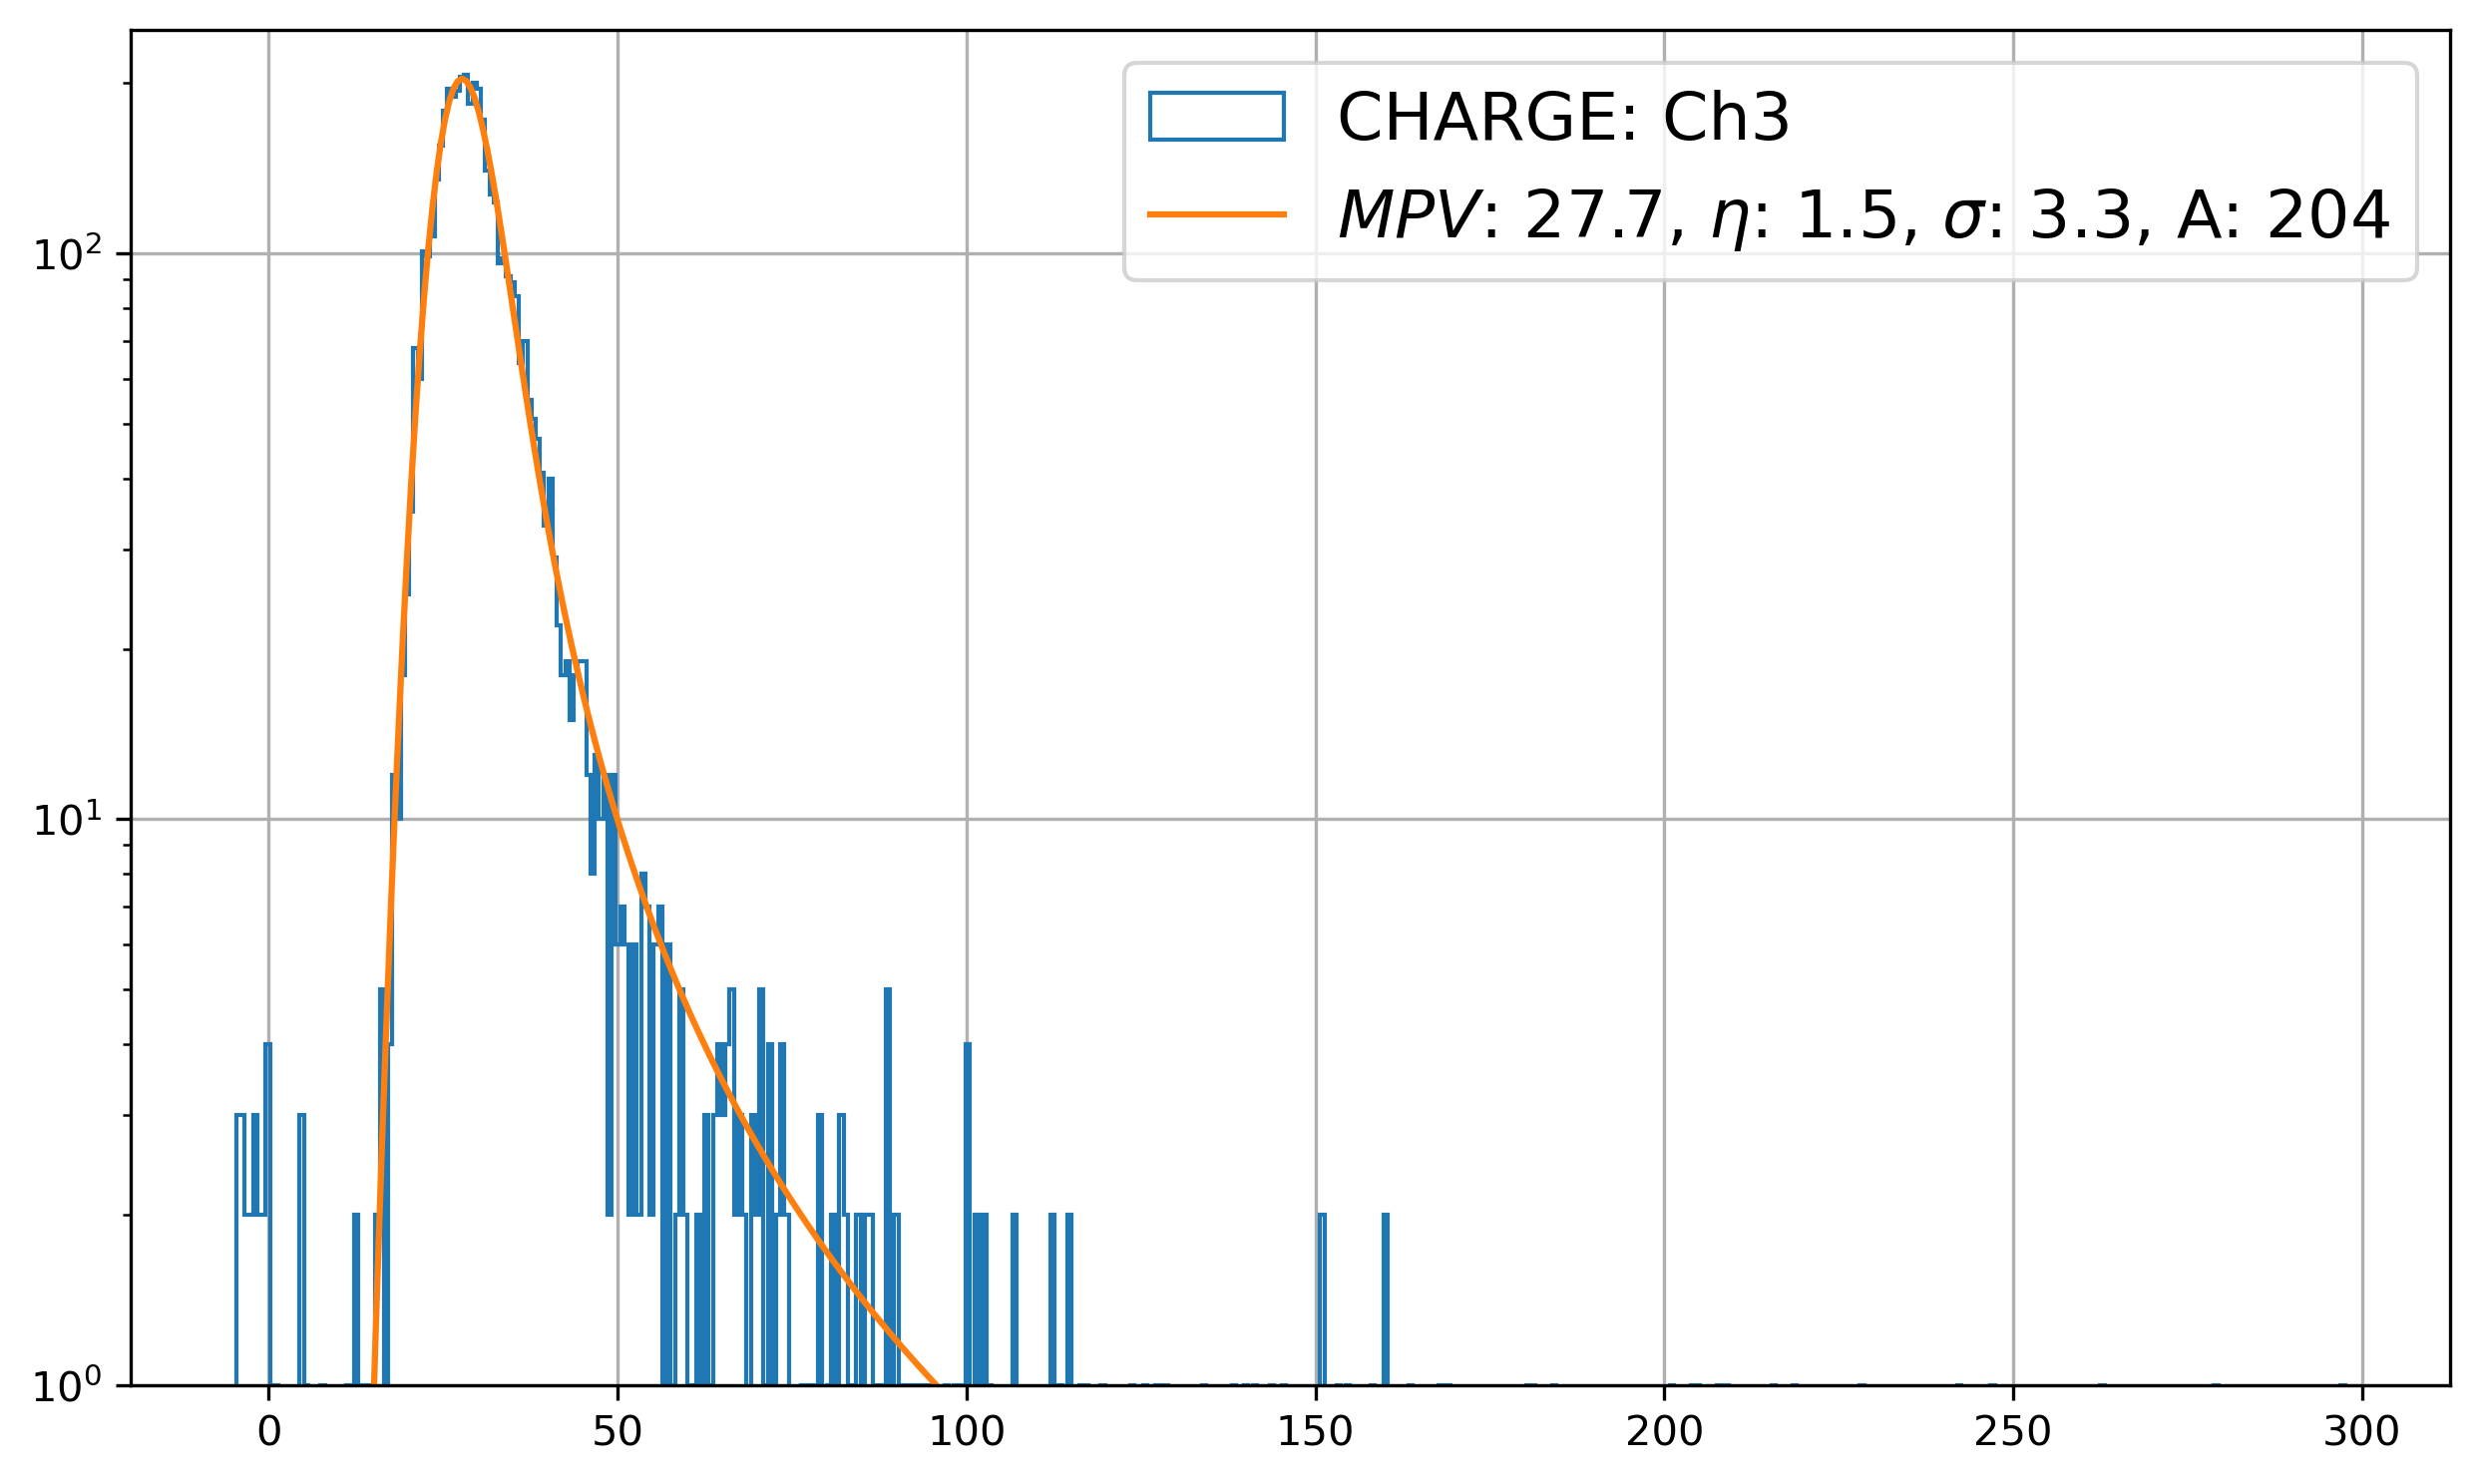

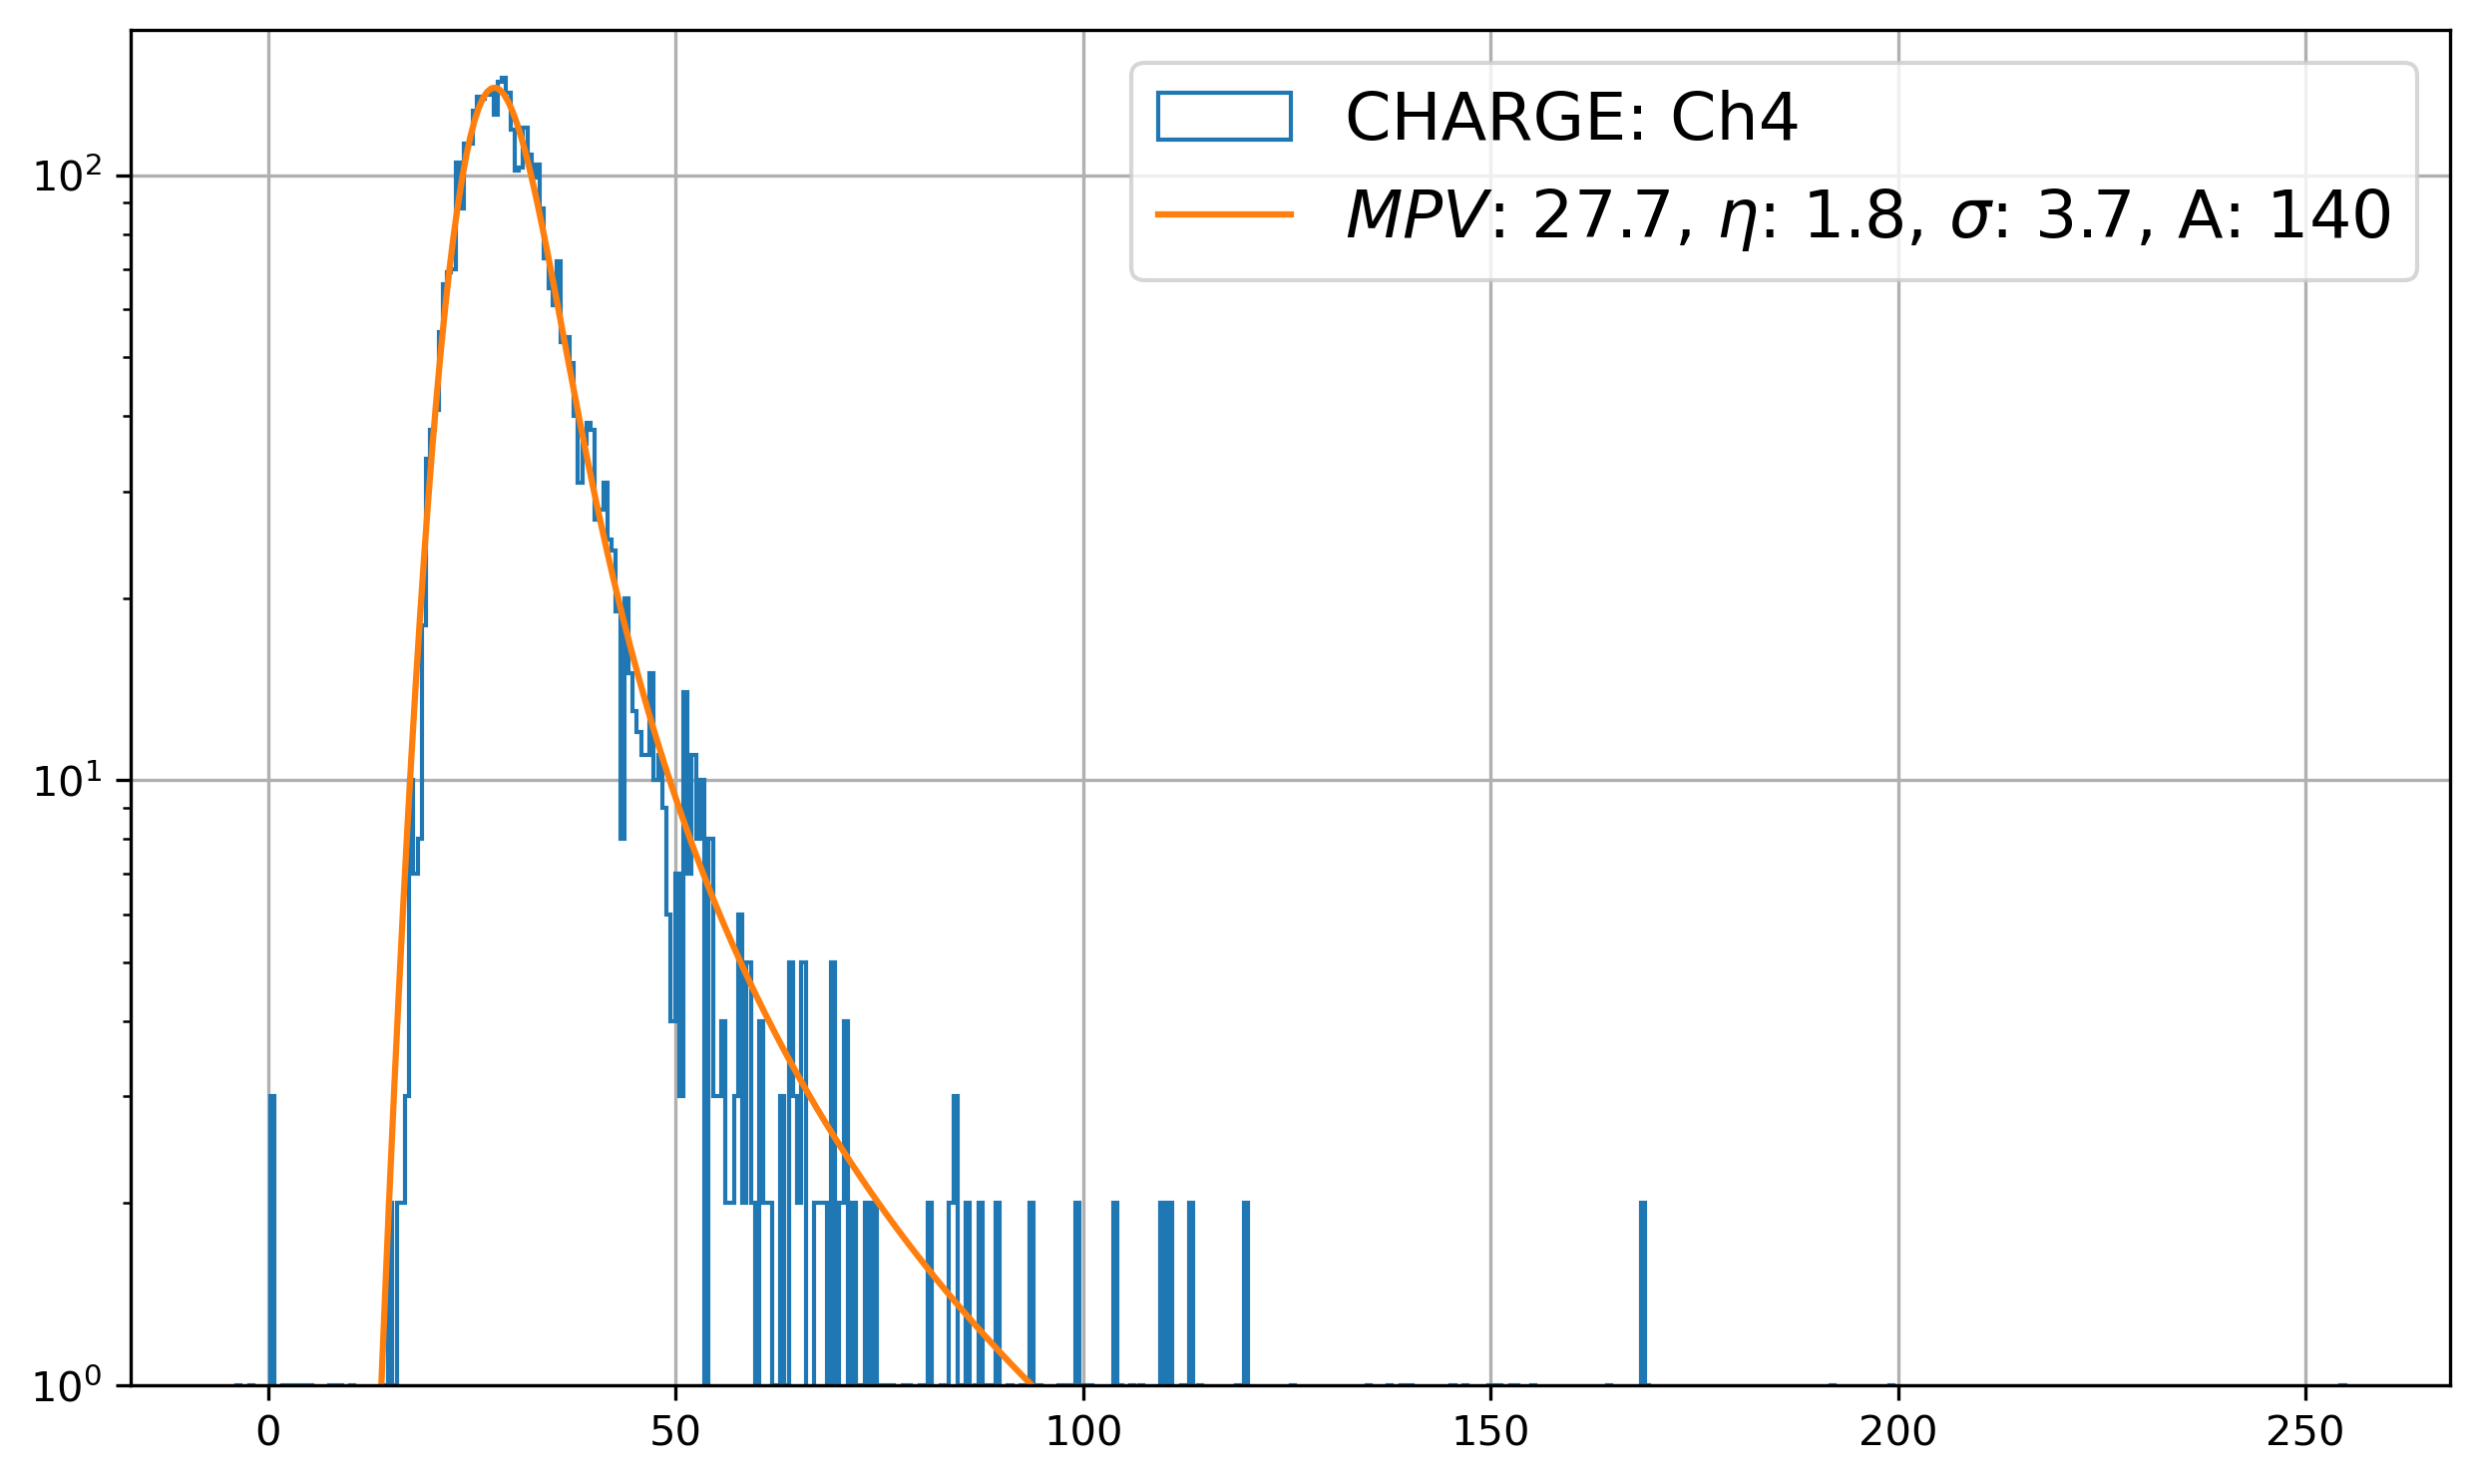

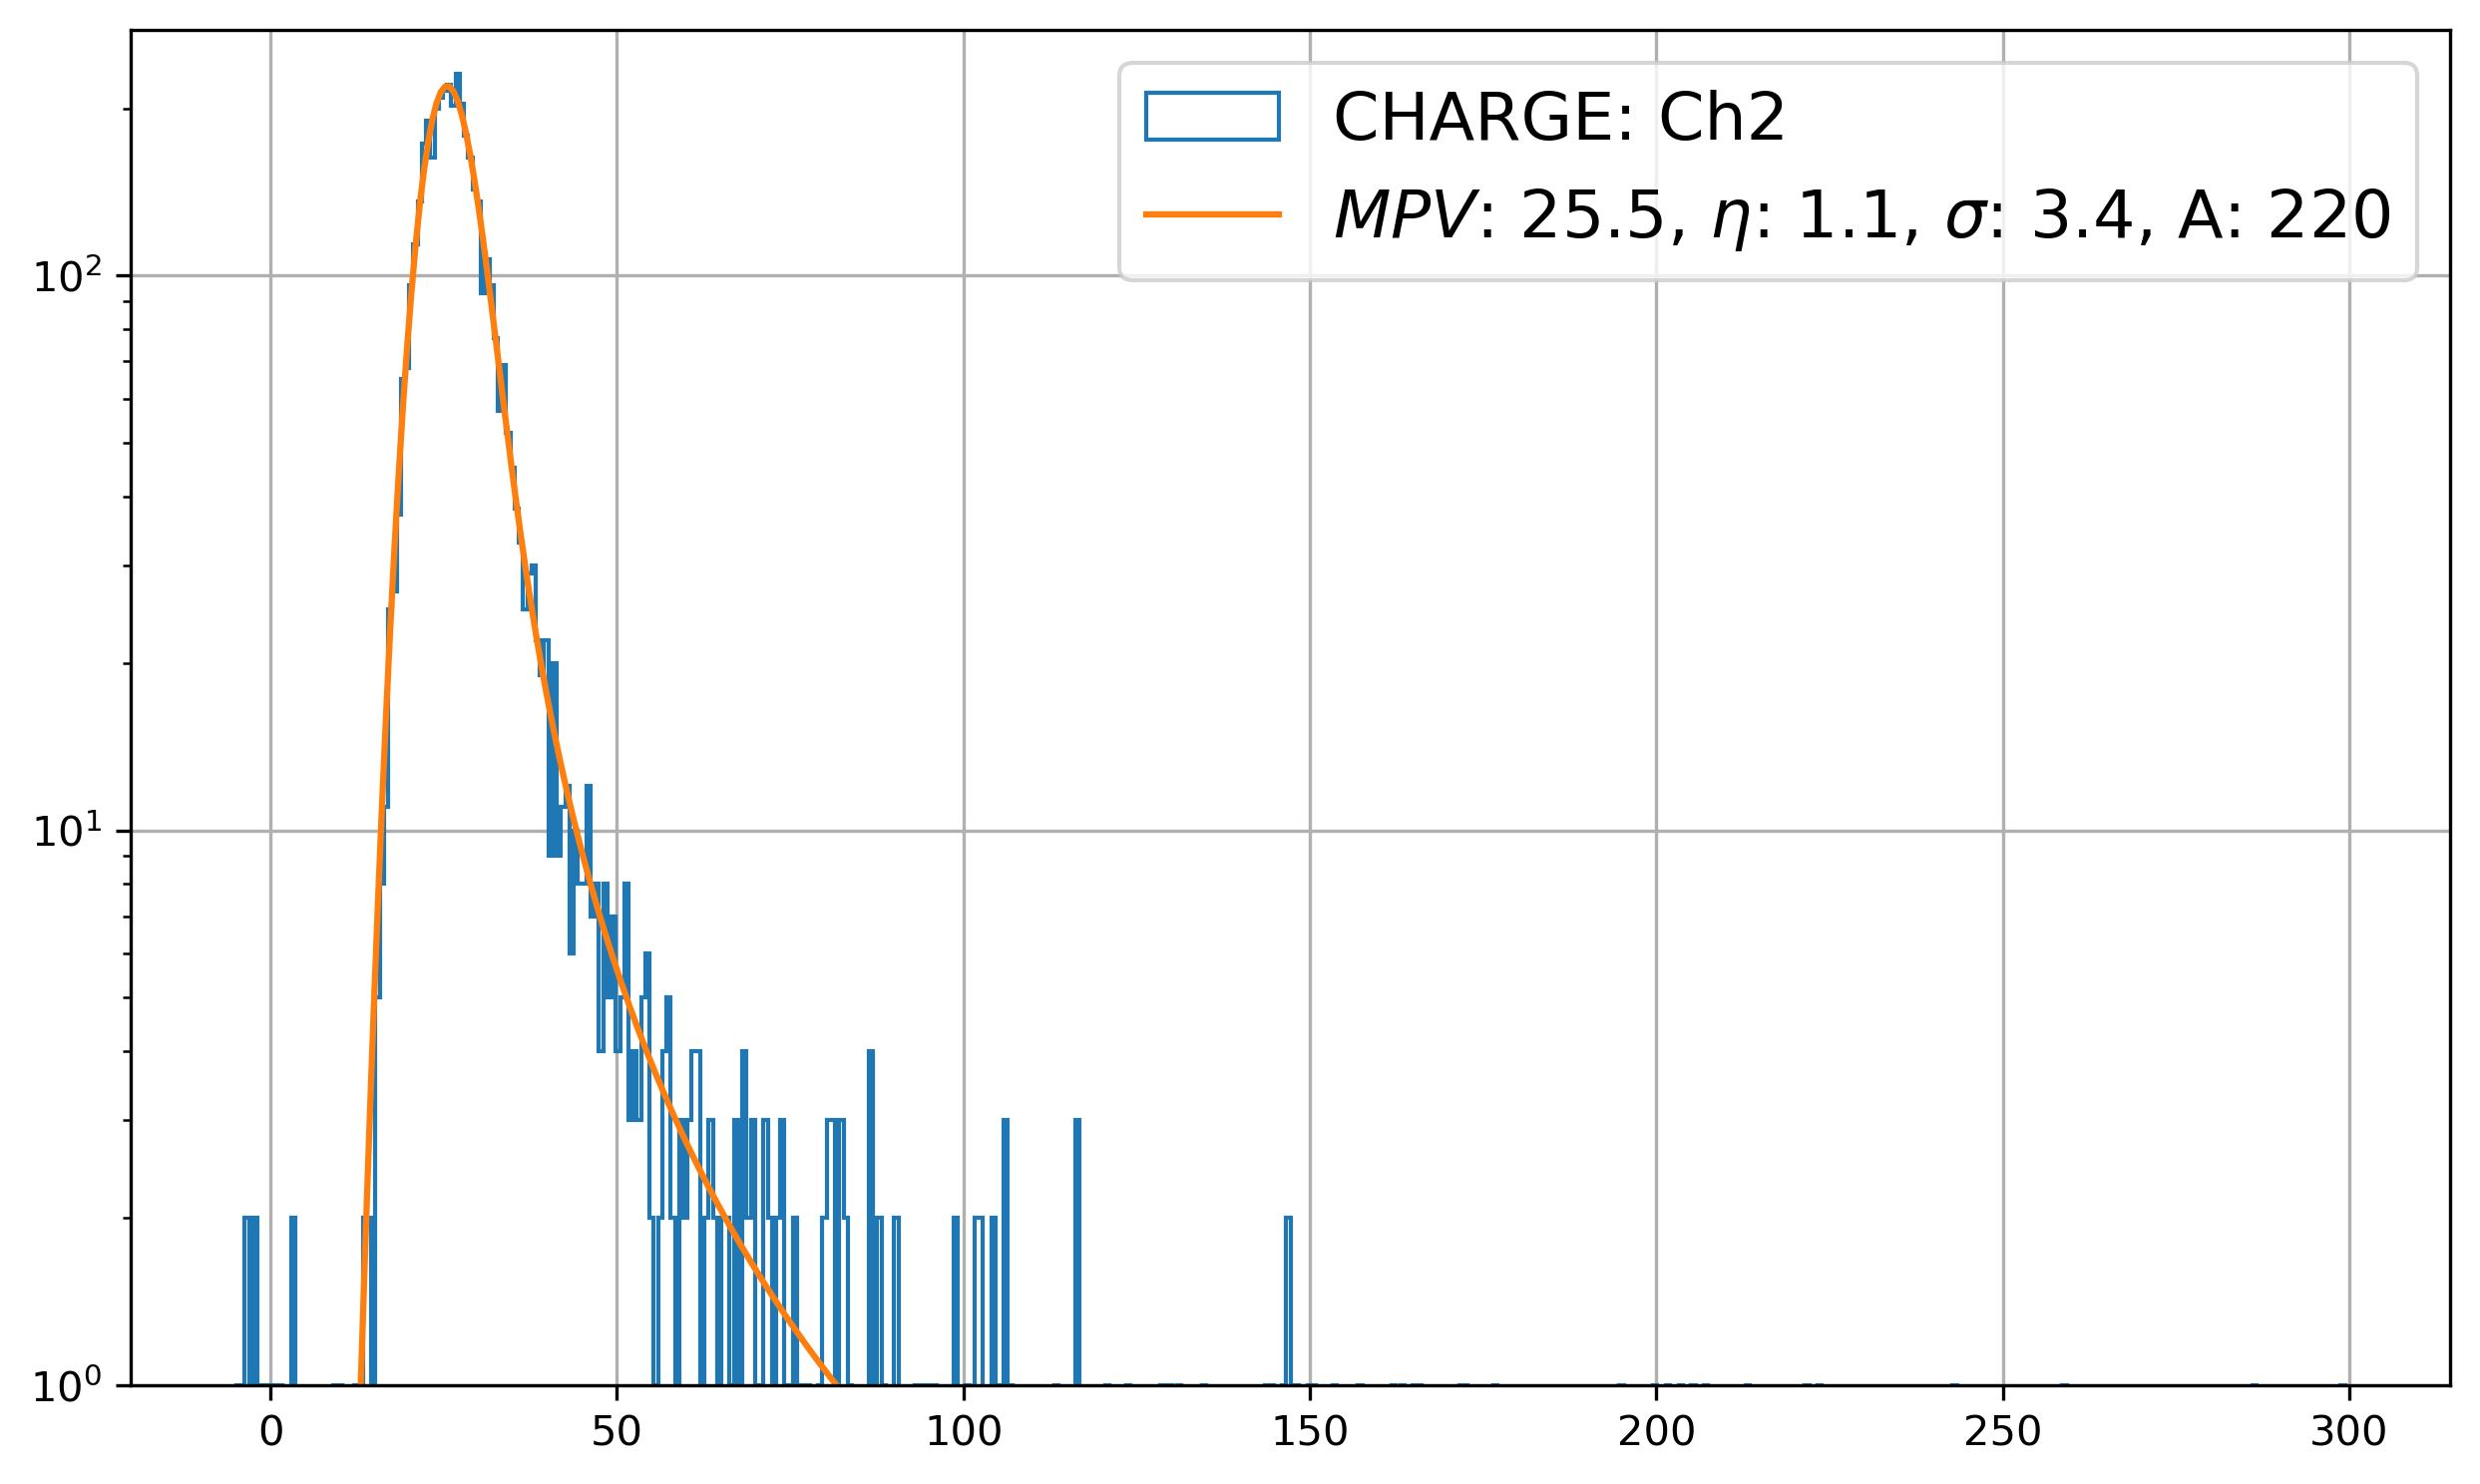

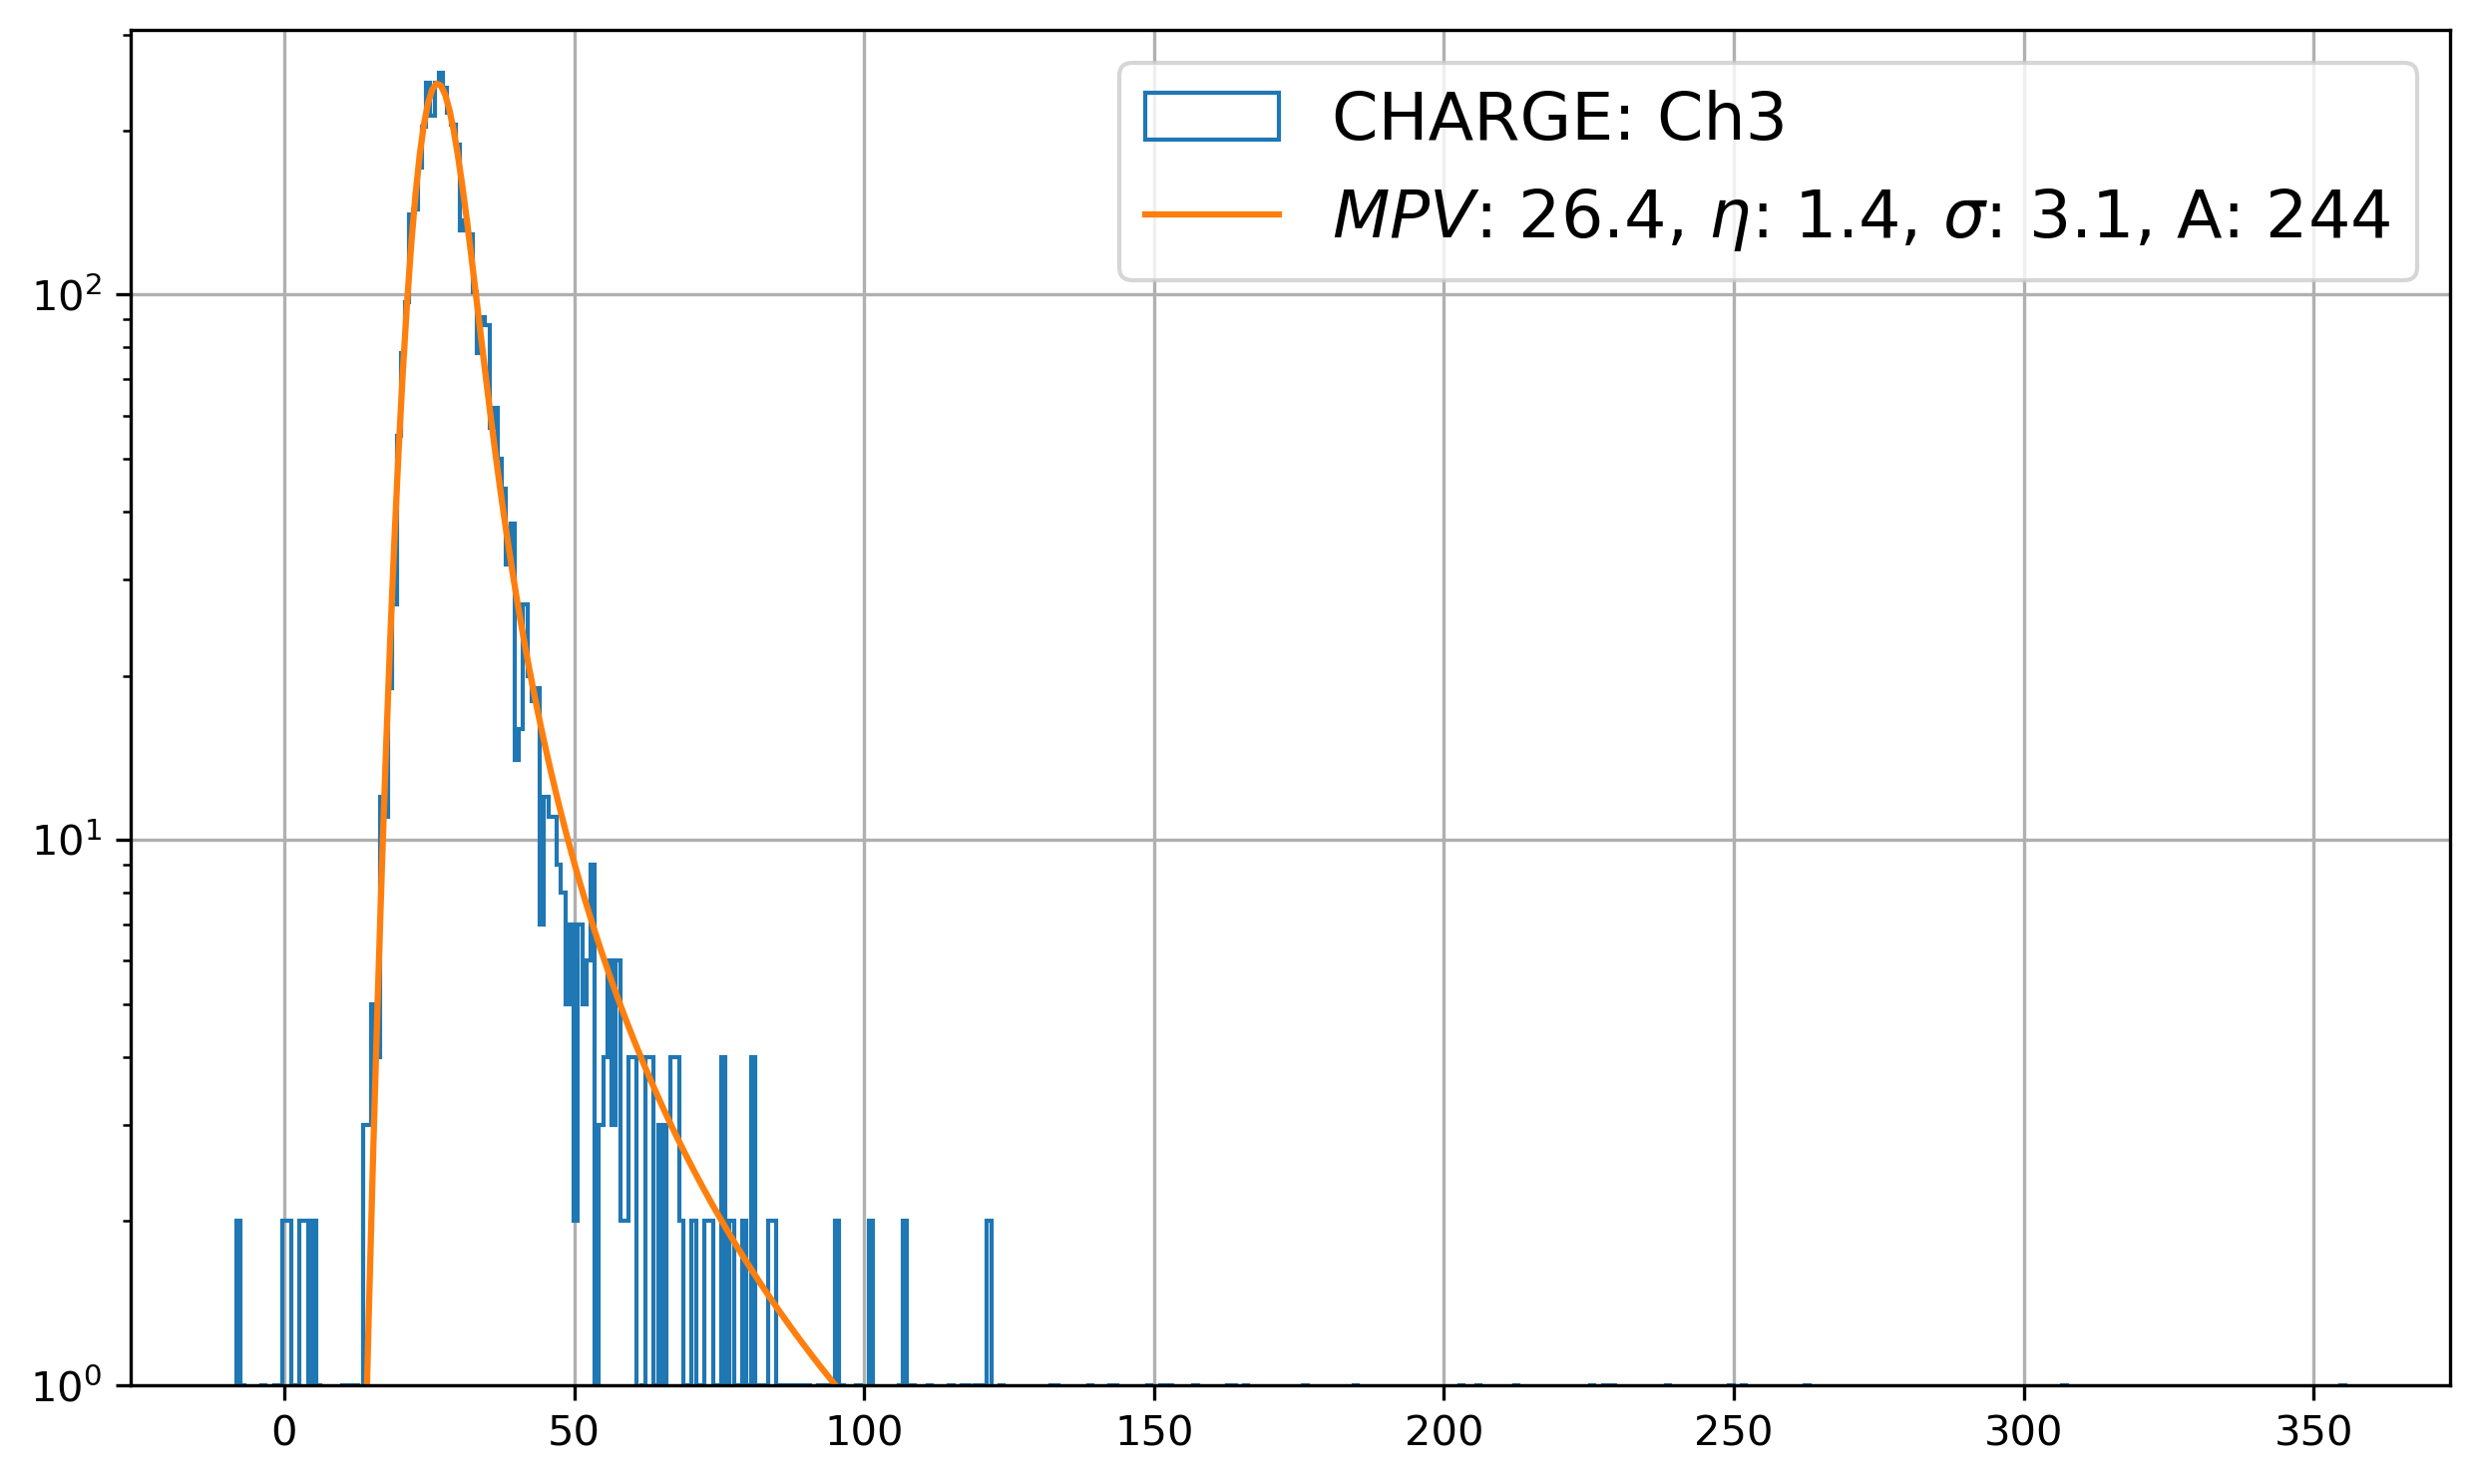

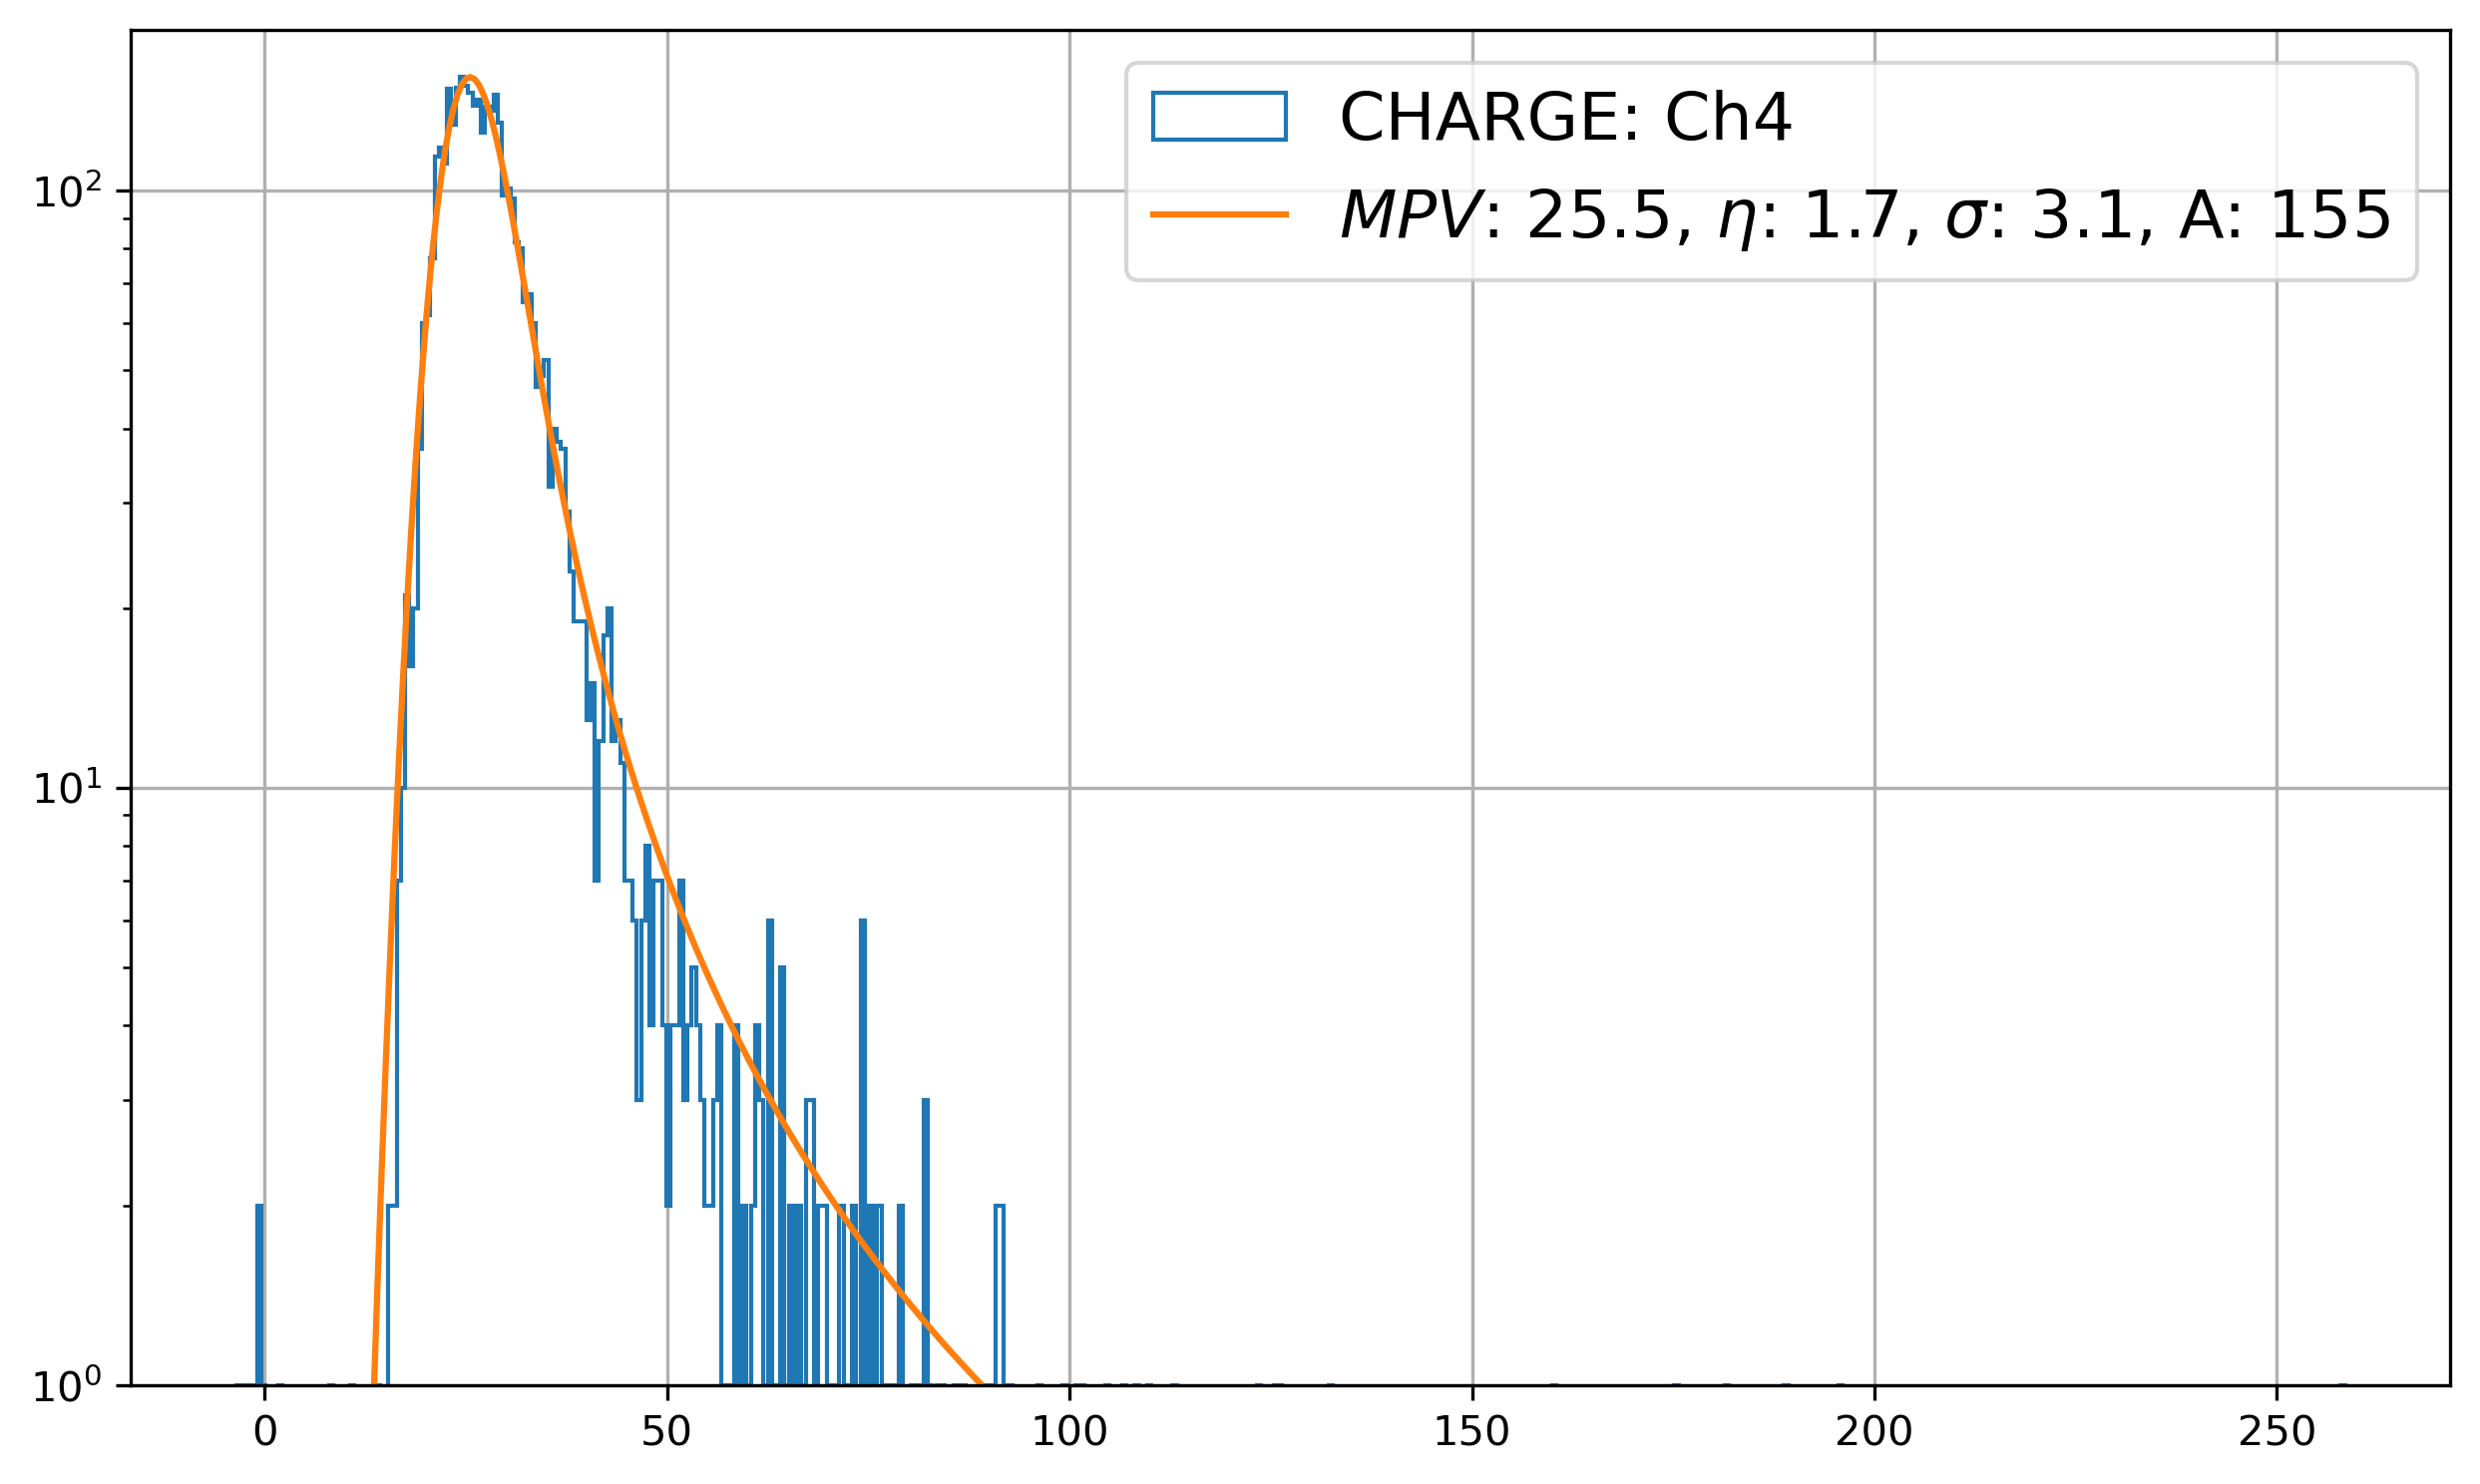

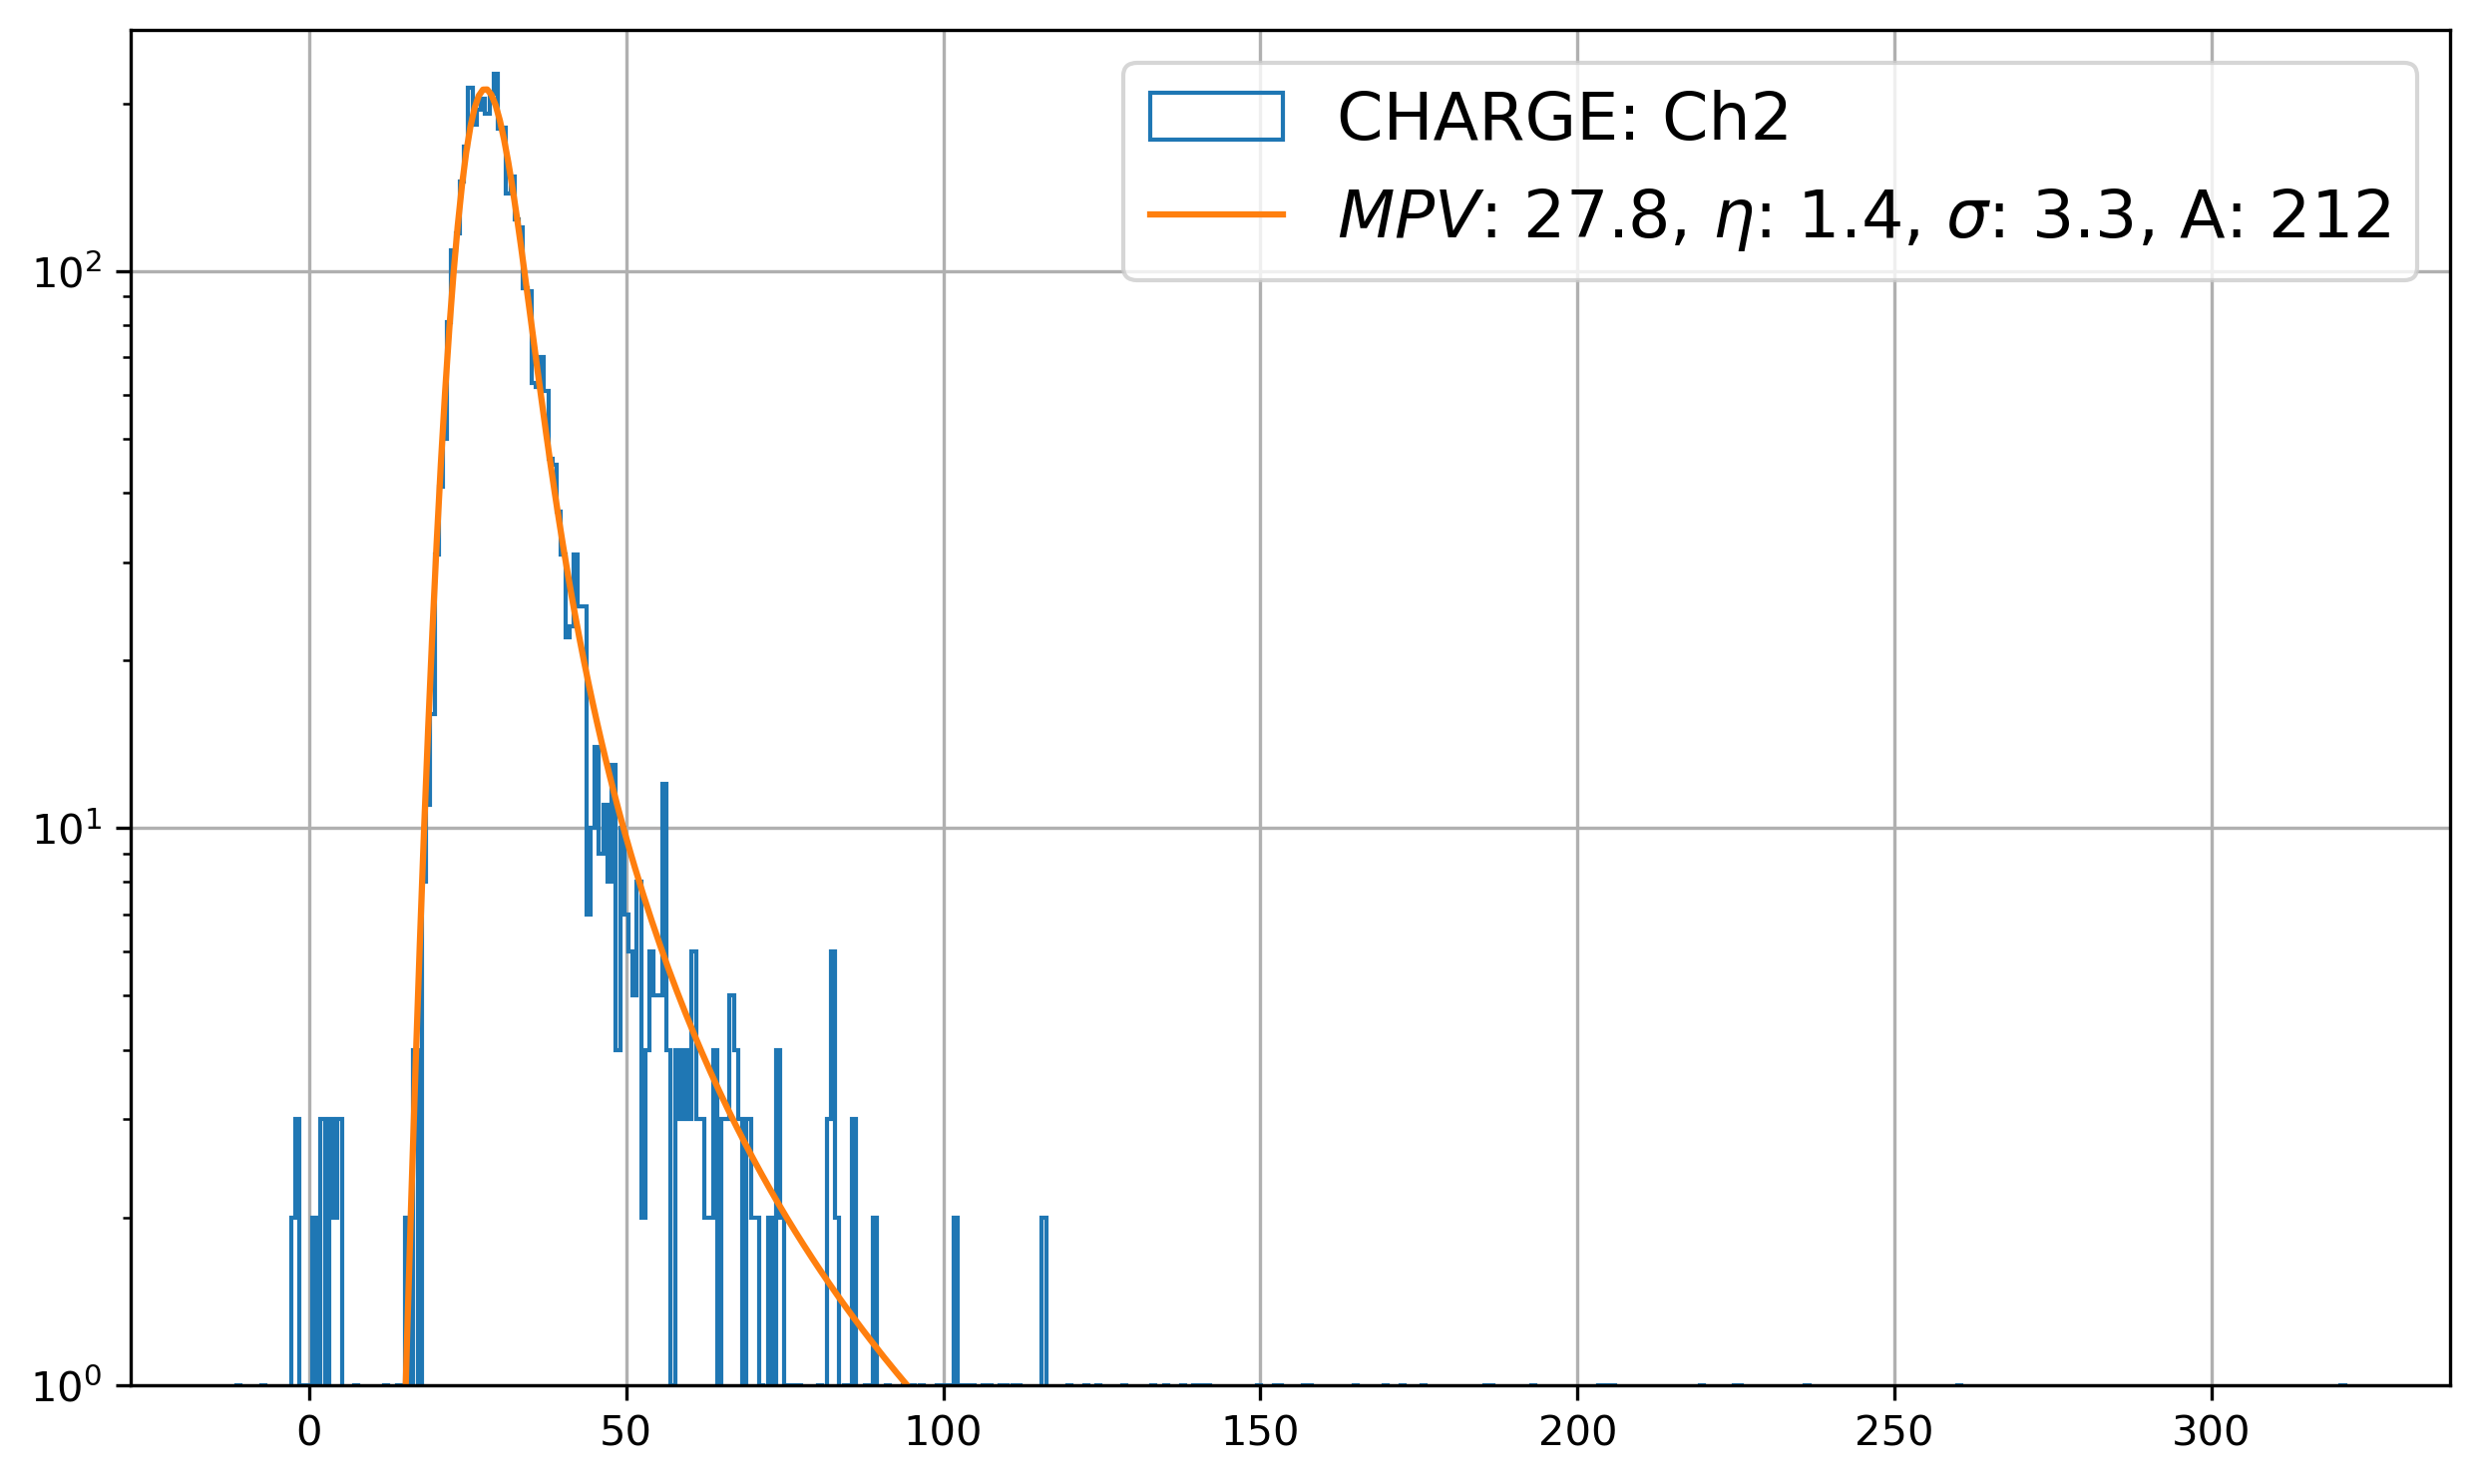

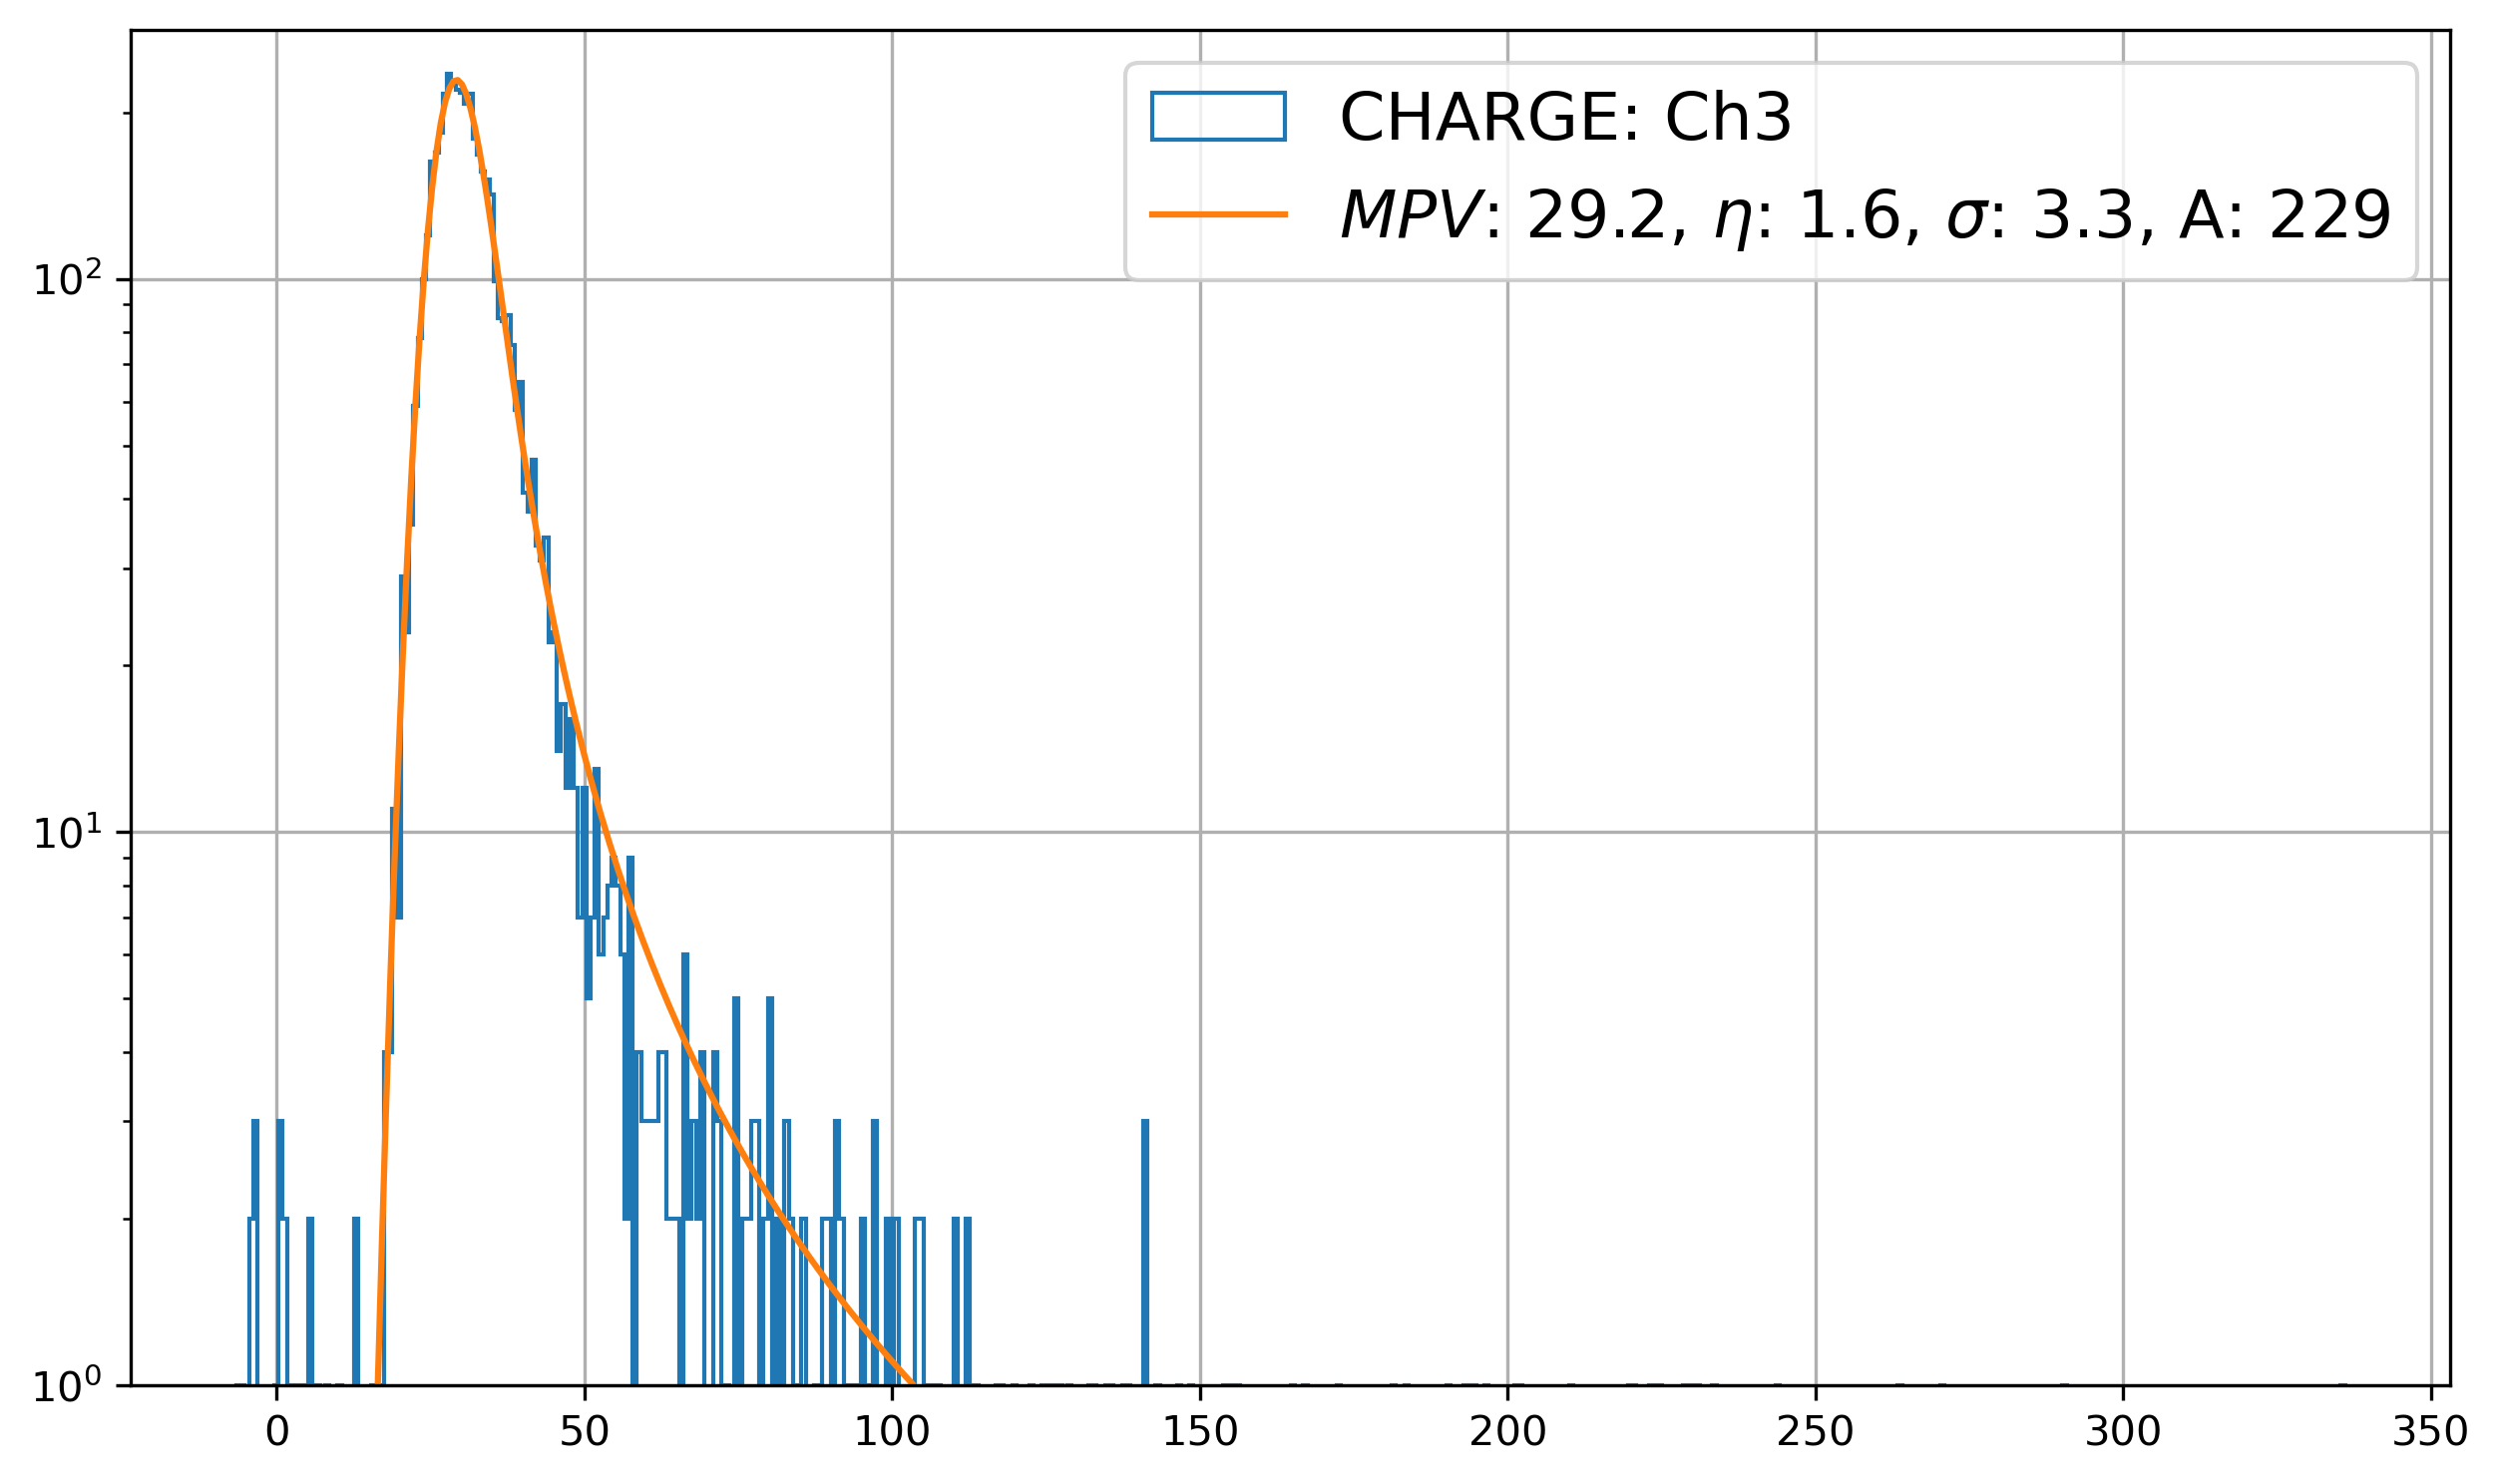

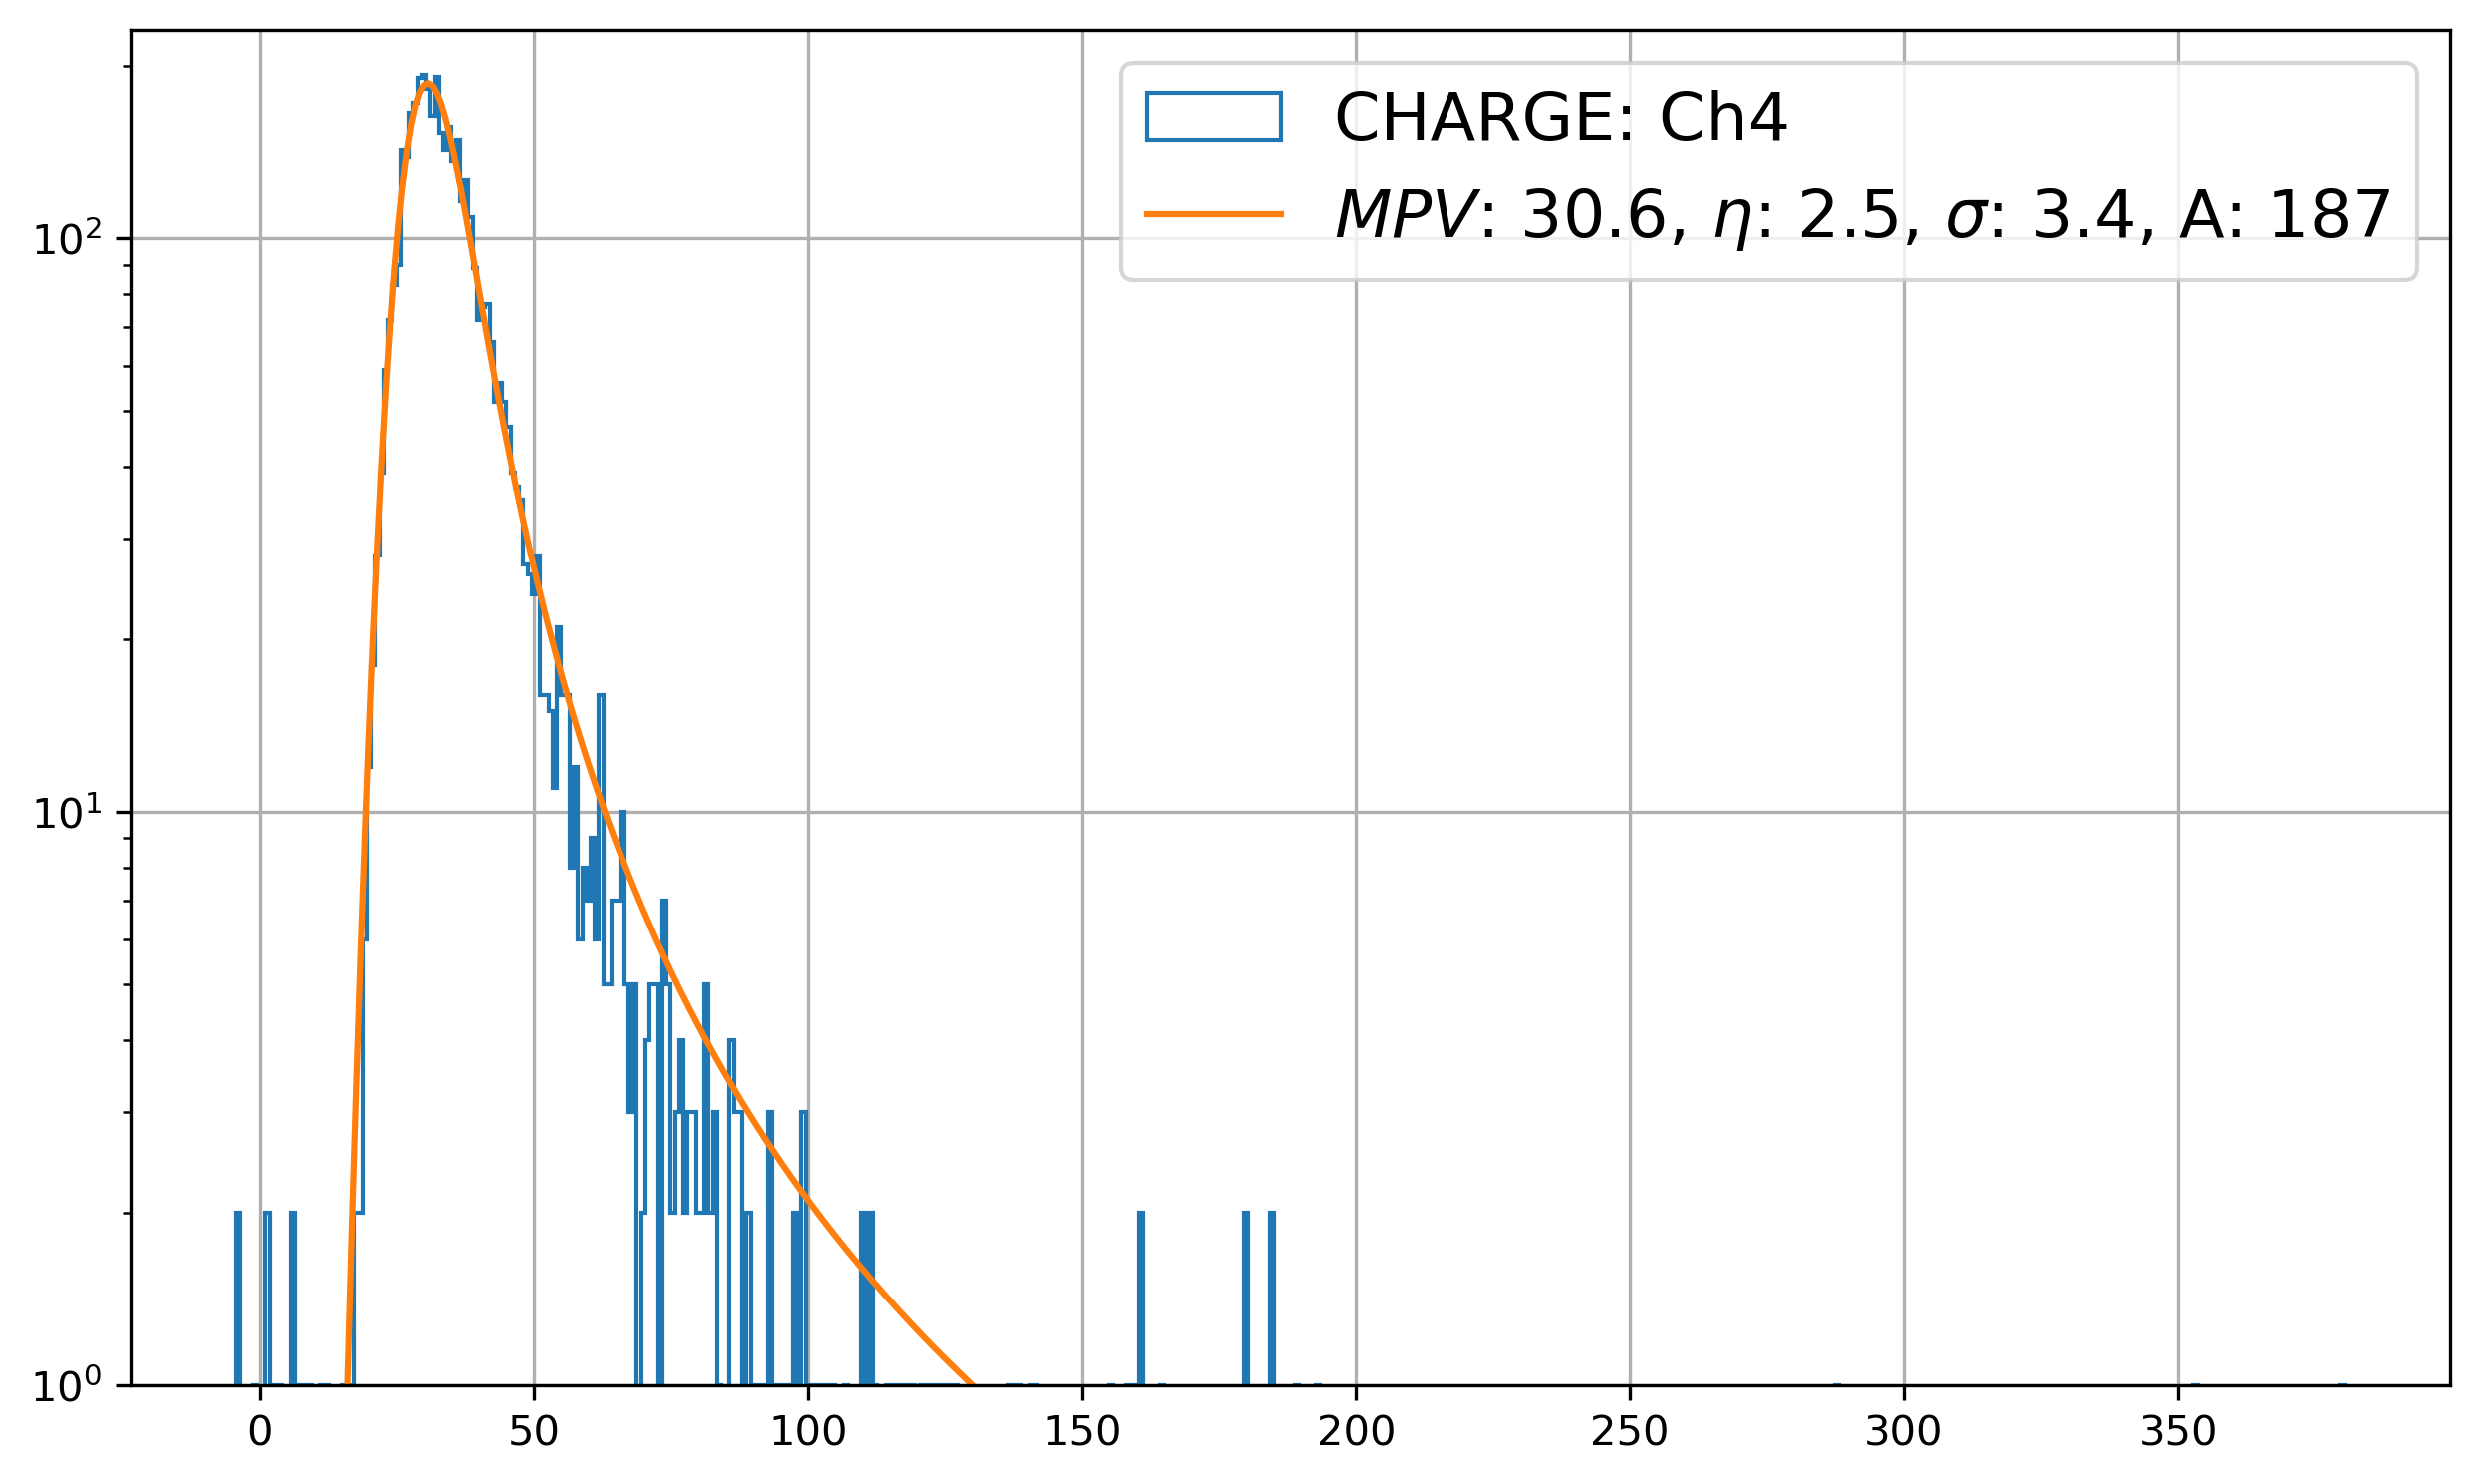

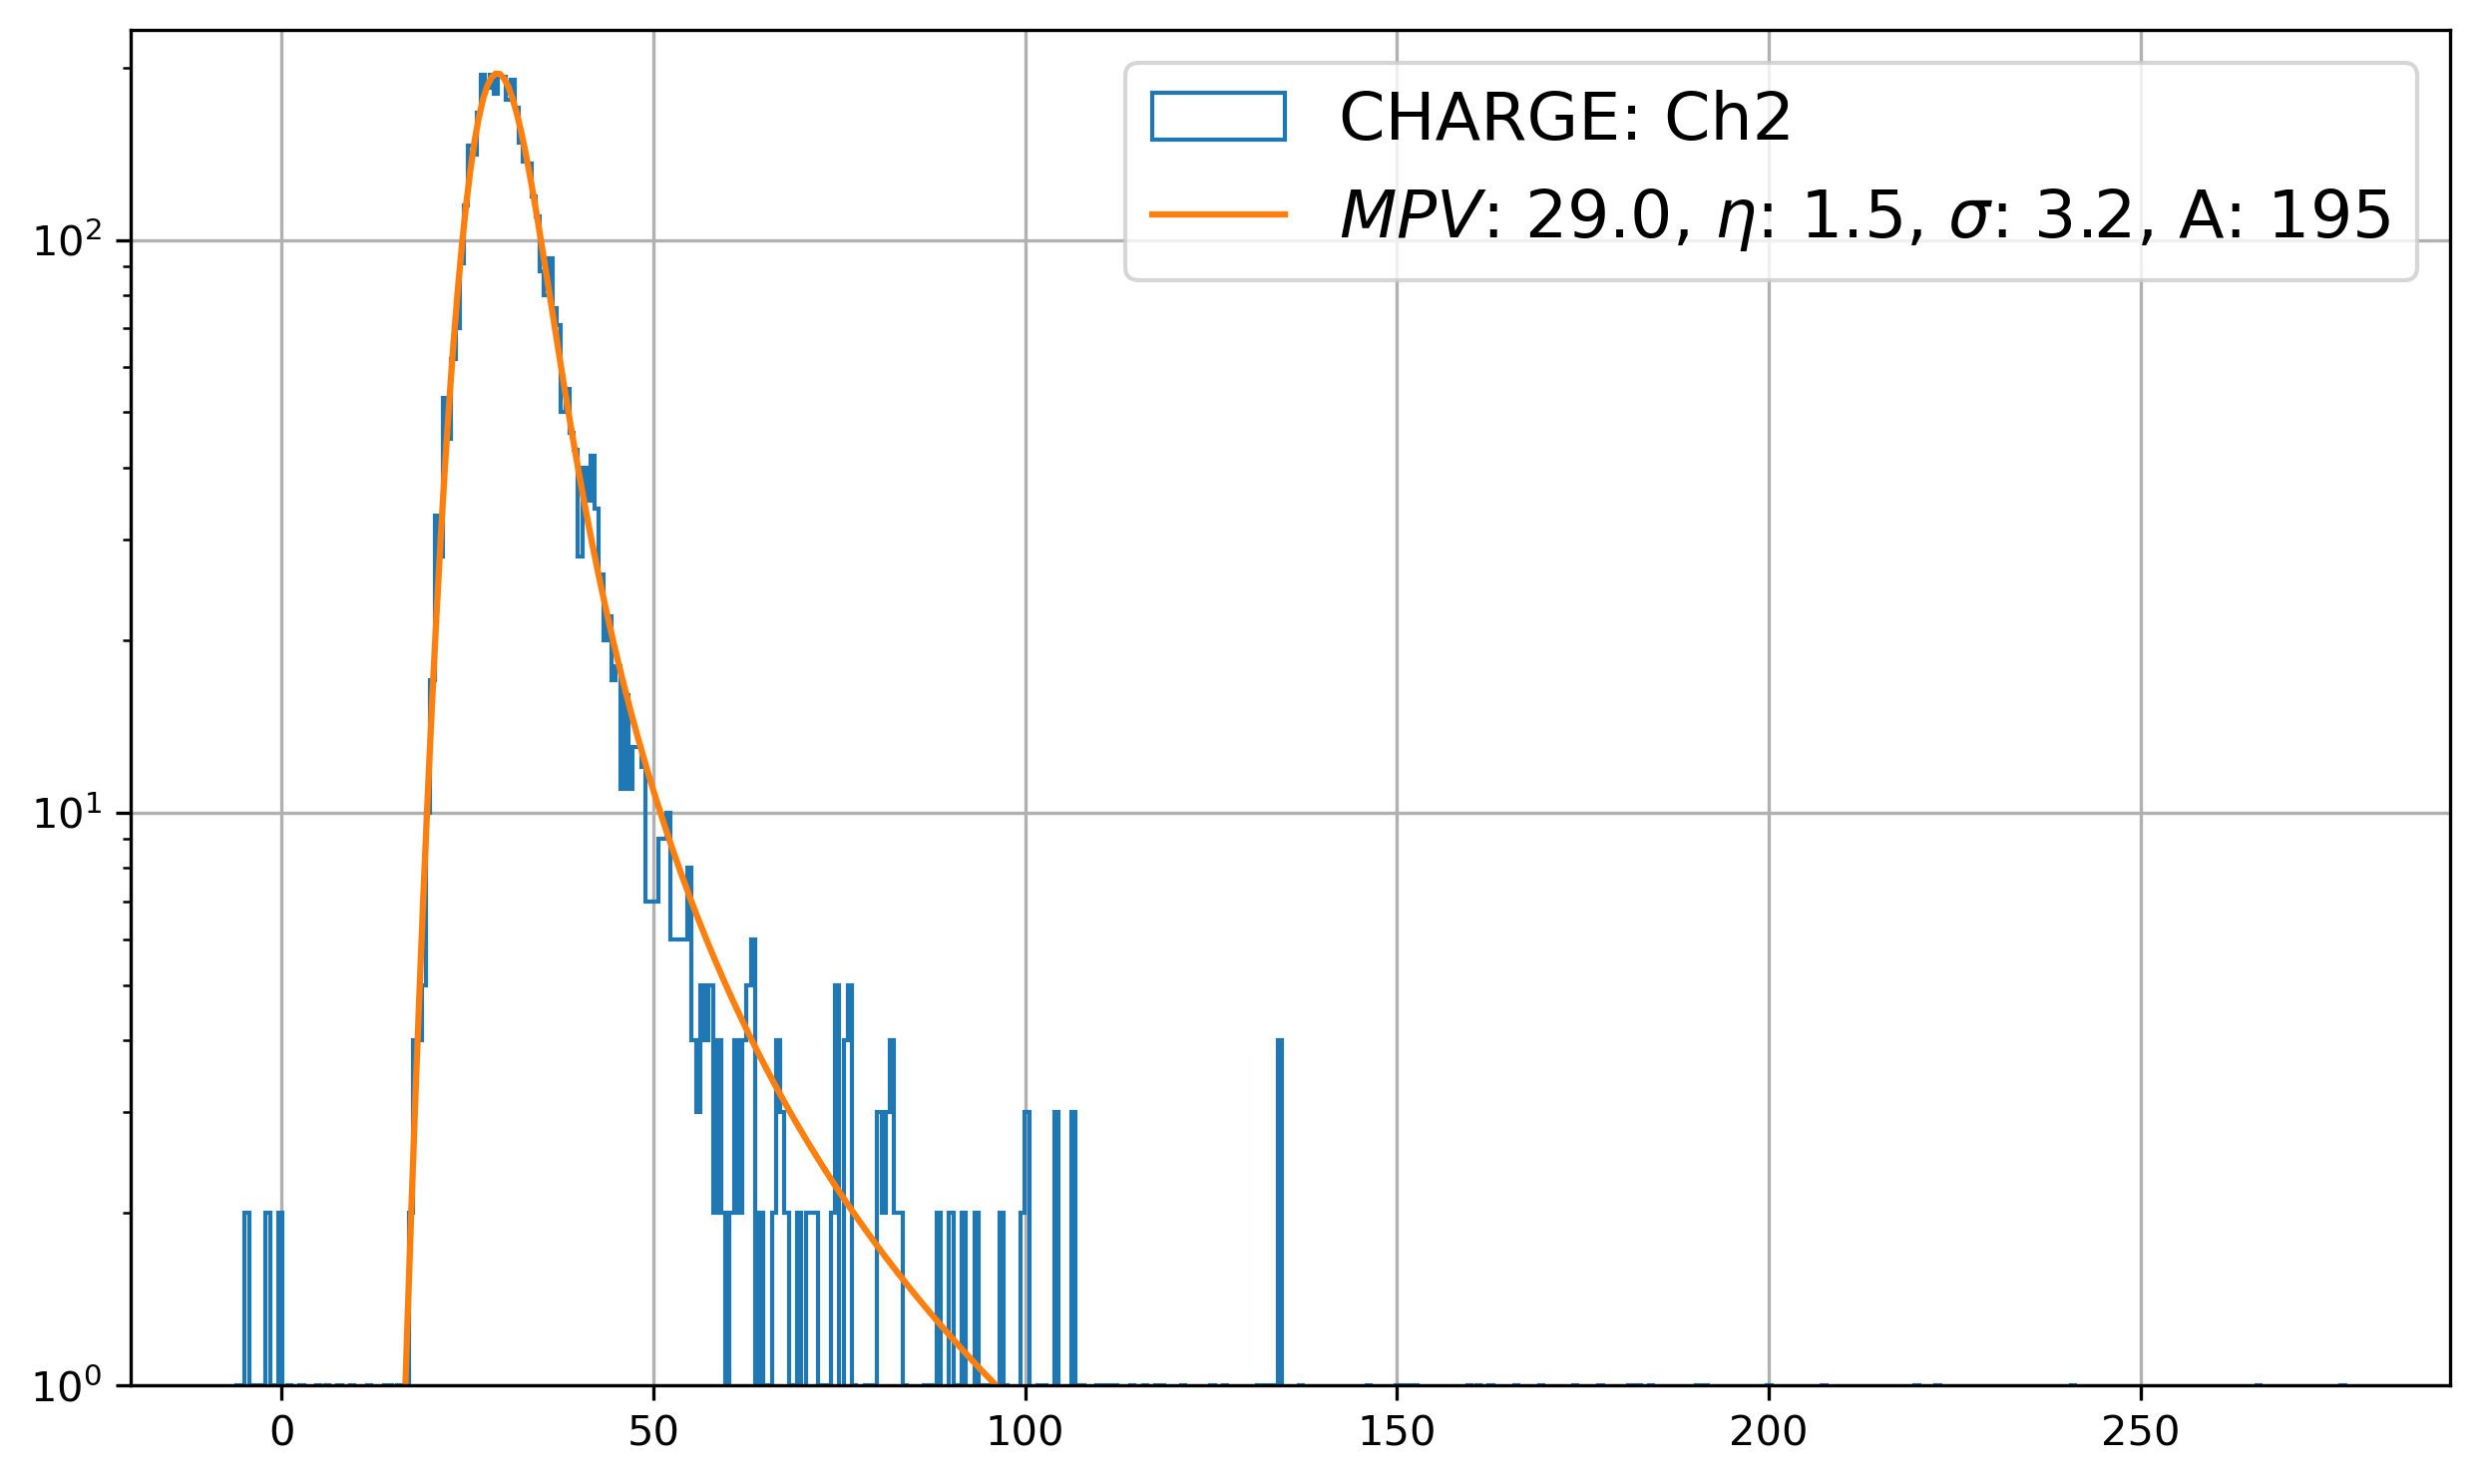

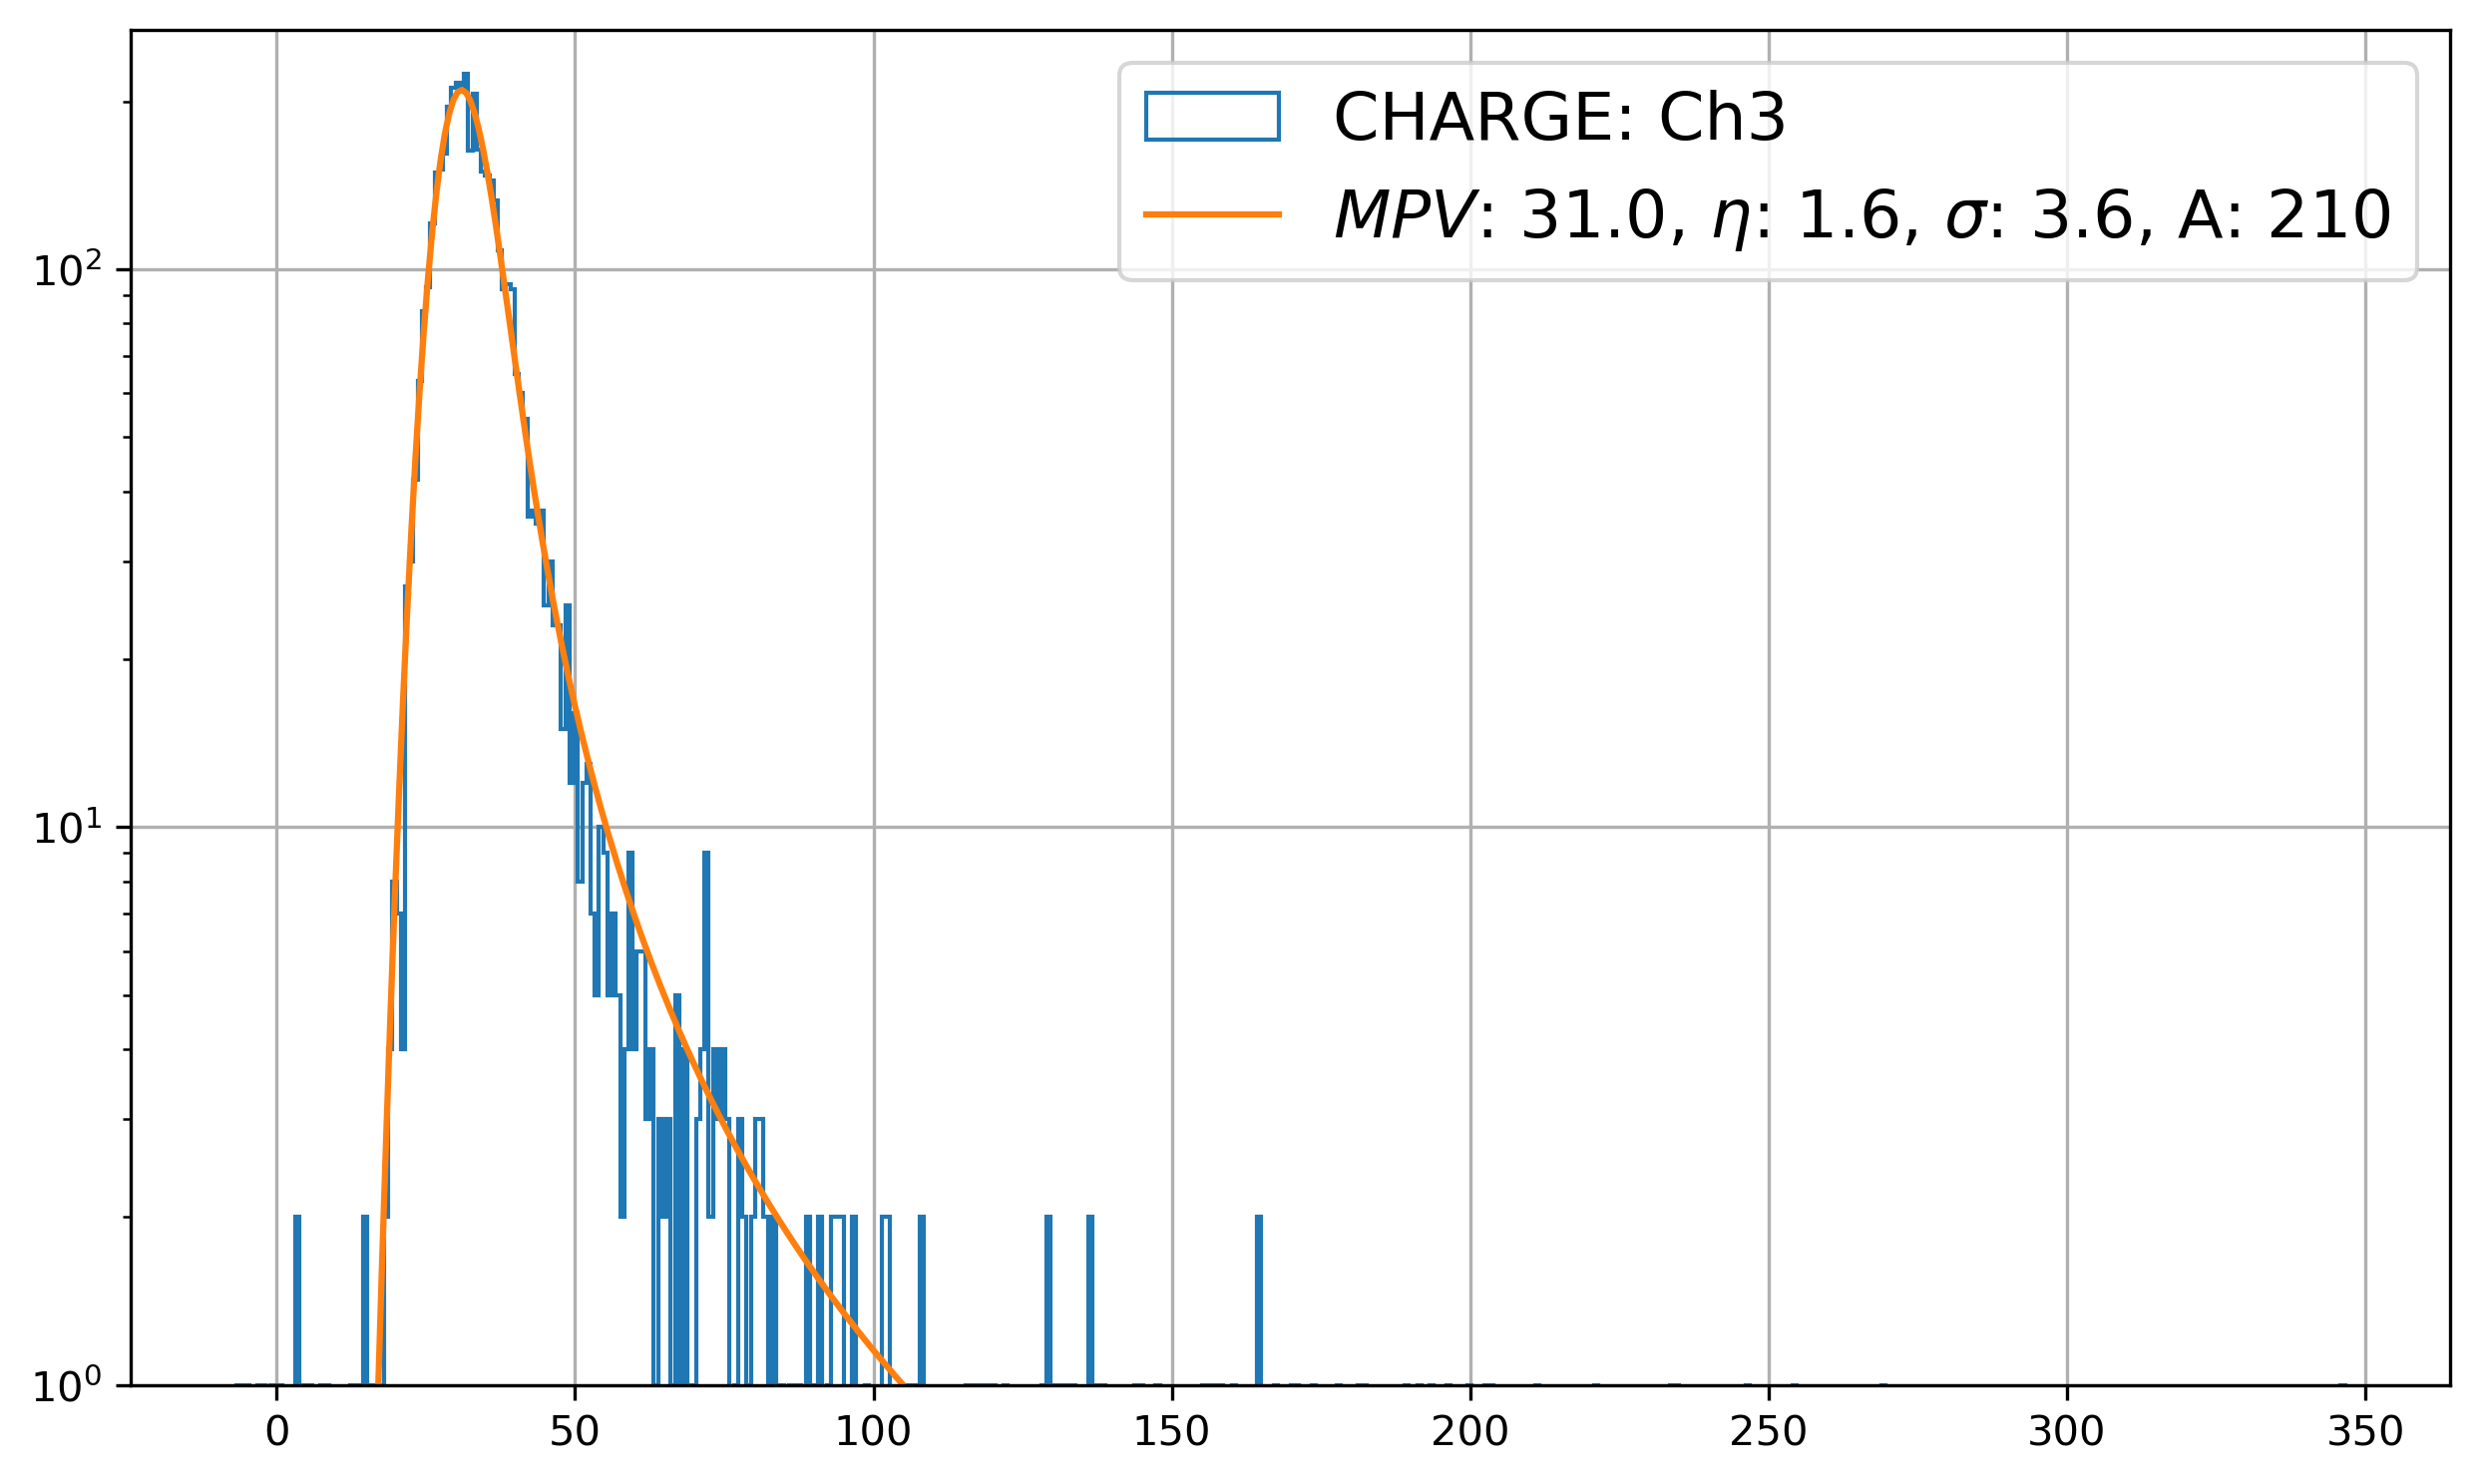

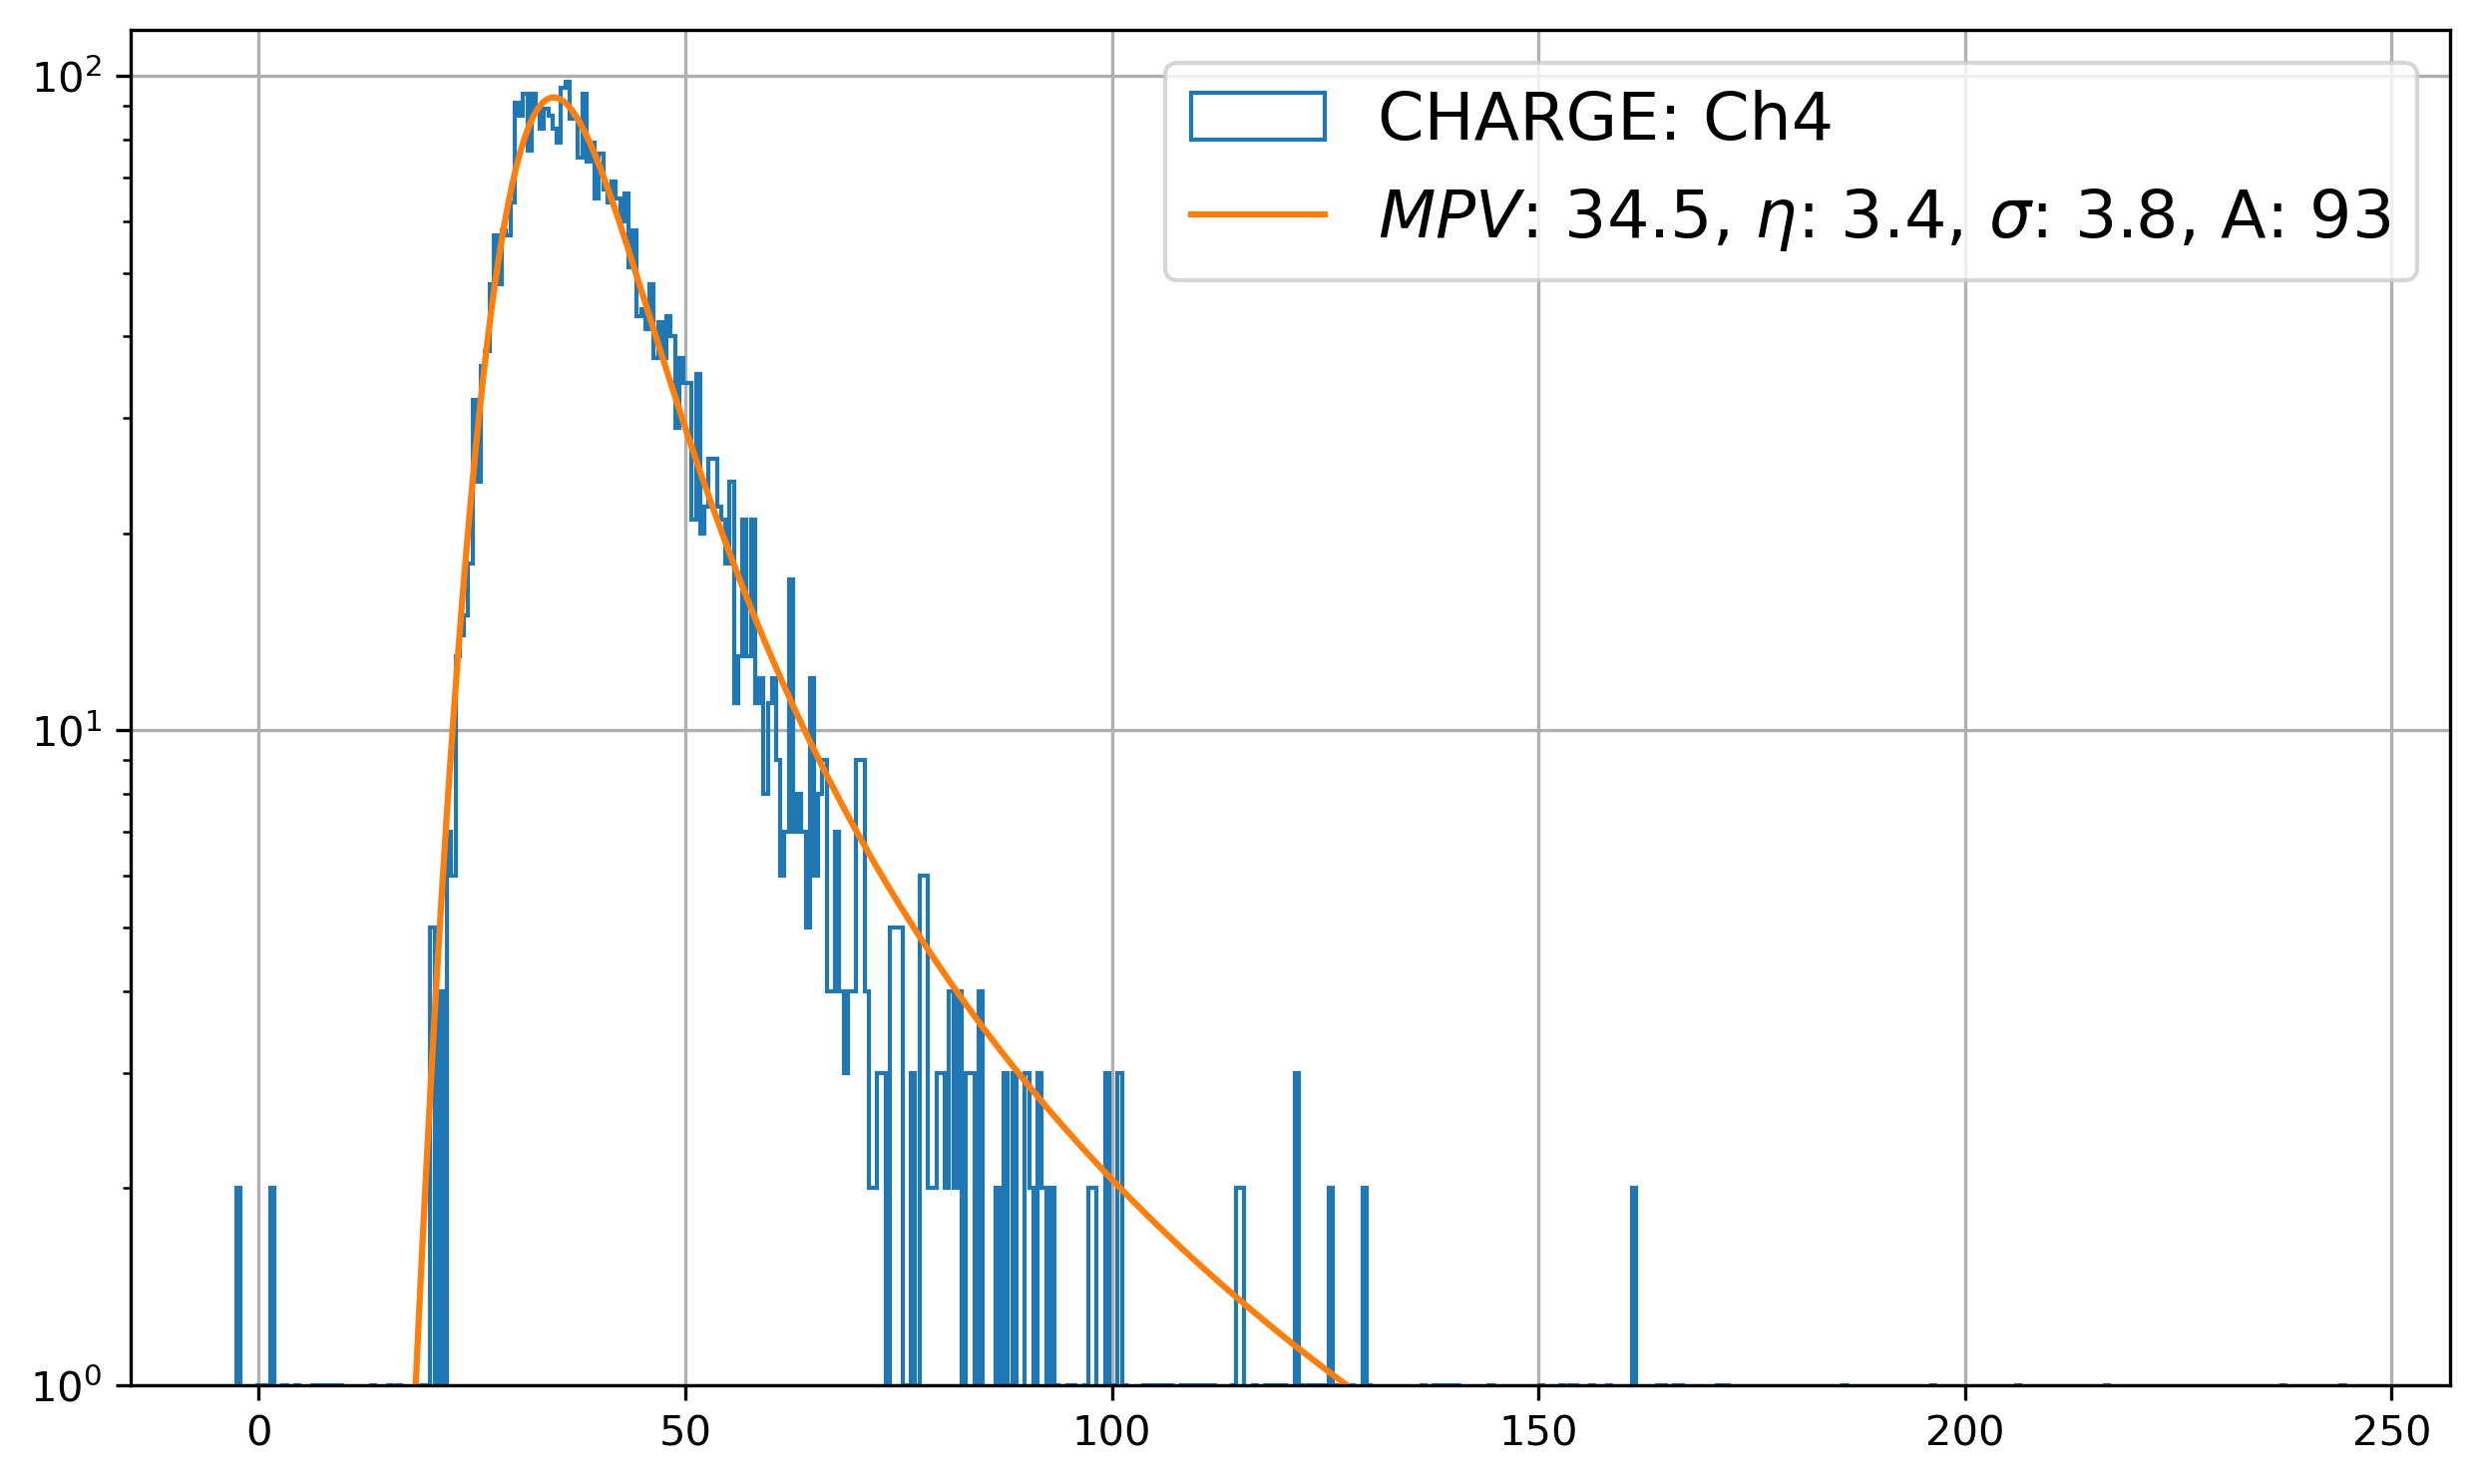

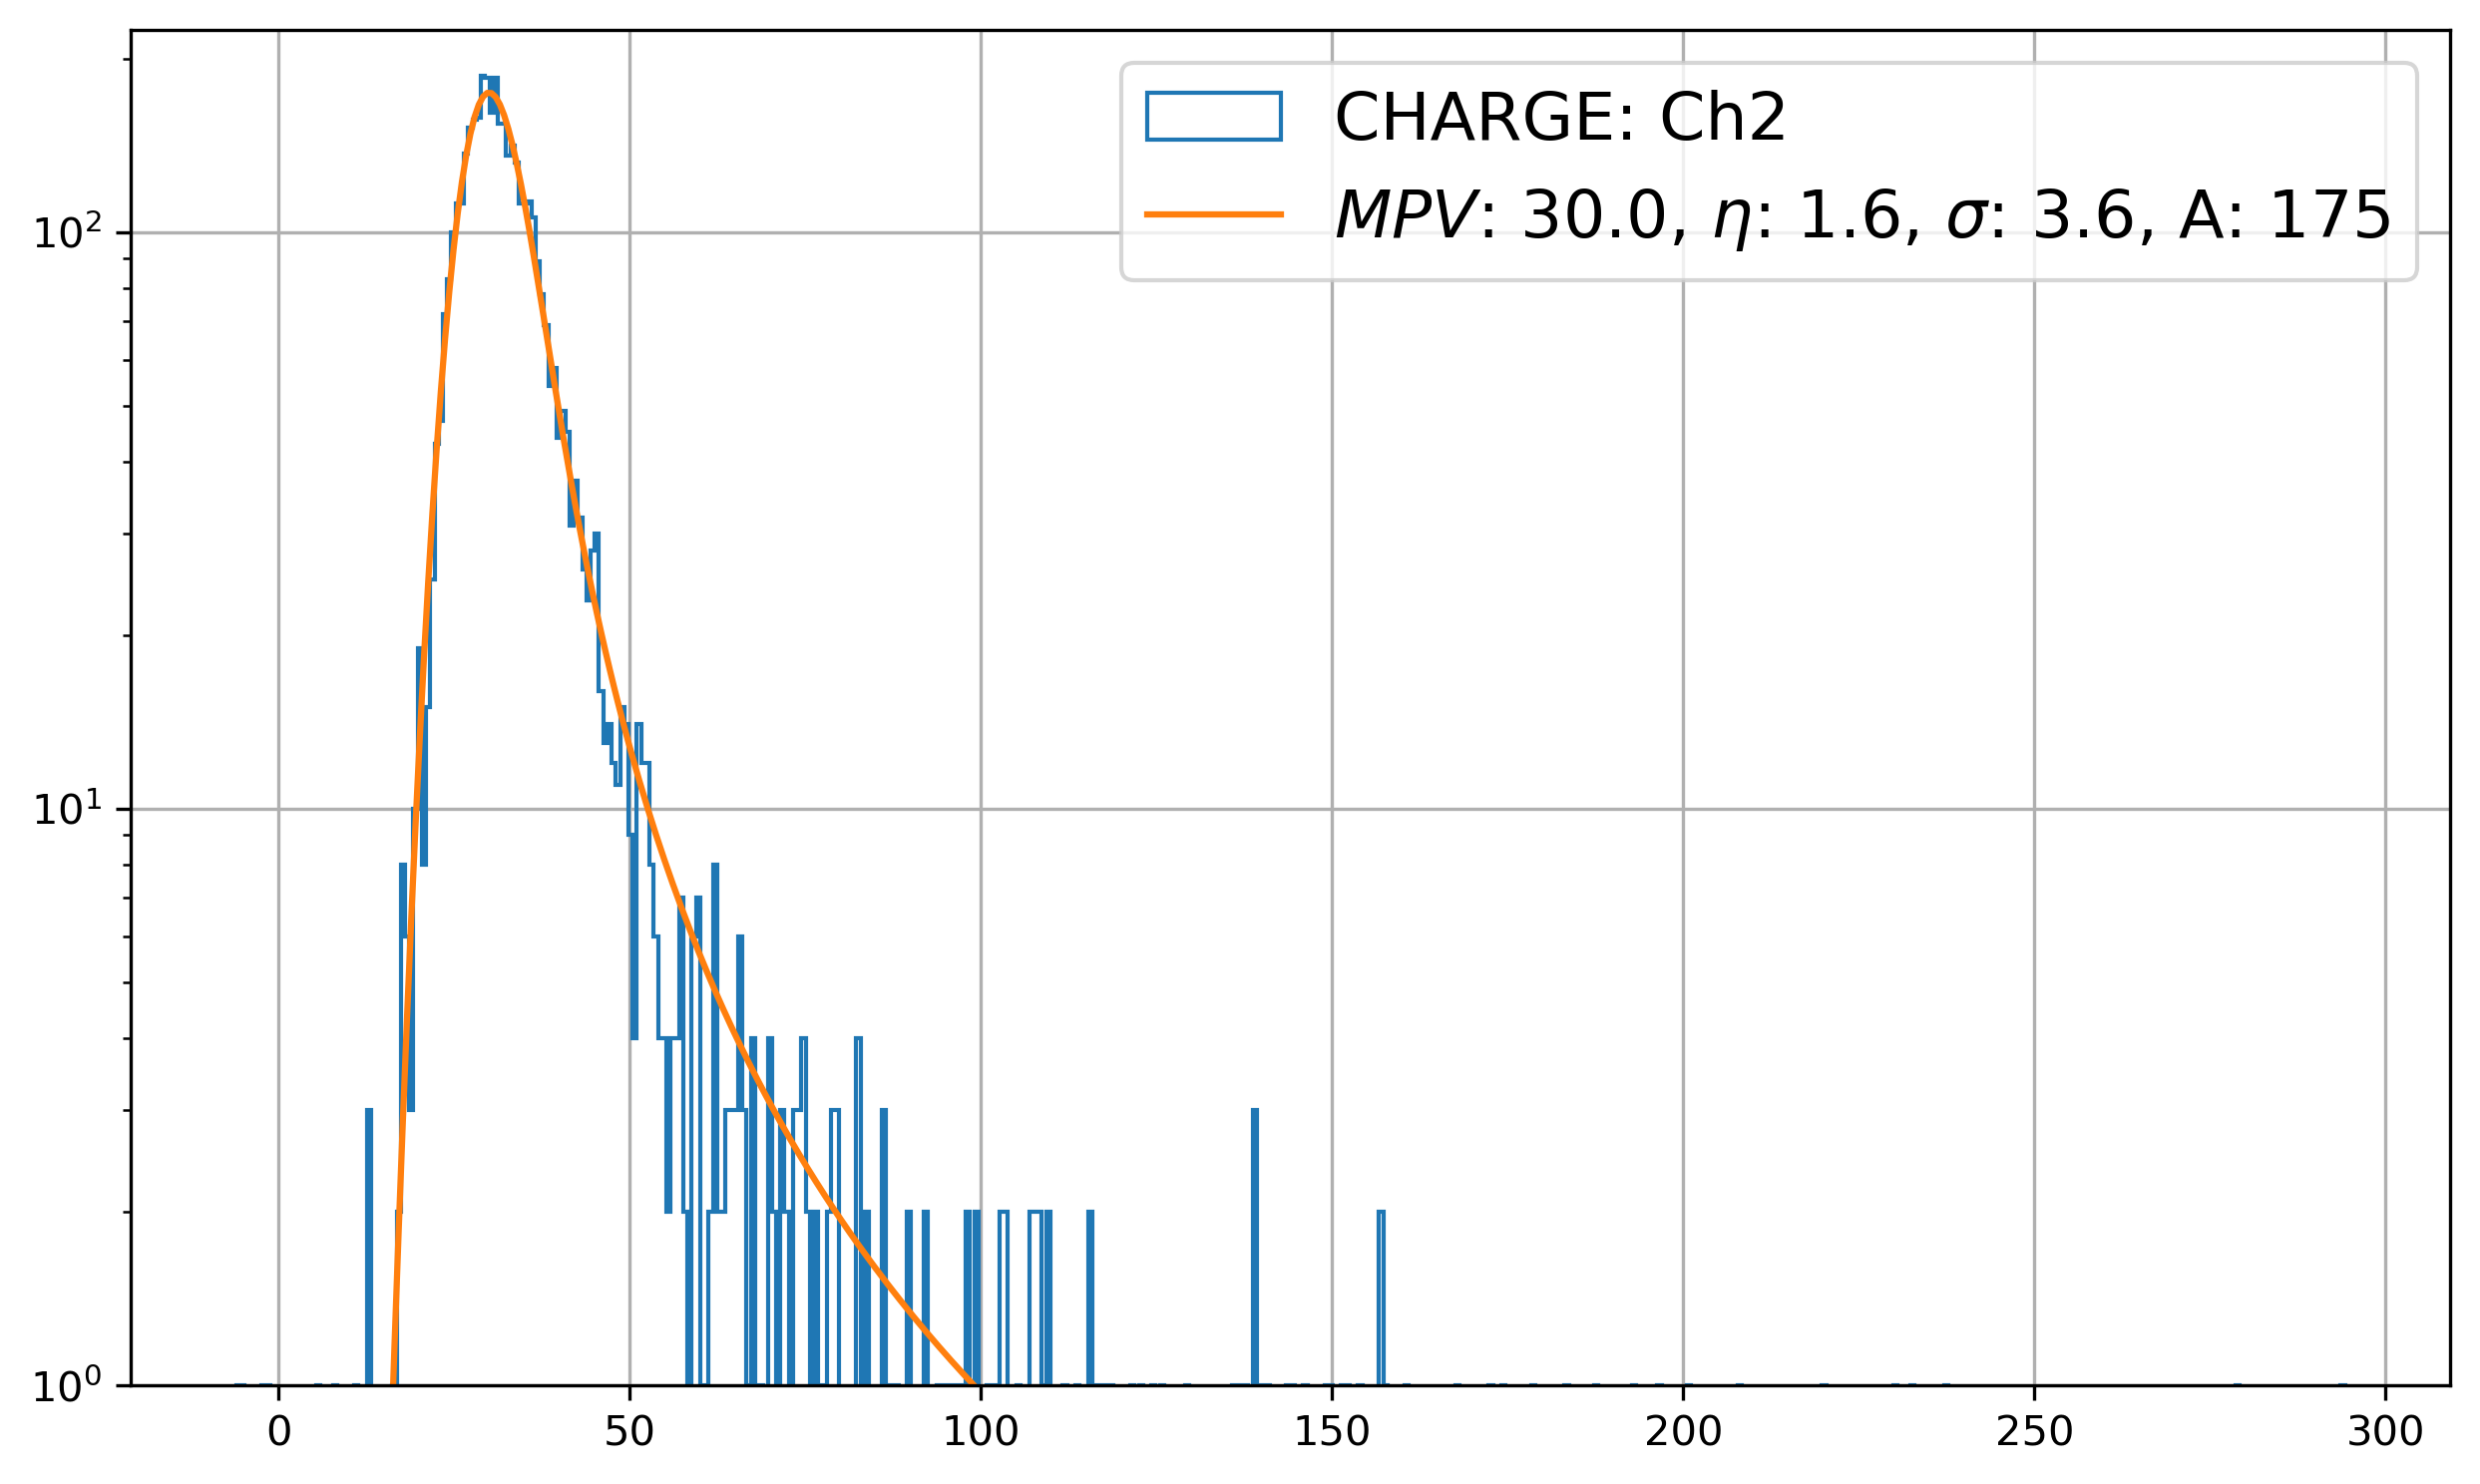

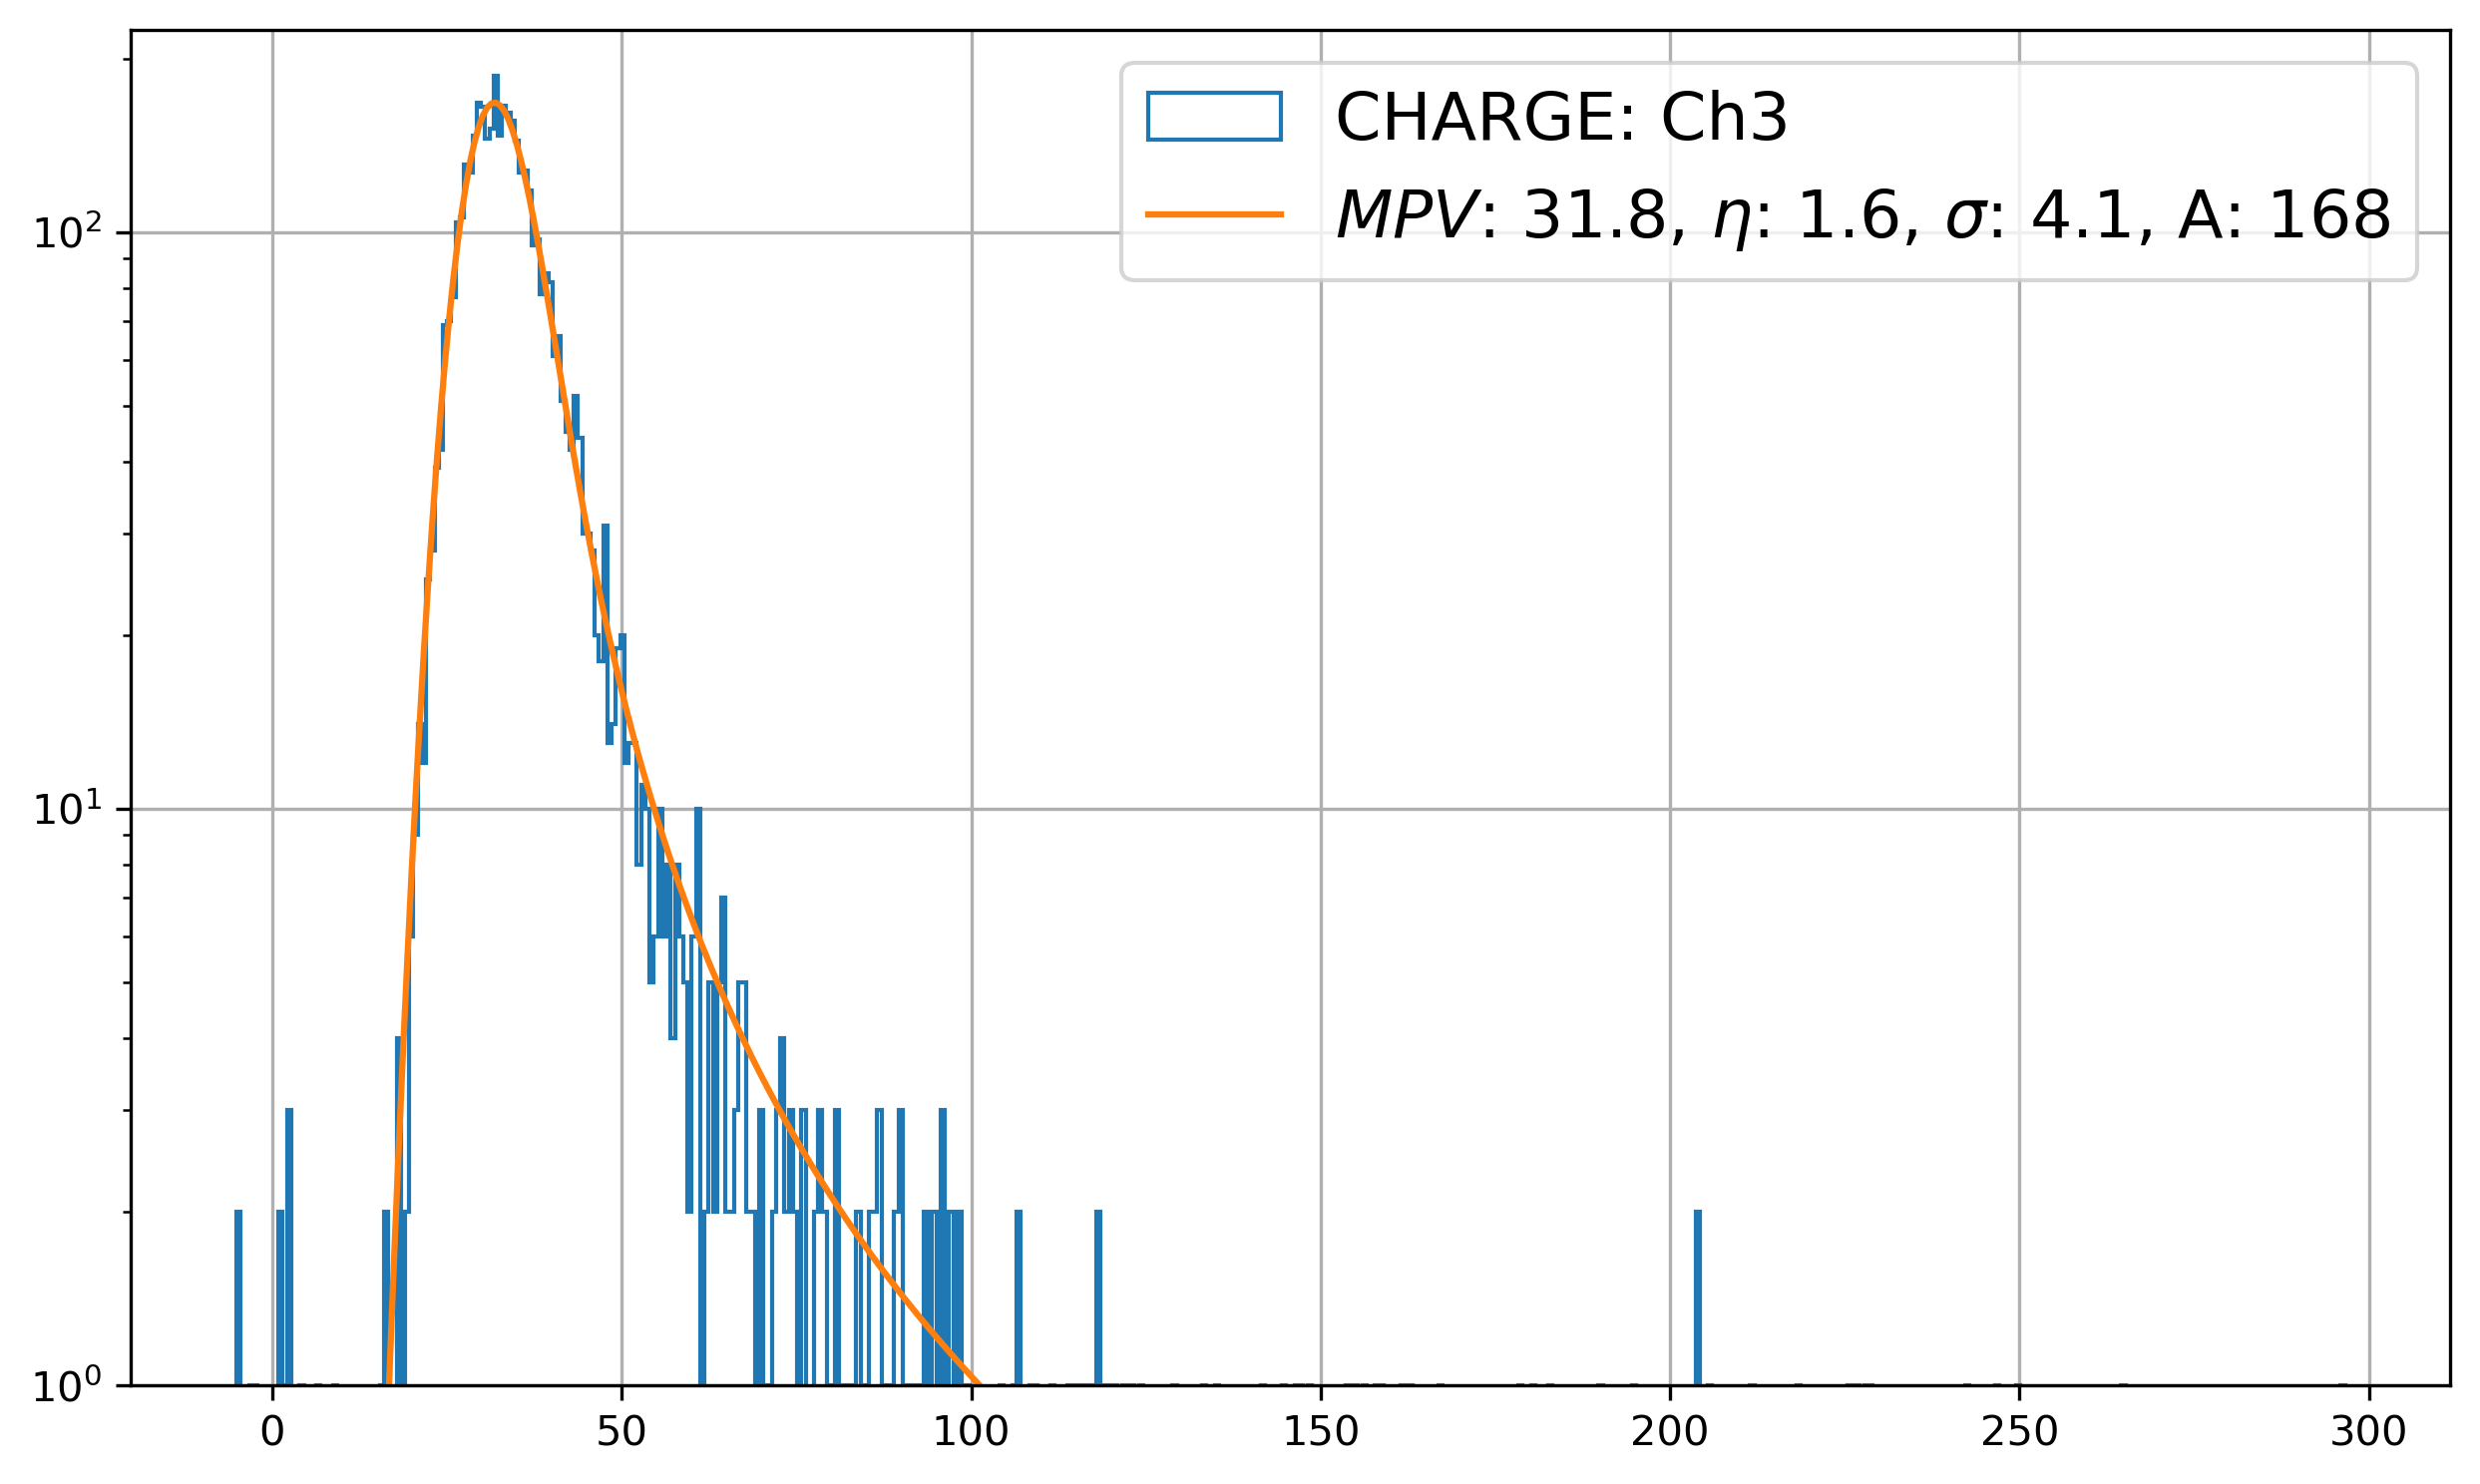

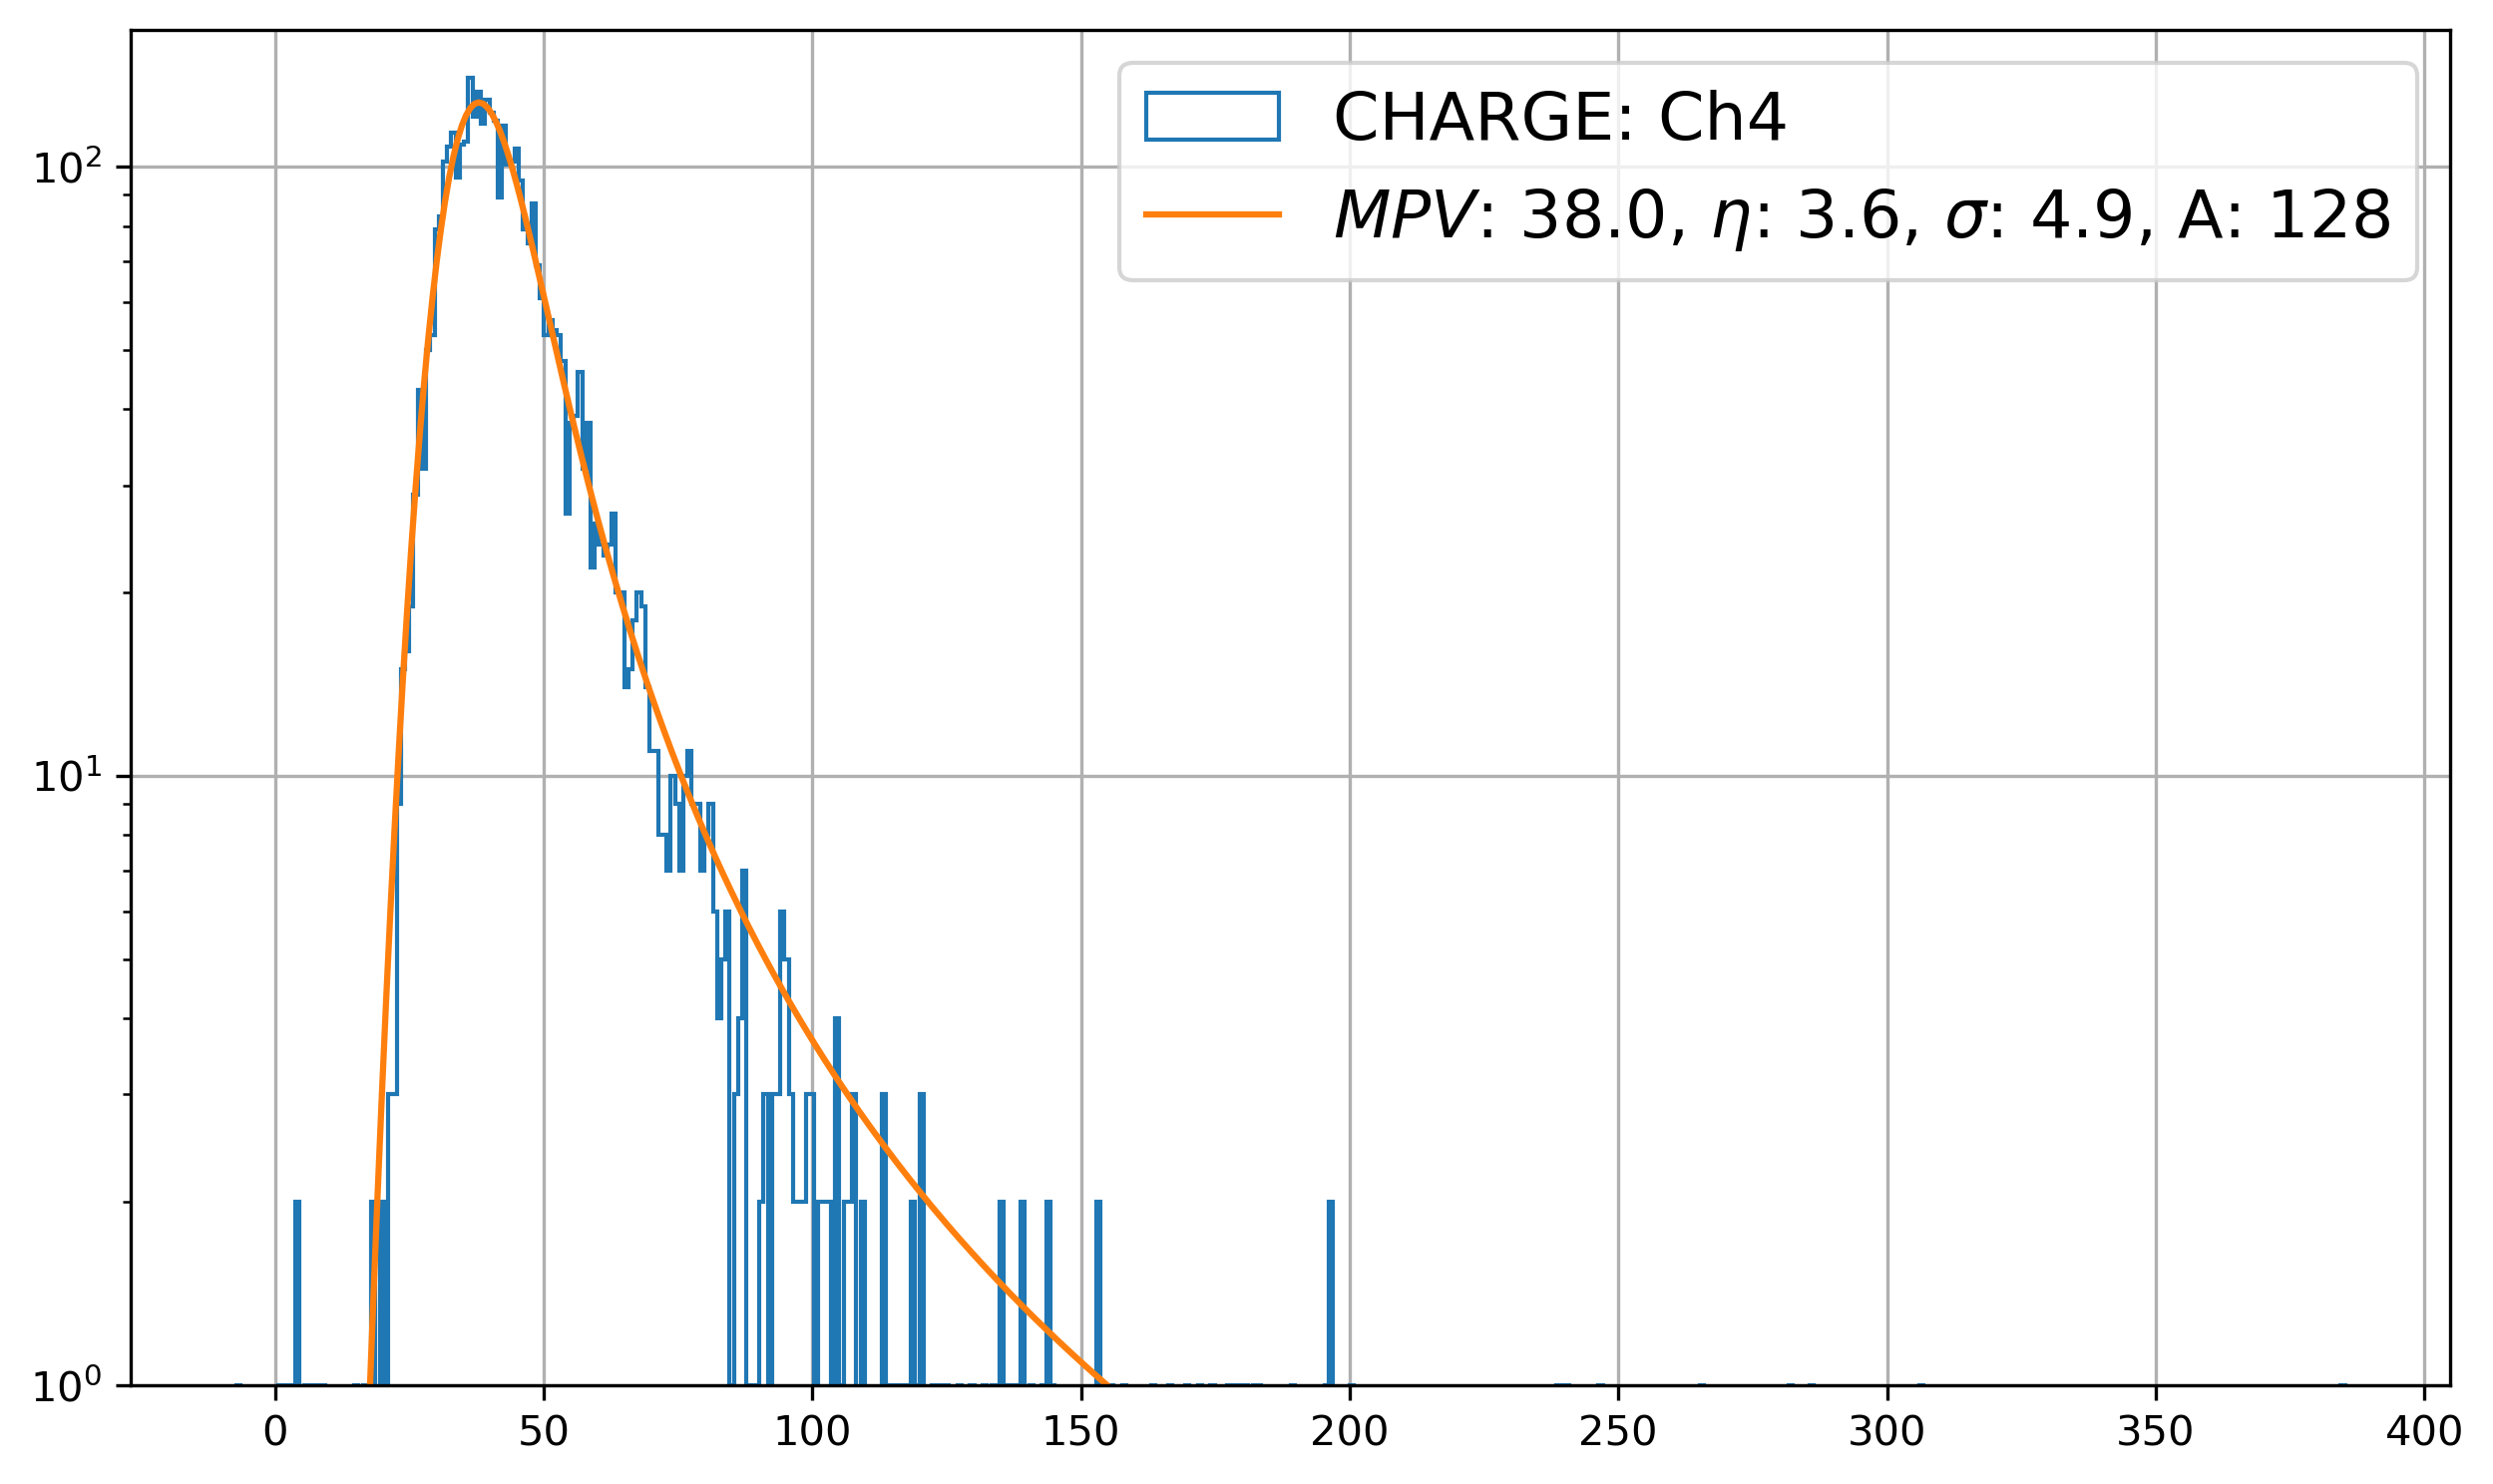

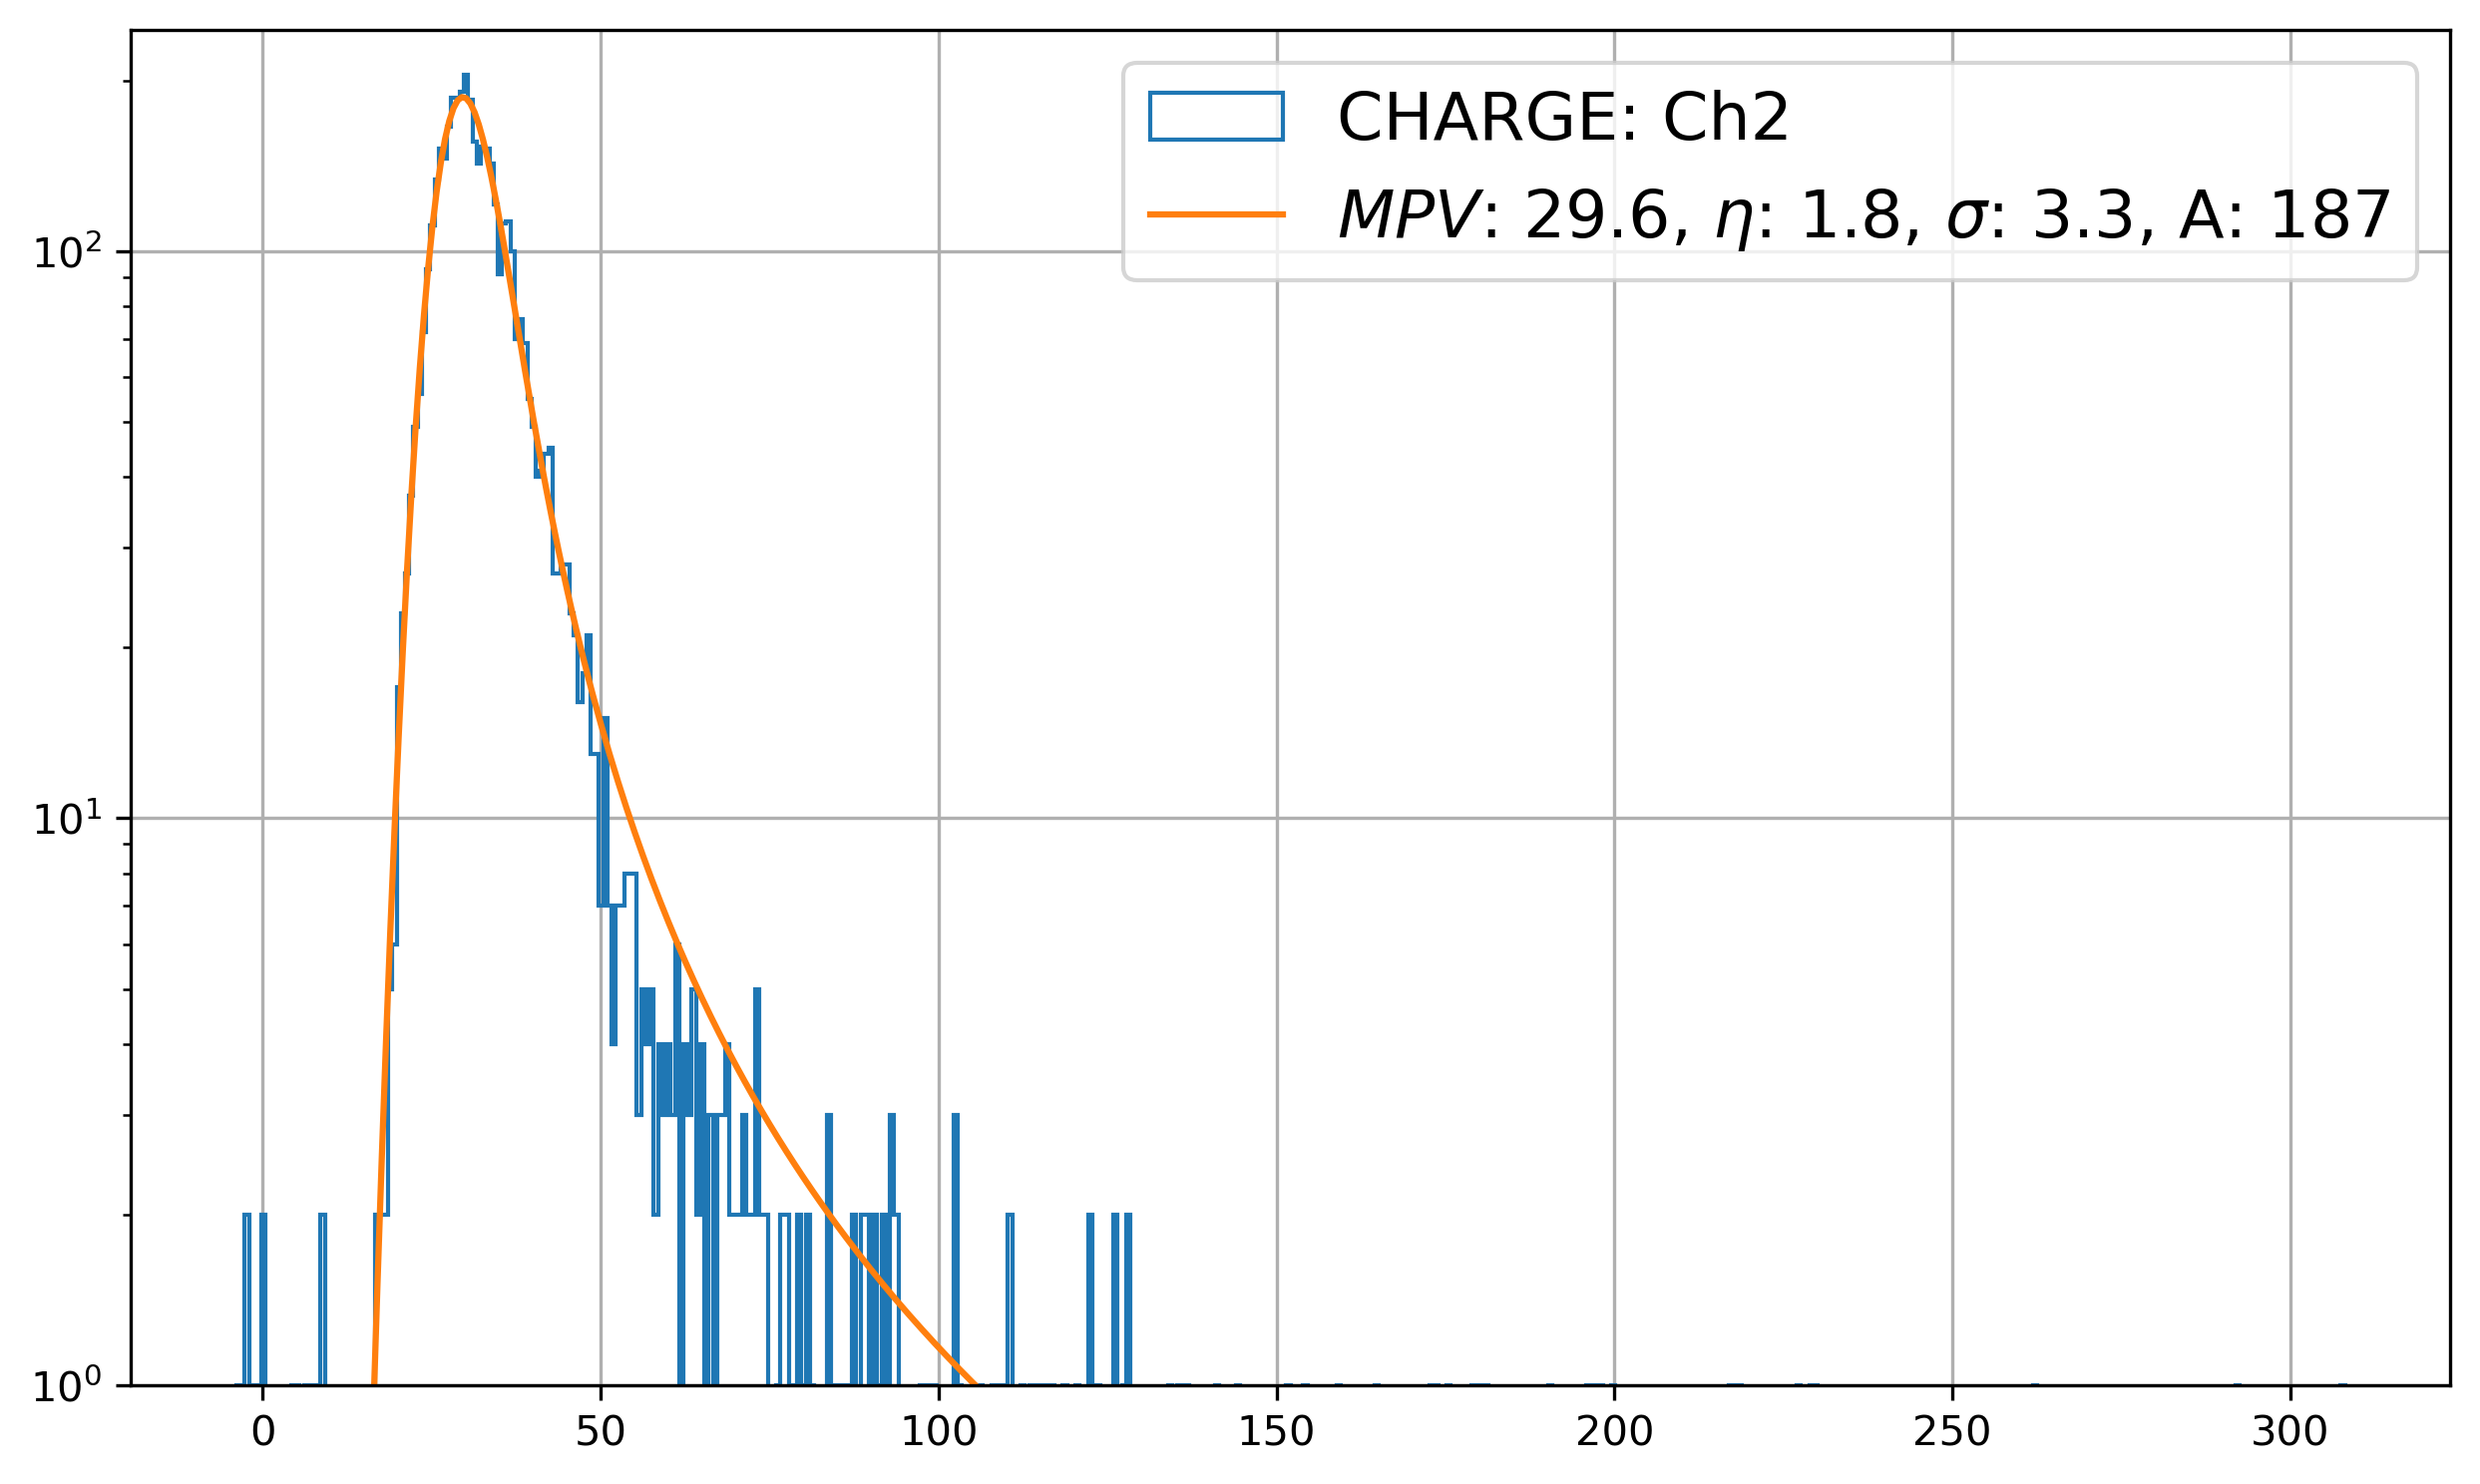

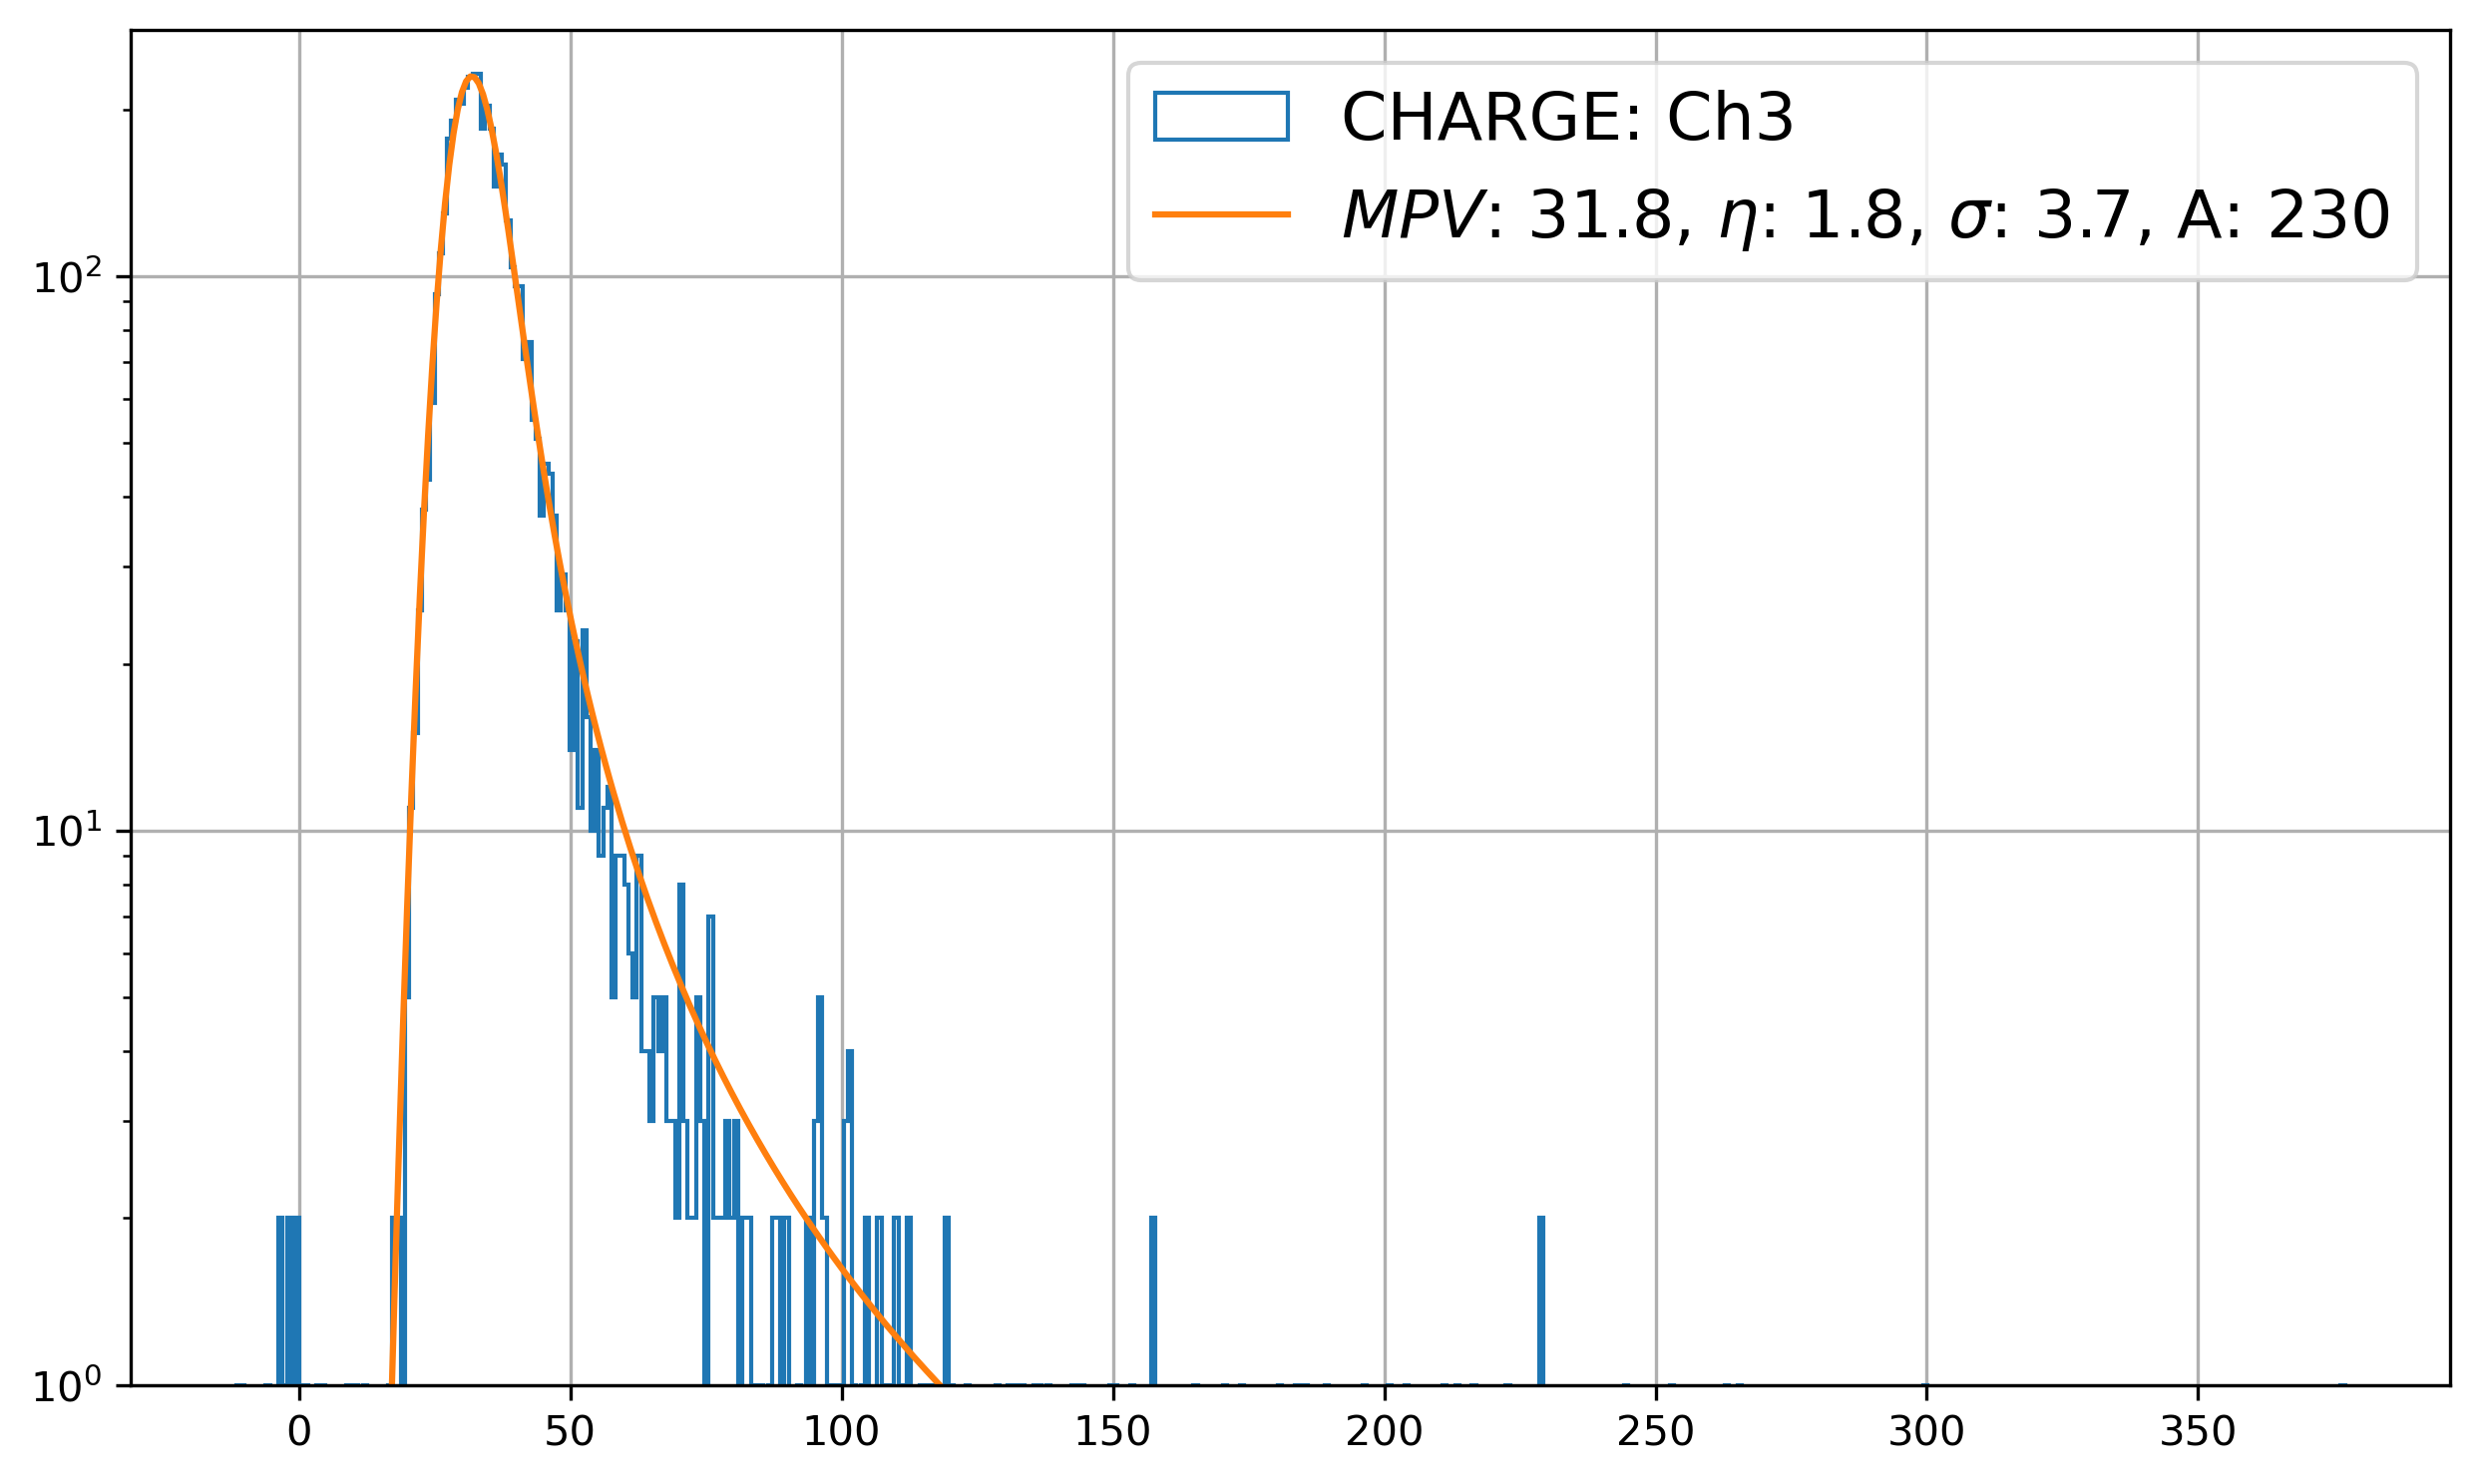

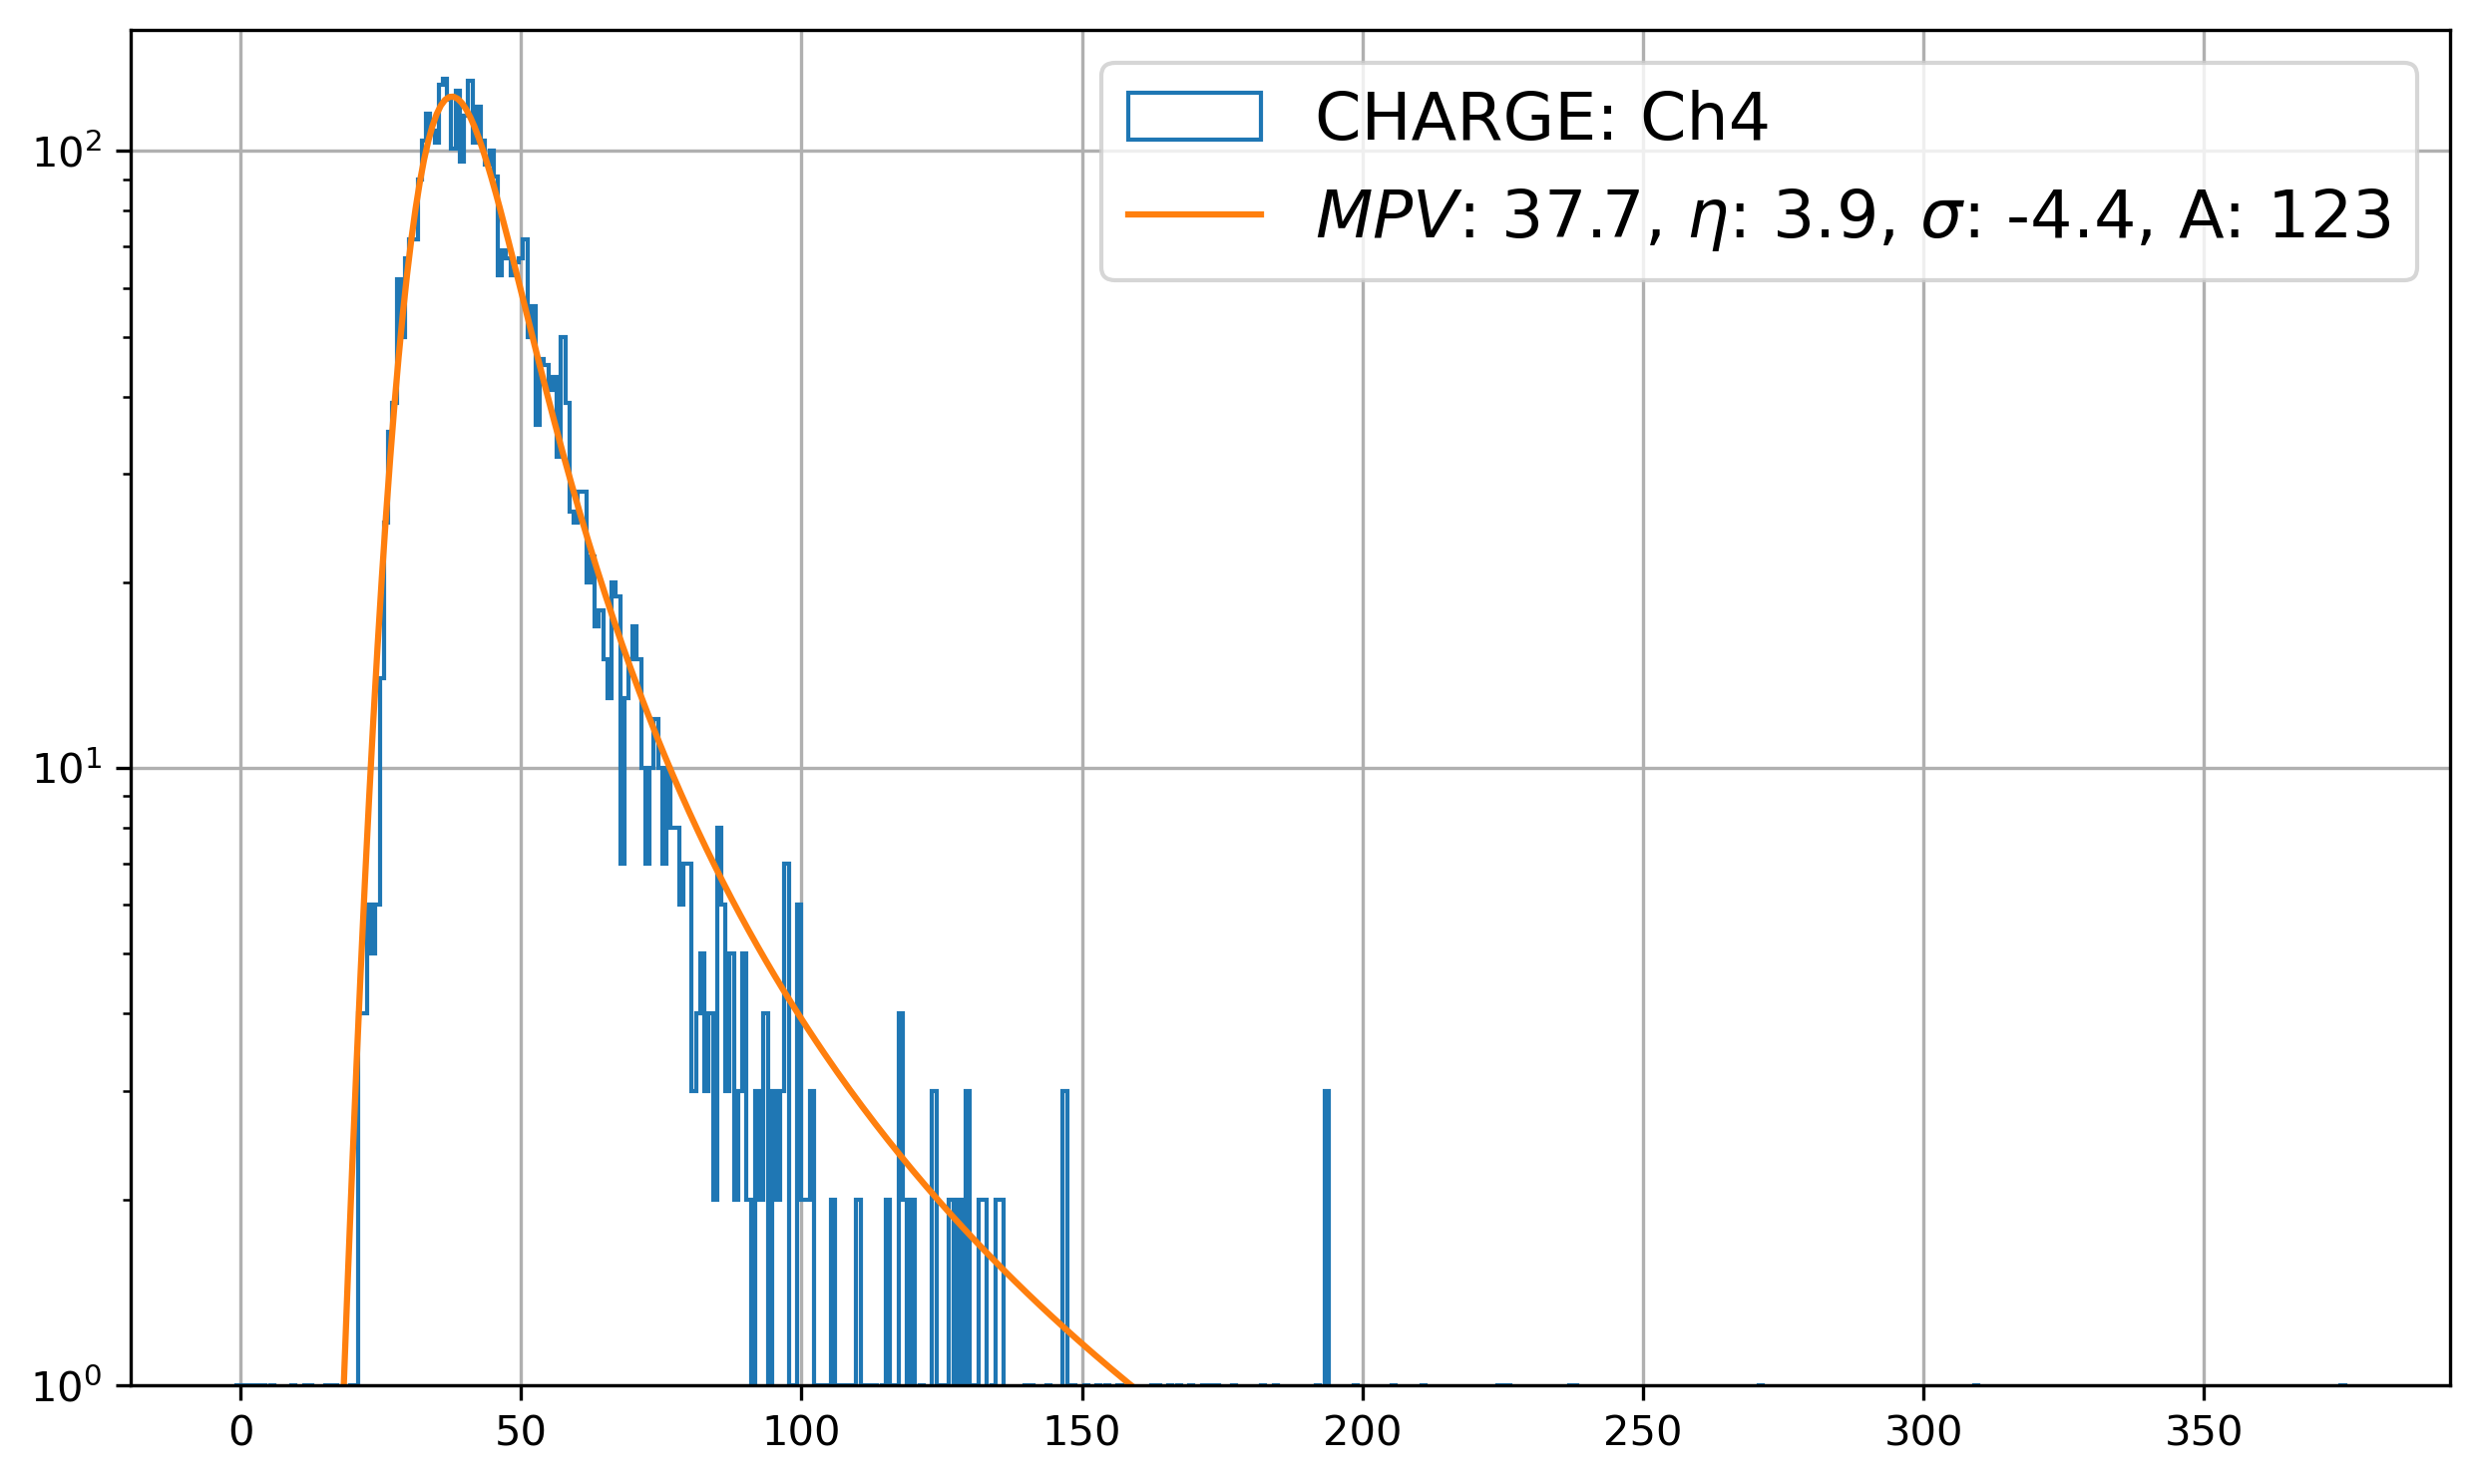

In [18]:
for run in these_runs:
    quick_analysis(run, S_run, df_analysis, dict_of_batches, DUTs)

In [19]:
df_analysis.loc[idx[:,1],:]

,,sensor name,MCP_voltage,voltage,current,tempA,tempB,angle,humidity,fluence,charge,charge_error,efficiency,time_mean,time_sigma,time_sigma_error,comments,exclude
run,dut,,,,,,,,,,,,,,,,,
9761,1,USTC2.1-W17-P6-A,2800,-105,0.000001,-29.1,-29.3,6.0,12.411111,0,25.900865,0.000497,99.749431,-5914.172942,39.498563,0.868102,{},False
9762,1,USTC2.1-W17-P6-A,2800,-105,0.000001,-25.8,-26.0,6.0,12.411111,0,25.502153,0.000703,99.81814,-5912.896983,39.9306,0.89988,{},False
9763,1,USTC2.1-W17-P6-A,2800,-105,0.000001,-28.9,-29.1,6.0,12.411111,0,27.76699,0.000837,99.782714,-5913.683317,37.395548,0.874098,{},False
9764,1,USTC2.1-W17-P6-A,2800,-105,0.000001,-30.9,-31.2,6.0,12.411111,0,29.030237,0.000537,99.737418,-5914.627572,37.099779,0.824065,{},False
9769,1,USTC2.1-W17-P6-A,2800,-105,0.000001,-31.9,-32.2,6.0,12.411111,0,29.960639,0.00083,99.905146,-5914.030175,37.047275,0.866056,{},False
9775,1,USTC2.1-W17-P6-A,2800,-105,0.000001,-32.0,-32.3,6.0,12.411111,0,29.631408,0.000963,99.907728,-5914.141047,37.057933,0.838987,{},False


In [100]:
# dut = 2
# temperature = np.array((df_analysis.loc[idx[:,dut],:]['tempA']+df_analysis.loc[idx[:,dut],:]['tempB'])/2)
# charge = np.array(df_analysis.loc[idx[:,dut],:]['charge'])
# time_sigma = np.array(df_analysis.loc[idx[:,dut],:]['time_sigma'])
# eff = np.array(df_analysis.loc[idx[:,dut],:]['efficiency'])

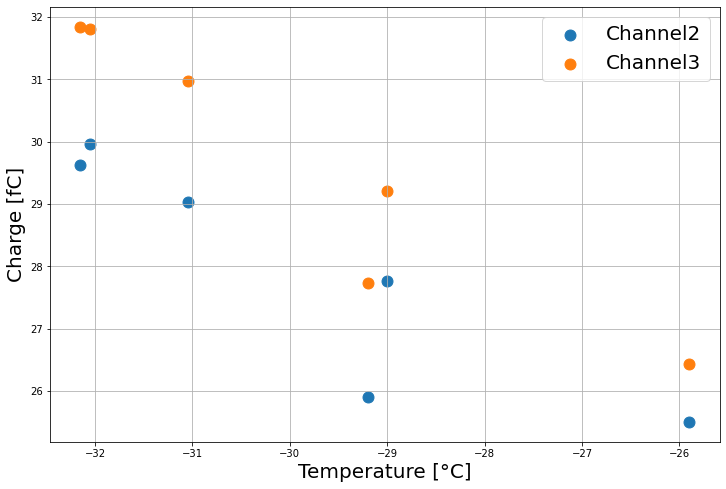

In [20]:
DUTs = [1,2]

fig,ax = plt.subplots(figsize=(12,8))
for dut in DUTs:
    temperature = np.array((df_analysis.loc[idx[:,dut],:]['tempA']+df_analysis.loc[idx[:,dut],:]['tempB'])/2)
    charge = np.array(df_analysis.loc[idx[:,dut],:]['charge'])
#     time_sigma = np.array(df_analysis.loc[idx[:,dut],:]['time_sigma'])
#     eff = np.array(df_analysis.loc[idx[:,dut],:]['efficiency'])
    
    ax.scatter(temperature, charge, s=120, label=f'Channel{dut+1}')
    
ax.grid('--')
ax.set_xlabel("Temperature [°C]", fontsize=20)
ax.set_ylabel("Charge [fC]", fontsize=20)
ax.legend(fontsize=20)

if SAVE:
    fig.savefig(os.path.join(pres_path, f"Charge vs temperature {this_batch}_{S_run}_dut{DUTs}.png"), bbox_inches="tight")


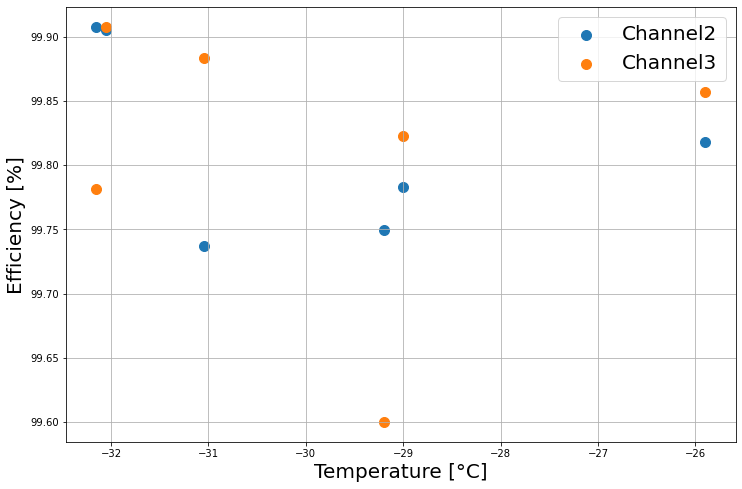

In [21]:
fig,ax = plt.subplots(figsize=(12,8))

for dut in DUTs:
    temperature = np.array((df_analysis.loc[idx[:,dut],:]['tempA']+df_analysis.loc[idx[:,dut],:]['tempB'])/2)
#     charge = np.array(df_analysis.loc[idx[:,dut],:]['charge'])
#     time_sigma = np.array(df_analysis.loc[idx[:,dut],:]['time_sigma'])
    eff = np.array(df_analysis.loc[idx[:,dut],:]['efficiency'])
    
    ax.scatter(temperature, eff, s=100, label=f'Channel{dut+1}')
    
ax.grid('--')
ax.set_xlabel("Temperature [°C]", fontsize=20)
ax.set_ylabel("Efficiency [%]", fontsize=20)
ax.legend(fontsize=20)
if SAVE:
    fig.savefig(os.path.join(pres_path, f"Efficiency vs temperature {this_batch}_{S_run}_dut{DUTs}.png"), bbox_inches="tight")


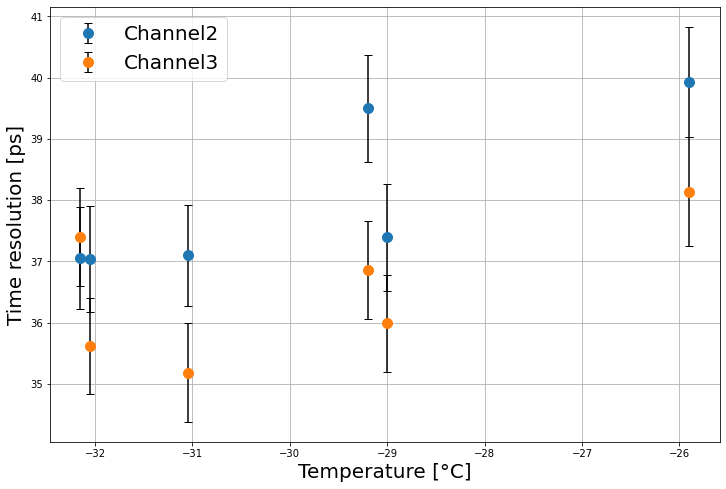

In [22]:
fig,ax = plt.subplots(figsize=(12,8))
for dut in DUTs:
    temperature = np.array((df_analysis.loc[idx[:,dut],:]['tempA']+df_analysis.loc[idx[:,dut],:]['tempB'])/2)
#     charge = np.array(df_analysis.loc[idx[:,dut],:]['charge'])
    time_sigma = np.array(df_analysis.loc[idx[:,dut],:]['time_sigma'])
    time_sigma_error = np.array(df_analysis.loc[idx[:,dut],:]['time_sigma_error'])
    
#     eff = np.array(df_analysis.loc[idx[:,dut],:]['efficiency'])
    
    ax.errorbar(temperature, time_sigma, yerr=time_sigma_error, 
                ecolor='k', marker='o', markersize=10, capsize=4, linestyle='',
                label=f'Channel{dut+1}')
    
ax.grid('--')
ax.set_xlabel("Temperature [°C]", fontsize=20)
ax.set_ylabel("Time resolution [ps]", fontsize=20)
ax.legend(fontsize=20)
if SAVE:
    fig.savefig(os.path.join(pres_path, f"Time resolution vs temperature {this_batch}_{S_run}_dut{DUTs}.png"), bbox_inches="tight")


(array([1., 1., 1., 0., 3.]),
 array([26.450839108708653, 27.51934847695362, 28.58785784519859,
        29.65636721344356, 30.724876581688527, 31.793385949933498],
       dtype=object),
 [<matplotlib.patches.Polygon at 0x7f6f459dc640>])

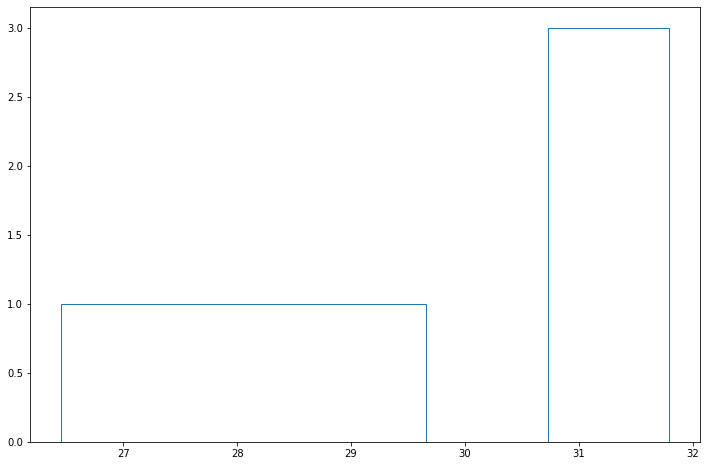

In [92]:
fig,ax = plt.subplots(figsize=(12,8))
ax.hist(charge, bins=5, histtype='step')

(array([1., 3., 0., 0., 0., 0., 1., 3., 2., 2.]),
 array([96.2485790071997, 96.47294027718516, 96.69730154717064,
        96.9216628171561, 97.14602408714157, 97.37038535712705,
        97.59474662711251, 97.81910789709798, 98.04346916708344,
        98.26783043706892, 98.49219170705439], dtype=object),
 [<matplotlib.patches.Polygon at 0x7f6cadde3e20>])

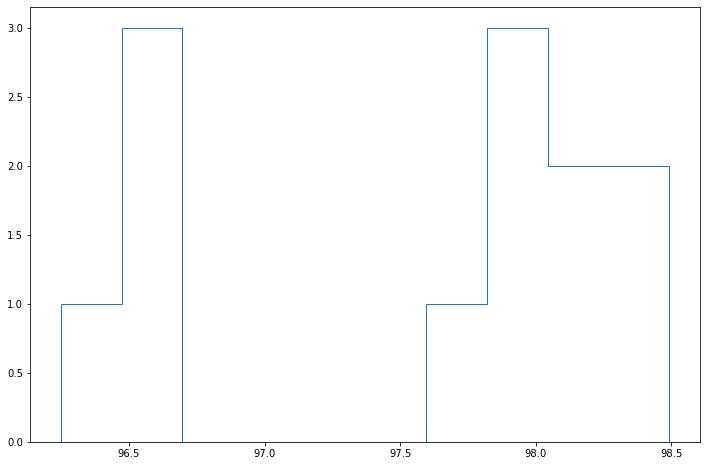

In [30]:
fig,ax = plt.subplots(figsize=(12,8))
ax.hist(eff, bins=10, histtype='step')